# Euclid Grizli Pipeline using grizli 1.6.0 (2023.0217)

### Euclid Parameters and Requirements
https://sci.esa.int/web/euclid/-/euclid-nisp-instrument

https://www.euclid.caltech.edu/page/technical-details

### Wide Survey Imaging
(20,000 deg^2 = 2pi sr)

RIZ <= 24.5 AB (10 sigma, extended source)

YJH <= 24 AB (5 sigma)

### Deep Survey Imaging
(40 deg^2)

RIZ <= 26.5 AB (10 sigma)

YJH <= 26 AB (5 sigma)


https://sci.esa.int/c/portal/doc.cfm?fobjectid=46064

https://www.euclid.caltech.edu/page/62

https://ui.adsabs.harvard.edu/abs/2022A%26A...662A.112E/abstract

## To-Do

# Table of Contents

1. Setup
    1. [Import Python modules](#Import-Python-modules)
    2. [Install templates for redshift fitting](#Install-templates-for-redshift-fitting)
    3. [Python Helper Functions](#Python-Helper-Functions) 
    4. [Path to my simulation directories](#Path-to-my-simulation-directories)
2. [Find sources in the direct image](#Find-sources-in-the-direct-image)
3. [Read SExtractor Photometry of Direct Images](#Read-SExtractor-Photometry-of-Direct-Images)
4. [Euclid object simulation](#Euclid-object-simulation)
5. [Check simulation](#Check-simulation)
6. [Show direct images and slitless spectra](#Show-direct-images-and-slitless-spectra)
7. [Loop over all objects and fit their redshifts](#Loop-over-all-objects-and-fit-their-redshifts)
8. [Inspect Redshift Fitting Results](#Inspect-Redshift-Fitting-Results)
9. [Extract a single 2D spectrum](#Extract-a-single-2D-spectrum)
10. [1D Spectral Extraction](#1D-Spectral-Extraction)
11. [Display Redshift Fit](#Display-Redshift-Fit)

Appendix - Old
1. [aXeSIM predictions based on conf file](#aXeSIM-predictions-based-on-conf-file)
2. [Show 2D beam](#Show-2D-beam)
3. [Simple SN calculations based on the spcontetc](#Simple-SN-calculations-based-on-the-spcontetc)
4. [Simple SN calculations based on the pzcaletc](#Simple-SN-calculations-based-on-the-pzcaletc)
5. [Simple SN calculations based on the apttables2021](#Simple-SN-calculations-based-on-the-apttables2021)
6. [Roman and Euclid Sensitivity Function](#Roman-and-Euclid-Sensitivity-Function)
7. [Velocity resolution](#Velocity-resolution)
8. [Fit redshift to source](#Fit-redshift-to-source)
9. [Coordinates Check](#Coordinates-check)
10. [SED Check](#SED-check)

[top](#Table-of-Contents)

# Setup

In [1]:
%matplotlib inline

## Import Python modules
[top](#Table-of-Contents)

In [ ]:
# Only use if you are editing the Python code while running the Jupyter notebook.
import importlib
importlib.reload(grizli_functions)

In [2]:
import grizli_functions
#from grizli_functions import wcs_pixel_scale, check_sims, create_circular_mask
from grizli_functions import add_noise, wcs_pixel_scale, check_sims, display_grizli
from grizli_functions import fake_euclid_direct
print(grizli_functions.__file__)
# import jwst failure is ok!

`import jwst` failed so JWST processing will not work!
/Users/gwalth/python.linux/dev/grizli_functions.py



Unable to locate credentials. You can configure credentials by running "aws configure".


In [3]:
import glob, os, sys, time
from collections import OrderedDict

import matplotlib as mpl    
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

from IPython.display import Image

mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rcParams['font.size'] = 14
mpl.rcParams['savefig.dpi'] = 72

import numpy as np
#from math import cos, sin, atan2, pi
from math import sqrt, log

import astropy
import astropy.io.fits as pyfits
from astropy import wcs
from astropy.table import Table, unique, join
from astropy.modeling import models

import drizzlepac
import photutils

import grizli
import grizli.model
import grizli.multifit
from grizli import utils, multifit, fitting
import grizli.fake_image
from grizli.pipeline import auto_script
from grizli import prep

print('\n Python version: ', sys.version)
print('\n Grizli version: ', grizli.__version__)
print('\n Astropy version: ', astropy.__version__)



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol

 Python version:  3.9.16 (main, Jan 11 2023, 10:02:19) 
[Clang 14.0.6 ]

 Grizli version:  1.6.0.dev43

 Astropy version:  5.2.1


In [4]:
####################################
# constants
####################################
Jy = 1.0E-23        # erg/s/cm^2/Hz
mJy = 1e-3          # Jy
uJy = 1e-6          # Jy
Mpc = 3.086e24      # cm
Ang = 1E-8          # cm
mu = 1E-4           # cm

c_km = 2.9979E5     # km/s
c = 2.9979E10       # cm/s
h = 6.626068E-27    # cm^2*g/s           # erg s 
k = 1.3806503E-16   # cm^2*g/(s^2*K)

## Install templates for redshift fitting
[top](#Table-of-Contents)

Run only once for the install

#### WFC3 and ACS calibs

In [ ]:
grizli.utils.fetch_default_calibs()

#### WFC3 PSF and Pickles stars

In [ ]:
grizli.utils.fetch_config_files()

#### Templates used in fitting

In [ ]:
grizli.utils.symlink_templates(force=False)

# Python Helper Functions
[top](#Table-of-Contents)

In [5]:
def euclid_det():

    all_det = []

    for i in range(0,4): 
        for j in range(0,4):
            print(i+1,j+1)
            num = '%i%i' % (i+1,j+1)
            det = 'DET%s' % (num)       
            all_det.append(det)
    print(all_det)
    return all_det

In [6]:
def write_individual_slitless(slitless_file):
    
    # Read in Euclid slitless multi-extension fits and write single frame for each detector

    # Loops through all detectors

    hdu_old = pyfits.open(slitless_file)
    print(hdu_old.info())

    # for now dq is ones
    dq = np.ones((2048,2048)) 

    all_slitless = []

    for i in range(0,4): 
        for j in range(0,4):
            #print(i+1,j+1)
            num = '%i%i' % (i+1,j+1)
            #det = 'DET' + num
        
            #conf_file = 'NISP-GLWv2-DET%s' % (num)
            slitless = "Euclid_DET%s_slitless.fits"  % (num)
            #print(conf_file)
            print(slitless)
        
            all_slitless.append(slitless)

            # test to read conf_file in grismconf.py
            #det = conf_file.split("-")[-1][-2:]
            #print(det)
        
            head = hdu_old['DET%s.SCI' % (num)].header
            data = hdu_old['DET%s.SCI' % (num)].data
            err = hdu_old['DET%s.CHI2' % (num)].data
        

            hdu = pyfits.PrimaryHDU(header=head)  
            hdu.name = 'PRIMARY'
    
            hdu_sci = pyfits.ImageHDU(data,header=head)  
            hdu_sci.name = 'SCI'
            hdu_err = pyfits.ImageHDU(err,header=head)
            hdu_err.name = 'ERR'
            hdu_dq = pyfits.ImageHDU(dq,header=head)
            hdu_dq.name = 'DQ'

            hdu1 = pyfits.HDUList([hdu,hdu_sci,hdu_err,hdu_dq])
            hdu1.writeto(slitless, overwrite=True)
            hdu1.info()

            #hdu[ext].header['INSTRUME'] = 'NISP-DET%i%i-GLWv2' % (i+1,j+1)
            
    return all_slitless

In [7]:
def plot_slitless(slitless_file, verb=0):
    hdu = pyfits.open(slitless_file)
    if verb:
        print(hdu[0].header)
        hdu.info()

    fig = plt.figure(figsize=(12,12))

    k = 0
    for i in range(0,4): 
        for j in range(0,4):
            #print(i+1,j+1)
            num = '%i%i' % (i+1,j+1)
            name = 'DET%s.SCI' % (num)
            #name = 'DET%i%i.CHI2' % (i+1,j+1)
        
            img = hdu[name].data
            head = hdu[name].header
            if verb:
                print(img.shape)
                print(name)
                print(head['CRVAL1'])
                print(head['CRVAL2'])
                print(head['CRPIX1'])
                print(head['CRPIX2'])
        
                print(np.min(img))
                print(np.max(img))
                print(np.mean(img))
                print(np.median(img))
                print(np.std(img))
                print()
                #print(hdu[name].header)
                #print()
        
            p = fig.add_subplot(4,4,k+1)
            p.imshow(img,vmin=200,vmax=3000)
        
            p.text(0.05,0.9,name,transform=p.transAxes)
            #p.hist(img.flatten(), bins=100)
            #p.set_yscale("log")
        
            k += 1
        
    plt.show()

In [8]:
def read_slitless_headers(slitless_file, verb=0, plot=0):

    hdu = pyfits.open(slitless_file)
    if verb:
        print(hdu[0].header)
        hdu.info()

    spec_exptime = hdu[0].header['exptime']

    if plot:
        fig = plt.figure(figsize=(8,8))
        ax1 = fig.add_subplot(111)

    heads = {}

    for i in range(4):
        for j in range(4):
            name = 'DET%i%i.SCI' % (i+1,j+1)
            #name = 'DET%i%i.CHI2' % (i+1,j+1)
        
            #img = hdu[name].data
            head = hdu[name].header
            heads[name] = head
            
            x = head['CRPIX1']
            y = head['CRPIX2']
            
            if verb:
                print(head)
                print(name)
                print(head['CRVAL1'])
                print(head['CRVAL2'])
                print(head['CRPIX1'])
                print(head['CRPIX2'])
                print(x,y)
                print()
            
            if plot:
                ax1.scatter(x,y)
                ax1.text(x,y,name)
    
    if plot:
        plt.show()
        
    return heads

In [9]:
def map_src_to_det(thumb_temp = 'NIS_catalog_file_%s.thm.beamA.fits',
                   wcs_temp = "../Euclid_DET%s_wcs.fits", plot=1):

    # Loops through all detectors

    det_dict = {}

    for i in range(0,4): 
        for j in range(0,4):
            print(i+1,j+1)
            num = '%i%i' % (i+1,j+1)

            head = heads['DET%s.SCI' % (num)]

            nhdu = pyfits.PrimaryHDU()                                                              
            nhdu.header = head  
            nhdu.header.tofile(wcs_temp % (num),overwrite=True)
            #print(head)
            #print()
            #print(nhdu)                                                                            
                                                                                                                                                                               
            w = wcs.WCS(nhdu)  

            hdu = pyfits.open(thumb_temp % (num))
            sources = [h.header['EXTNAME'] for h in hdu[1:]]
            det_thumb_tbl = Table([sources], names=['SOURCE_ID'])
        
            det_tbl = join(det_thumb_tbl, primer, keys='SOURCE_ID')

            world = [[ra,dec] for ra,dec in det_tbl['RA','DEC']]
            pixcrd = w.wcs_world2pix(world, 0)                                              

            det_tbl['X_PIX'] = pixcrd[:,0]
            det_tbl['Y_PIX'] = pixcrd[:,1]
        
            if plot:
                fig = plt.figure()
        
                p1 = fig.add_subplot(121)
                p1.scatter(det_tbl['X_PIX'],det_tbl['Y_PIX'])
                p1.set_aspect("equal")
                #p1.set_xlim()
        
                p2 = fig.add_subplot(122)
                p2.scatter(det_tbl['X_PIX'],det_tbl['Y_PIX'])
        
                x0,x1 = p2.get_xlim()
        
                p2.plot([x0,x1],[0,0],"--",c="r")
                p2.plot([x0,x1],[2048,2048],"--",c="r")        
                p2.set_aspect("equal")        
        
                plt.show()
        
            print(sources)
            print()
            print()
        
            det_dict[num] = det_tbl

    print(det_dict)
    #return det_tbl, det_dict
    return det_dict

In [10]:
emlines = [["OVI",         1038.0],         # 0
           ["Ly$\\alpha$", 1215.67],        # 1
           ["CIV",     1550.0],             # 2
           ["CIII]",   1909.],              # 3
           ["CII]",    2327.],              # 4
           ["MgII",    2796.4],             # 5
           ["MgII",    2803.5],             # 6
           ["NeV",     3326.],              # 7
           ["[OII]",   3727.],  # O2        # 8
           ["[NeIII]", 3868.7],             # 9
           ["H$\gamma$",  4340.5],  # Hg    # 10
           ["[OIII]",  4363.0],  # O31      # 11
           ["H$\\beta$",   4861.3],  # Hb   # 12
           ["[OIII]",  4959.0],  # O32      # 13
           ["[OIII]",  5007.0],  # O33      # 14
           ["[NII]",   6548.1],             # 15
           ["H$\\alpha$",  6562.8],  # Ha   # 16
           ["[NII]",   6583.0],             # 17
           ["[SII]",   6717.0],             # 18
           ["[SII]",   6731.0],             # 19
           ["P$\\delta$", 10049.8],  # Pd   # 20
           ["P$\\gamma$", 10938.0],  # Pg   # 21
           ["P$\\beta$",  12818.1],  # Pb   # 22
           ["P$\\alpha$", 18750.1],  # Pa   # 23 
           ["Br$\\delta$", 19440.0],  # Br-d (wikipedia, not exact)
           ["Br$\\gamma$", 21660.0],  # Br-g (wikipedia, not exact)
           ["Br$\\beta$",  26250.0],  # Br-b (wikipedia, not exact)
           ["Br$\\alpha$", 40510.0],  # Br-a (wikipedia, not exact) 
          ]

# http://hyperphysics.phy-astr.gsu.edu/hbase/Tables/hydspec.html
# http://articles.adsabs.harvard.edu//full/1934ApJ....80...19M/0000022.000.html


## (TESTING) Reload Core Grizli Python Functions - SKIP

Only use if you are editing the Python code while running the Jupyter notebook.

In [ ]:
import importlib
importlib.reload(grizli.grismconf)

In [ ]:
import importlib
importlib.reload(grizli.pipeline.auto_script)

In [ ]:
import importlib
importlib.reload(grizli.model)

In [ ]:
import importlib
importlib.reload(grizli.multifit)

In [ ]:
import importlib
importlib.reload(grizli.fitting)

In [ ]:
import importlib
importlib.reload(grizli.utils)

# Start processing here!

## Path to my simulation directories
[top](#Table-of-Contents)

In [11]:
#os.chdir('../')
#os.chdir('/Users/gwalth/data/Roman/grizli/sims/')
os.chdir('/Users/gwalth/data/Roman/grizli/sims/Euclid')

#os.chdir('/local/RomanSims/grizli/sims/') # cygnusd
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)
root = "SIM_10_18_22"
#root = "SIM_12_23_22"

HOME_PATH =  /Users/gwalth/data/Roman/grizli/sims/Euclid


## Input files

In [12]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

In [13]:
#slitless_files = glob.glob('EUC_SIM_*.fits')
#slitless_files.sort()
#print(len(slitless_files))

# First test
slitless_files = ['EUC_SIM_NISRGS000-0-1_20220913T230154.141Z_TEST_SC8_NIS_S1.fits']
catalog_files = ['CATALOG_WP9_INTERMEDIATE_RUN_v2_NewCoord_mod.fits']

print(slitless_files)
print(catalog_files)

['EUC_SIM_NISRGS000-0-1_20220913T230154.141Z_TEST_SC8_NIS_S1.fits']
['CATALOG_WP9_INTERMEDIATE_RUN_v2_NewCoord_mod.fits']


In [ ]:
slitless_files = glob.glob("EUC_SIM_NISR*.fits")
catalog_files = glob.glob("CATALOG*.fits")
print(slitless_files)
print(catalog_files)

## Directory Structure

I was structing it similar to Grizli with Prep, RAW and Extraction directories.  If this were real mission data, the stage that we recieved from Anihita would have been drizzled images and spectra which would go into the Prep directories.

This is just showing that we have the right directories and we can find all of the files.

In [14]:
# Clean
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

!rm *_direct.fits
!rm *_slitless.fits
!rm *_wcs.fits
!rm *_final*.fits
!rm *_final.cat
!rm Euclid_GrismFLT.pickle

rm: No match.
rm: No match.
rm: Euclid_GrismFLT.pickle: No such file or directory


In [15]:
# detector header names
all_det = euclid_det()

1 1
1 2
1 3
1 4
2 1
2 2
2 3
2 4
3 1
3 2
3 3
3 4
4 1
4 2
4 3
4 4
['DET11', 'DET12', 'DET13', 'DET14', 'DET21', 'DET22', 'DET23', 'DET24', 'DET31', 'DET32', 'DET33', 'DET34', 'DET41', 'DET42', 'DET43', 'DET44']


In [16]:
## Write individual files for each extension of the slitless spectra
# Grizli is easier to manage when writing out all of the files. 
# At some point we'll want to read the data extensions directly into Grizli, 
# this is currently a kludge.
all_slitless = [write_individual_slitless(sf) for sf in slitless_files]
print(all_slitless)

Filename: EUC_SIM_NISRGS000-0-1_20220913T230154.141Z_TEST_SC8_NIS_S1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   ()      
  1  DET11.SCI     1 ImageHDU        31   (2048, 2048)   int16 (rescales to uint16)   
  2  DET11.CHI2    1 ImageHDU        17   (2048, 2048)   uint8   
  3  DET21.SCI     1 ImageHDU        31   (2048, 2048)   int16 (rescales to uint16)   
  4  DET21.CHI2    1 ImageHDU        17   (2048, 2048)   uint8   
  5  DET31.SCI     1 ImageHDU        31   (2048, 2048)   int16 (rescales to uint16)   
  6  DET31.CHI2    1 ImageHDU        17   (2048, 2048)   uint8   
  7  DET41.SCI     1 ImageHDU        31   (2048, 2048)   int16 (rescales to uint16)   
  8  DET41.CHI2    1 ImageHDU        17   (2048, 2048)   uint8   
  9  DET12.SCI     1 ImageHDU        31   (2048, 2048)   int16 (rescales to uint16)   
 10  DET12.CHI2    1 ImageHDU        17   (2048, 2048)   uint8   
 11  DET22.SCI     1 ImageHDU        31   (2048,

Euclid_DET44_slitless.fits
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   ()      
  1  SCI           1 ImageHDU        29   (2048, 2048)   uint16   
  2  ERR           1 ImageHDU        29   (2048, 2048)   uint8   
  3  DQ            1 ImageHDU        29   (2048, 2048)   float64   
[['Euclid_DET11_slitless.fits', 'Euclid_DET12_slitless.fits', 'Euclid_DET13_slitless.fits', 'Euclid_DET14_slitless.fits', 'Euclid_DET21_slitless.fits', 'Euclid_DET22_slitless.fits', 'Euclid_DET23_slitless.fits', 'Euclid_DET24_slitless.fits', 'Euclid_DET31_slitless.fits', 'Euclid_DET32_slitless.fits', 'Euclid_DET33_slitless.fits', 'Euclid_DET34_slitless.fits', 'Euclid_DET41_slitless.fits', 'Euclid_DET42_slitless.fits', 'Euclid_DET43_slitless.fits', 'Euclid_DET44_slitless.fits']]


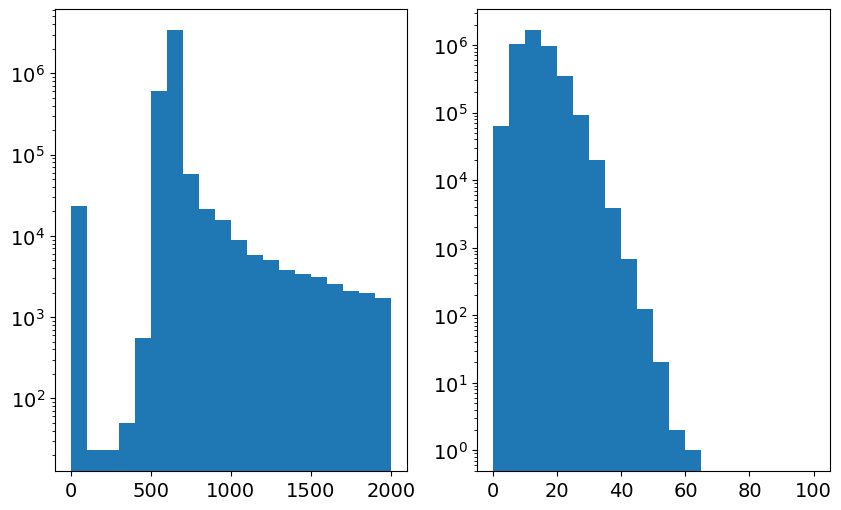

In [17]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

file = "Euclid_DET11_slitless.fits"
pf = pyfits.open(file)

data = pf['SCI'].data - 1024.
X = data.flatten()

data = pf['ERR'].data
Y = data.flatten()

fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.hist(X,bins=20, range=(0,2000))
ax1.set_yscale("log")

ax2 = fig.add_subplot(122)
ax2.hist(Y,bins=20, range=(0,100))
ax2.set_yscale("log")


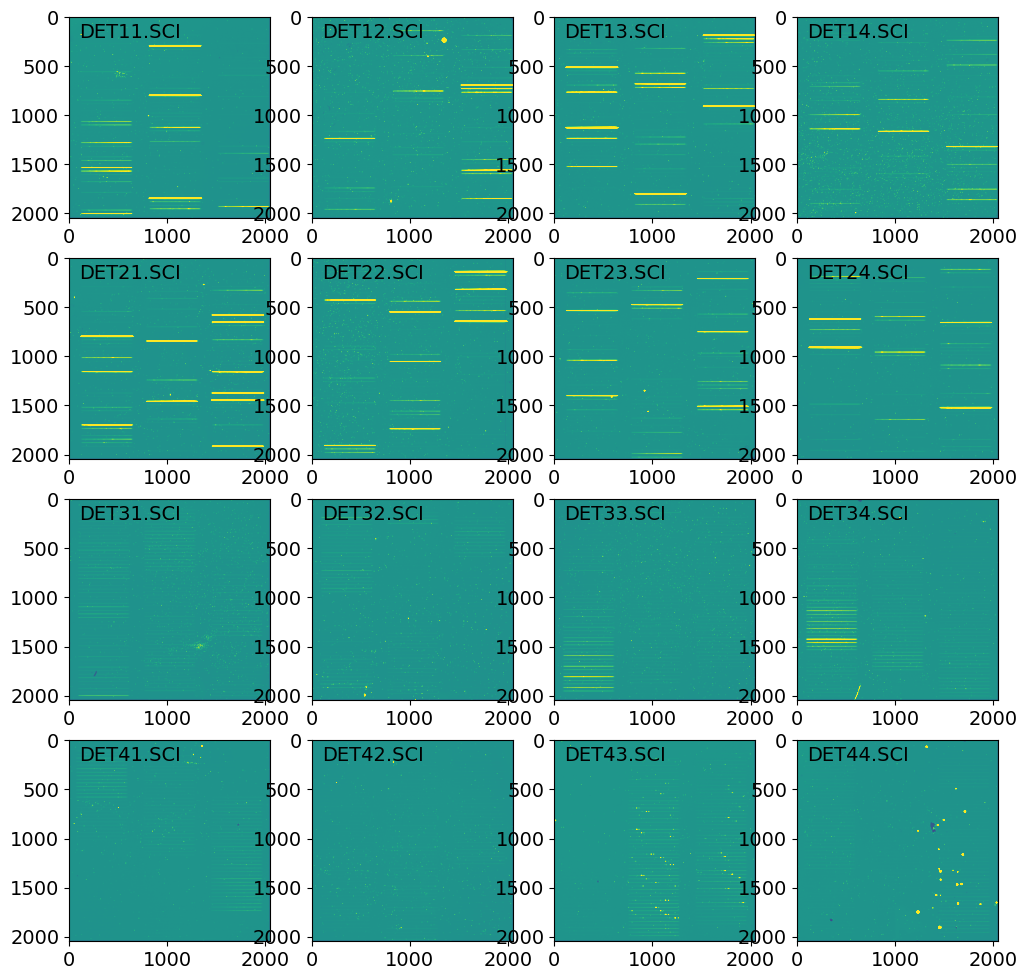

In [18]:
# Plot the slitless extensions
plot_slitless(slitless_files[0], verb=0)

In [19]:
## Read slitless headers and plot the image coordinates of the detectors relative to each other
heads = read_slitless_headers(slitless_files[0], verb=0, plot=0)
print(heads)

{'DET11.SCI': XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2048 / length of data axis 1                          
NAXIS2  =                 2048 / length of data axis 2                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
EXTNAME = 'DET11.SCI'                                                           
CRVAL1  =      228.39419187752                                                  
CRVAL2  =      6.5903912393221                                                  
CRPIX1  =     

## Read the source catalog

In [20]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

print(catalog_files)
primer = Table.read(catalog_files[0]) 
print(primer.colnames)
print(len(primer))

['CATALOG_WP9_INTERMEDIATE_RUN_v2_NewCoord_mod.fits']
['SOURCE_ID', 'HALO_ID', 'KIND', 'RA', 'DEC', 'RA_MAG', 'DEC_MAG', 'Z_OBS', 'REF_MAG_ABS', 'REF_MAG', 'BULGE_FRACTION', 'BULGE_R50', 'DISK_R50', 'BULGE_NSERSIC', 'BULGE_AXIS_RATIO', 'INCLINATION_ANGLE', 'DISK_ANGLE', 'KAPPA', 'GAMMA1', 'GAMMA2', 'SED_TEMPLATE', 'EXT_LAW', 'EBV', 'HALPHA_LOGFLAM_EXT_MAG', 'HBETA_LOGFLAM_EXT_MAG', 'O2_LOGFLAM_EXT_MAG', 'O3_LOGFLAM_EXT_MAG', 'N2_LOGFLAM_EXT_MAG', 'S2_LOGFLAM_EXT_MAG', 'AV', 'TU_FNU_VIS_MAG', 'TU_FNU_Y_NISP_MAG', 'TU_FNU_J_NISP_MAG', 'TU_FNU_H_NISP_MAG', 'TU_FNU_G_DECAM_MAG', 'TU_FNU_R_DECAM_MAG', 'TU_FNU_I_DECAM_MAG', 'TU_FNU_Z_DECAM_MAG', 'TU_FNU_U_MEGACAM_MAG', 'TU_FNU_R_MEGACAM_MAG', 'TU_FNU_G_JPCAM_MAG', 'TU_FNU_I_PANSTARRS_MAG', 'TU_FNU_Z_PANSTARRS_MAG', 'TU_FNU_Z_HSC_MAG', 'TU_FNU_G_GAIA_MAG', 'TU_FNU_BP_GAIA_MAG', 'TU_FNU_RP_GAIA_MAG', 'TU_FNU_U_LSST_MAG', 'TU_FNU_G_LSST_MAG', 'TU_FNU_R_LSST_MAG', 'TU_FNU_I_LSST_MAG', 'TU_FNU_Z_LSST_MAG', 'TU_FNU_Y_LSST_MAG', 'TU_FNU_U_KIDS_MAG'

In [21]:
print([col for col in primer.colnames if "TU_" in col])
Euclid_bands = ['VIS','NIR_Y','NIR_J','NIR_H']
Euclid_bands_flux = ['TU_FNU_VIS_MAG', 'TU_FNU_Y_NISP_MAG', 'TU_FNU_J_NISP_MAG', 'TU_FNU_H_NISP_MAG'] 

['TU_FNU_VIS_MAG', 'TU_FNU_Y_NISP_MAG', 'TU_FNU_J_NISP_MAG', 'TU_FNU_H_NISP_MAG', 'TU_FNU_G_DECAM_MAG', 'TU_FNU_R_DECAM_MAG', 'TU_FNU_I_DECAM_MAG', 'TU_FNU_Z_DECAM_MAG', 'TU_FNU_U_MEGACAM_MAG', 'TU_FNU_R_MEGACAM_MAG', 'TU_FNU_G_JPCAM_MAG', 'TU_FNU_I_PANSTARRS_MAG', 'TU_FNU_Z_PANSTARRS_MAG', 'TU_FNU_Z_HSC_MAG', 'TU_FNU_G_GAIA_MAG', 'TU_FNU_BP_GAIA_MAG', 'TU_FNU_RP_GAIA_MAG', 'TU_FNU_U_LSST_MAG', 'TU_FNU_G_LSST_MAG', 'TU_FNU_R_LSST_MAG', 'TU_FNU_I_LSST_MAG', 'TU_FNU_Z_LSST_MAG', 'TU_FNU_Y_LSST_MAG', 'TU_FNU_U_KIDS_MAG', 'TU_FNU_G_KIDS_MAG', 'TU_FNU_R_KIDS_MAG', 'TU_FNU_I_KIDS_MAG', 'TU_FNU_J_2MASS_MAG', 'TU_FNU_H_2MASS_MAG', 'TU_FNU_KS_2MASS_MAG']


In [22]:
primer[:10].show_in_notebook()

idx,SOURCE_ID,HALO_ID,KIND,RA,DEC,RA_MAG,DEC_MAG,Z_OBS,REF_MAG_ABS,REF_MAG,BULGE_FRACTION,BULGE_R50,DISK_R50,BULGE_NSERSIC,BULGE_AXIS_RATIO,INCLINATION_ANGLE,DISK_ANGLE,KAPPA,GAMMA1,GAMMA2,SED_TEMPLATE,EXT_LAW,EBV,HALPHA_LOGFLAM_EXT_MAG,HBETA_LOGFLAM_EXT_MAG,O2_LOGFLAM_EXT_MAG,O3_LOGFLAM_EXT_MAG,N2_LOGFLAM_EXT_MAG,S2_LOGFLAM_EXT_MAG,AV,TU_FNU_VIS_MAG,TU_FNU_Y_NISP_MAG,TU_FNU_J_NISP_MAG,TU_FNU_H_NISP_MAG,TU_FNU_G_DECAM_MAG,TU_FNU_R_DECAM_MAG,TU_FNU_I_DECAM_MAG,TU_FNU_Z_DECAM_MAG,TU_FNU_U_MEGACAM_MAG,TU_FNU_R_MEGACAM_MAG,TU_FNU_G_JPCAM_MAG,TU_FNU_I_PANSTARRS_MAG,TU_FNU_Z_PANSTARRS_MAG,TU_FNU_Z_HSC_MAG,TU_FNU_G_GAIA_MAG,TU_FNU_BP_GAIA_MAG,TU_FNU_RP_GAIA_MAG,TU_FNU_U_LSST_MAG,TU_FNU_G_LSST_MAG,TU_FNU_R_LSST_MAG,TU_FNU_I_LSST_MAG,TU_FNU_Z_LSST_MAG,TU_FNU_Y_LSST_MAG,TU_FNU_U_KIDS_MAG,TU_FNU_G_KIDS_MAG,TU_FNU_R_KIDS_MAG,TU_FNU_I_KIDS_MAG,TU_FNU_J_2MASS_MAG,TU_FNU_H_2MASS_MAG,TU_FNU_KS_2MASS_MAG,VIS,NIR_Y,NIR_J,NIR_H,SED_INDEX,SPECTRA_HDU,MASS_LOG,SFR_LOG,SIGMA_LOG,SIII_9069_LOGFLAM_EXT,SIII_9532_LOGFLAM_EXT,PaschenBETA_LOGFLAM_EXT,PaschenGAMMA_LOGFLAM_EXT,Paschen7_LOGFLAM_EXT,Paschen8_LOGFLAM_EXT,Paschen9_LOGFLAM_EXT,Paschen10_LOGFLAM_EXT,Balmer_GAMMA_LOGFLAM_EXT,Balmer_DELTA_LOGFLAM_EXT,Balmer_EPSILON_LOGFLAM_EXT,Lbol_AGN,Ldisk_AGN,logU,metallicity,alpha,FWHM,HALPHA_LOGFLAM_AGN_EXT,HBETA_LOGFLAM_AGN_EXT,O2_LOGFLAM_AGN_EXT,O3_LOGFLAM_AGN_EXT,N2_LOGFLAM_AGN_EXT,S2_LOGFLAM_AGN_EXT,SIII_9069_LOGFLAM_AGN_EXT,SIII_9532_LOGFLAM_AGN_EXT,PaschenBETA_FLAM_AGN_EXT,PaschenGAMMA_FLAM_AGN_EXT,Paschen7_FLAM_AGN_EXT,Paschen8_FLAM_AGN_EXT,Paschen9_FLAM_AGN_EXT
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1191,0,1,228.74652,6.244,228.74652,6.244,0.1,-99.0,-99.0,1.0,0.25,0.25,1,1,0,0.0,0.0001,0.0001,0.0001,1.0,-99.0,0.5,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,2.560469383868375e-06,6.043357125747614e-06,1.1065422134118237e-05,2.124431167400817e-05,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.87920103189823,21.946804352059324,21.290080033867067,20.58189333924539,0,2,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,42.6,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0
1,1822,0,1,228.74652,6.247,228.74652,6.247,0.2,-99.0,-99.0,1.0,0.25,0.25,1,1,0,0.0,0.0001,0.0001,0.0001,1.0,-99.0,0.25,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,2.3678139753534368e-06,4.190686633839127e-06,6.6663631344253864e-06,1.1859532869635476e-05,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.964131051168174,22.34428703276546,21.840277582156133,21.21483104221333,1,2,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,43.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0
2,2806,0,1,228.74652,6.25,228.74652,6.25,0.6,-99.0,-99.0,1.0,0.25,0.25,1,1,0,0.0,0.0001,0.0001,0.0001,1.0,-99.0,0.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.2405649632756416e-06,2.099637587271171e-06,2.3382084431336903e-06,3.282033915403543e-06,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.665951221459235,23.094639152964227,22.977791939022264,22.609642338526854,2,2,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,43.6,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0
3,3011,0,1,228.74652,6.253,228.74652,6.253,0.1,-99.0,-99.0,1.0,0.25,0.25,1,1,0,0.0,0.0001,0.0001,0.0001,1.0,-99.0,0.75,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.4898965830535686e-05,4.3777215482665326e-05,9.258969966782651e-05,0.00019338173160169024,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-9

In [23]:
primer[Euclid_bands][:10].show_in_notebook()

idx,VIS,NIR_Y,NIR_J,NIR_H
0,22.87920103189823,21.946804352059324,21.290080033867067,20.58189333924539
1,22.964131051168174,22.34428703276546,21.840277582156133,21.21483104221333
2,23.665951221459235,23.094639152964227,22.977791939022264,22.609642338526854
3,20.967109689653714,19.796879664650465,18.983593311541398,18.18396138818833
4,24.54541239600374,23.293064239480337,22.335353845173614,21.28612547653905
5,25.512887036978707,24.17330165283523,23.271649671262672,22.21933055556761
6,22.840784819520053,22.15957638744755,21.71128555192082,21.17227216545946
7,23.01188723805794,22.189283037169112,21.896121217548476,21.326601779533178
8,23.553351189279216,22.672226162990697,22.427581480427598,21.880654286113398
9,25.251711028755764,23.82423181861356,23.320011774347083,22.412133284066034


In [24]:
primer[Euclid_bands_flux][:10].show_in_notebook()

idx,TU_FNU_VIS_MAG,TU_FNU_Y_NISP_MAG,TU_FNU_J_NISP_MAG,TU_FNU_H_NISP_MAG
,Jy,Jy,Jy,Jy
0,2.560469383868375e-06,6.043357125747614e-06,1.1065422134118237e-05,2.124431167400817e-05
1,2.3678139753534368e-06,4.190686633839127e-06,6.6663631344253864e-06,1.1859532869635476e-05
2,1.2405649632756416e-06,2.099637587271171e-06,2.3382084431336903e-06,3.282033915403543e-06
3,1.4898965830535686e-05,4.3777215482665326e-05,9.258969966782651e-05,0.00019338173160169024
4,5.518677831089382e-07,1.7489375579573614e-06,4.2253088755053984e-06,1.1105799008227512e-05
5,2.2638371641263906e-07,7.774623001296257e-07,1.7837752406736063e-06,4.701839257741701e-06
6,2.6526873856706776e-06,4.967861104968473e-06,7.507334713034171e-06,1.2333636192499046e-05
7,2.2659227760640147e-06,4.833778938970656e-06,6.332154648560086e-06,1.0699396653061998e-05
8,1.3761301951837212e-06,3.0982006077930456e-06,3.881212378553296e-06,6.423005376586535e-06


## Plot the magnitude histogram of sources

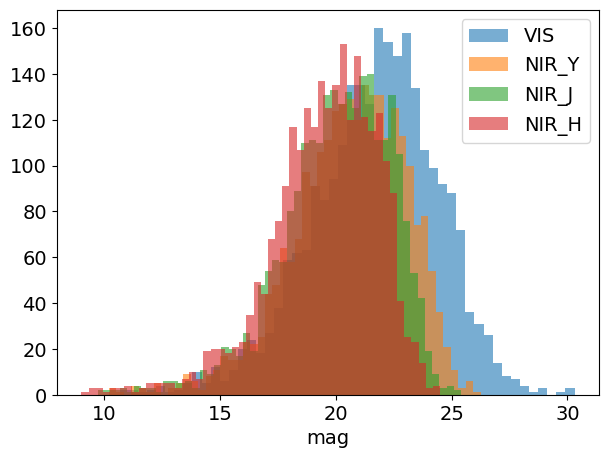

In [25]:
primer['TU_FNU_VIS_MAG'] # Jy
primer['TU_FNU_Y_NISP_MAG'] # Jy
primer['TU_FNU_J_NISP_MAG'] # Jy
primer['TU_FNU_H_NISP_MAG'] # Jy
primer['VIS'] # mag
primer['NIR_Y'] # mag
primer['NIR_J'] # mag
primer['NIR_H'] # mag

fig = plt.figure(figsize=(7,5))

p1 = fig.add_subplot(111)
p1.hist(primer['VIS'], bins=50, alpha=0.6, label="VIS")
p1.hist(primer['NIR_Y'], bins=50, alpha=0.6, label="NIR_Y")
p1.hist(primer['NIR_J'], bins=50, alpha=0.6, label="NIR_J")
p1.hist(primer['NIR_H'], bins=50, alpha=0.6, label="NIR_H")
p1.set_xlabel("mag")
p1.legend()
plt.show()

## Plot the RA and Dec distribution across the detectors

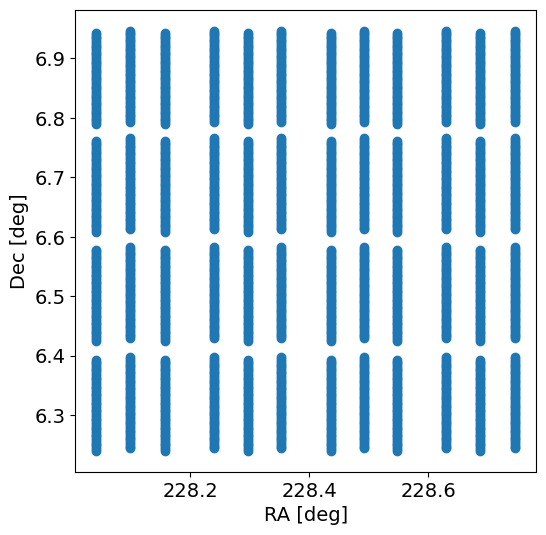

In [26]:
fig = plt.figure()

p1 = fig.add_subplot(111)
p1.scatter(primer['RA'],primer['DEC'])
p1.set_aspect(1.)
p1.set_xlabel("RA [deg]")
p1.set_ylabel("Dec [deg]")

plt.show()

In [27]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep', 'Input_Thumbnails'))
direct_thumbnail_files = glob.glob('NIS_catalog_file_??.thm.beamA.fits')
direct_thumbnail_files.sort()
print(direct_thumbnail_files)
print(len(direct_thumbnail_files))

['NIS_catalog_file_11.thm.beamA.fits', 'NIS_catalog_file_12.thm.beamA.fits', 'NIS_catalog_file_13.thm.beamA.fits', 'NIS_catalog_file_14.thm.beamA.fits', 'NIS_catalog_file_21.thm.beamA.fits', 'NIS_catalog_file_22.thm.beamA.fits', 'NIS_catalog_file_23.thm.beamA.fits', 'NIS_catalog_file_24.thm.beamA.fits', 'NIS_catalog_file_31.thm.beamA.fits', 'NIS_catalog_file_32.thm.beamA.fits', 'NIS_catalog_file_33.thm.beamA.fits', 'NIS_catalog_file_34.thm.beamA.fits', 'NIS_catalog_file_41.thm.beamA.fits', 'NIS_catalog_file_42.thm.beamA.fits', 'NIS_catalog_file_43.thm.beamA.fits', 'NIS_catalog_file_44.thm.beamA.fits']
16


In [28]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep', 'Input_Thumbnails'))
## Map the sources the sources from the catalog to the detectors 
#det_tbl, det_dict = map_src_to_det(plot=0)
det_dict = map_src_to_det(plot=0)

1 1
[1191, 1822, 2806, 3011, 3083, 3084, 3224, 3575, 3576, 3716, 3785, 3851, 3924, 3994, 4211, 4213, 4342, 4344, 4485, 4831, 4903, 4906, 5113, 5116, 5325, 5391, 5461, 5471, 5612, 5680, 5688, 5741, 5812, 5818, 5825, 5882, 5952, 5957, 6021, 6091, 6093, 6095, 6162, 6168, 6173, 6304, 6314, 6325, 6344, 6395, 6442, 6511, 16825, 16830, 16881, 16913, 16958, 17151, 17159, 17173, 17174, 17176, 17193, 17198, 17218, 17220, 17233, 17261, 17310, 17366, 17376, 17501, 17586, 17587, 17589, 17590, 17649, 17650, 17652, 17654, 17713, 17716, 17726, 17802, 17858, 17873, 17882, 17887, 17896, 17903, 17905, 17910, 17943, 17946, 17949, 17959, 17961, 17980, 18013, 18142, 18201, 18209, 18215, 18276, 31014, 31082, 31225, 31361, 31574, 31645, 31924, 32412, 32553, 32555, 32692, 32693, 33252, 33333, 33536, 33614, 33815, 33824, 33954, 33960, 33973, 33975, 34100, 34164, 34378, 34386, 34516, 34595, 34665, 34688, 34733, 34746, 34794, 34809, 34932, 34943, 34947, 35012, 35051, 35085, 35157, 35356, 35357, 35371, 35375, 3538

[6344, 6395, 6442, 6511, 6662, 6676, 6695, 6696, 6741, 6800, 6873, 7013, 7026, 7053, 7064, 7093, 7158, 7165, 7219, 7288, 7360, 7372, 7375, 7393, 7400, 7460, 7497, 7507, 7513, 7572, 7583, 7634, 7646, 7703, 7708, 7717, 7734, 7746, 7755, 7765, 7769, 7806, 7811, 7813, 7852, 7864, 7867, 7914, 7916, 7931, 8063, 8094, 8119, 8125, 8153, 8175, 18215, 18276, 18277, 18297, 18332, 18333, 18340, 18380, 18432, 18486, 18490, 18496, 18497, 18505, 18582, 18587, 18615, 18617, 18673, 18765, 18774, 18838, 18840, 18857, 19041, 19602, 19952, 21354, 21424, 21491, 21632, 21701, 21705, 21984, 22054, 22401, 22545, 22751, 22754, 23106, 23112, 23180, 23465, 23809, 23817, 23950, 24012, 24165, 24227, 24233, 24302, 24305, 24436, 24587, 35456, 35492, 35498, 35514, 35563, 35566, 35570, 35766, 35775, 35790, 35812, 35848, 35859, 35915, 35927, 35934, 35985, 35991, 36051, 36052, 36053, 36063, 36096, 36115, 36158, 36163, 36164, 36172, 36272, 36338, 36412, 36431, 36434, 36459, 36478, 36487, 36501, 36554, 36560, 36614, 36617

[12743, 12745, 12813, 13305, 13310, 13371, 13441, 13581, 13584, 13660, 13725, 13732, 13796, 13936, 14006, 14010, 14084, 14142, 14146, 14281, 14491, 14497, 14563, 14703, 14842, 15058, 15062, 15136, 15331, 15408, 15474, 15482, 15541, 15545, 15555, 15759, 15900, 15906, 16121, 16142, 16184, 16261, 16262, 16384, 16460, 16462, 16473, 16499, 16515, 16525, 16535, 16544, 16670, 16805, 16810, 16812, 16816, 26956, 26968, 26983, 27002, 27010, 27012, 27016, 27029, 27061, 27063, 27071, 27173, 27319, 27346, 27370, 27377, 27388, 27404, 27456, 27522, 27525, 27536, 27607, 27657, 27667, 27680, 27682, 27693, 27699, 27711, 27713, 27715, 27724, 27738, 27743, 27752, 27831, 27877, 27878, 28083, 28093, 28118, 28161, 28166, 28219, 28222, 28226, 28228, 28911, 29402, 29541, 30733, 30803, 30942, 30943, 42281, 42422, 42435, 42562, 42564, 42782, 42843, 43191, 43193, 43837, 43906, 44032, 44036, 44044, 44102, 44138, 44145, 44245, 44247, 44319, 44387, 44389, 44391, 44525, 44531, 44539, 44605, 44614, 44733, 44736, 44822

[46926, 46970, 46987, 47007, 47016, 47069, 47075, 47087, 47127, 47137, 47183, 47188, 48722, 48792, 49141, 49632, 49705, 49774, 49914, 49982, 50053, 50404, 51034, 51171, 51241, 51243, 51523, 51592, 51600, 51735, 51803, 51806, 51941, 52152, 52158, 52294, 52433, 52644, 52653, 52712, 52720, 52722, 52927, 52935, 53073, 53136, 53142, 53208, 53224, 53287, 53352, 53551, 53552, 53692, 64114, 64117, 64129, 64142, 64146, 64163, 64413, 64423, 64435, 64467, 64481, 64543, 64553, 64627, 64681, 64692, 64763, 64791, 64795, 64834, 64847, 64870, 64872, 64908, 64915, 64929, 64965, 64976, 65032, 65129, 65141, 65149, 65167, 65186, 65191, 65193, 65209, 65211, 65230, 65245, 65263, 65277, 65315, 65385, 65388, 65396, 65406, 65454, 65472, 65495, 65514, 65542, 65543, 65551, 65557, 65570, 75042, 75090, 75111, 75115, 75122, 75123, 75136, 75182, 75195, 75269, 75272, 75275, 75371, 75396, 75418, 75441, 75531, 75553, 75741, 76091, 77353, 77771, 78192, 78332, 78543, 78821, 79171, 79316, 79454, 79531, 79595, 79872, 80162

[55769, 55827, 55836, 55881, 55885, 55934, 56014, 56017, 56020, 56024, 56046, 56049, 56051, 56109, 56131, 56157, 56176, 56353, 56377, 56378, 56428, 56439, 56446, 56482, 56490, 56491, 56524, 56571, 56648, 57051, 58242, 58802, 58872, 59082, 59712, 59923, 60483, 60485, 60555, 60625, 60762, 61251, 61260, 61326, 61602, 61614, 61681, 61755, 62027, 62094, 62105, 62162, 62235, 62241, 62303, 71551, 71771, 71894, 72031, 72102, 72120, 72172, 72173, 72184, 72188, 72314, 72393, 72396, 72455, 72476, 72526, 72602, 72802, 72803, 72820, 72823, 72844, 72846, 72849, 72957, 72960, 73084, 73152, 73154, 73160, 73191, 73199, 73243, 73247, 73258, 73259, 73310, 73373, 73378, 73435, 73444, 73446, 73527, 73540, 73542, 73615, 73643, 73659, 73667, 73722, 73727, 73787, 73905, 73908, 73915, 73928, 73941, 83873, 83939, 83952, 84006, 84010, 84027, 84037, 84052, 84081, 84090, 84096, 84105, 84121, 84122, 84164, 84178, 84179, 84181, 84212, 84217, 84223, 84289, 84301, 84306, 84360, 84367, 84369, 84375, 84383, 84402, 84426

[199636, 199815, 199825, 200939, 201128, 201148, 201526, 232690, 234391, 235336, 235346, 235724, 235913, 236112, 236659, 237047, 237057, 237236, 237246, 237415, 237624, 237803, 238191, 238380, 238559, 238947, 268977, 269365, 269733, 269743, 270867, 271255, 271434, 271633, 272956, 273155, 273324, 273334, 274100, 274458, 274468, 274478, 274846, 275035, 275403, 275413, 275423, 275791, 276557, 277691, 278258, 278437, 278825, 309044, 310188, 310745, 238967, 239146, 239186, 239544, 239902, 240091, 270897, 272071, 272439, 272449, 272807, 272827, 273165, 273185, 273195, 273543, 273563, 273921, 273931, 273941, 274339, 275065, 275075, 275433, 275443, 275811, 276010, 276378, 276398, 276597, 276607, 277144, 277154, 277164, 277343, 277542, 277701, 277711, 277900, 278079, 278089, 278109, 278119, 278268, 278298, 278308, 278457, 278467, 278676, 278686, 278855, 278865, 279233, 279621, 577457, 577487, 577835, 577845, 577865, 578392, 578402, 578591, 578959, 579347, 579377, 579745, 579755, 579934, 580292,

[354234, 354791, 354990, 535092, 536614, 537748, 538504, 538882, 539260, 539628, 540016, 541339, 543418, 543607, 570991, 572881, 573637, 573657, 574035, 574393, 574960, 575338, 575348, 575527, 575726, 575905, 575925, 576094, 576303, 576661, 576671, 577984, 578173, 578362, 578571, 578740, 578949, 579118, 579327, 579516, 579685, 579874, 580083, 580272, 123491, 124247, 124267, 124804, 124993, 125371, 125381, 125391, 125401, 125789, 126535, 126724, 160902, 348385, 348395, 348763, 348773, 349141, 349907, 349917, 349927, 350305, 350315, 350653, 350663, 350693, 351041, 351051, 351071, 351409, 351787, 351797, 351986, 352165, 352175, 352185, 352205, 352354, 352364, 352384, 352732, 352921, 352961, 353140, 353150, 353299, 353319, 353329, 353339, 353508, 353876, 353886, 353896, 354075, 354085, 354463, 354821, 355000, 355010, 355199, 355388, 355408, 536246, 538912, 539280, 539300, 539668, 540056, 200263, 200267, 200459, 200460, 200641, 200835, 200837, 200838, 201213, 201216, 201397, 201401, 201402,

[275873, 276056, 276434, 276435, 276627, 276629, 276806, 276813, 276999, 277002, 277004, 277006, 277184, 277384, 277562, 277566, 277567, 277751, 277755, 277762, 277949, 278134, 278135, 278137, 278318, 278324, 278327, 278329, 278330, 278512, 278515, 278519, 278704, 278707, 278708, 278885, 278896, 278897, 279078, 279085, 279269, 279274, 279458, 279461, 279464, 279646, 279647, 279651, 279836, 279837, 279838, 279841, 279842, 312148, 541978, 542155, 542727, 542729, 542917, 543107, 543289, 543295, 543485, 543488, 543667, 543674, 543675, 543676, 543861, 543867, 544050, 544240, 544241, 544246, 544428, 544431, 544435, 544612, 544621, 544806, 544807, 544809, 544813, 544990, 544994, 544997, 545000, 545001, 545002, 545183, 545184, 545186, 545189, 545191, 545368, 545372, 545562, 545563, 545565, 545567, 545750, 545940, 545944, 545945, 545946, 545947, 546129, 546321, 546323, 546502, 278525, 278901, 278903, 278905, 279281, 279282, 279285, 279654, 279661, 279662, 318967, 318968, 319343, 319348, 319726,

[318578, 318579, 318586, 318774, 318775, 318956, 318958, 319141, 319145, 319146, 319153, 319335, 319523, 319524, 319525, 319527, 319530, 319531, 319716, 319718, 319719, 319904, 320093, 320096, 320279, 320284, 320471, 320472, 320475, 320476, 320659, 320660, 320854, 321041, 321043, 321418, 321799, 349947, 350331, 350703, 350711, 351081, 351090, 351459, 351469, 351845, 352026, 352219, 352220, 352224, 352601, 352603, 352976, 352978, 352983, 549725, 550103, 550104, 550105, 616060, 616437, 617192, 617193, 617194, 617195, 617196, 617197, 617572, 617948, 617951, 652339, 652346, 653103, 653473, 653477, 653479, 653484, 653851, 653856, 653857, 654238, 654616, 654617, 654619, 654992, 654994, 654997, 655178, 655363, 655370, 655374, 655557, 655741, 655745, 655747, 655751, 655753, 655935, 690142, 690516, 690894, 690899, 691280, 691656, 692034, 692037, 692038, 692222, 692406, 692410, 692412, 692413, 278531, 278538, 278908, 279286, 279289, 321626, 321627, 321999, 322001, 322382, 322385, 322758, 322759,

## Print each of the detectors WCS header information

In [29]:
from astropy import wcs

os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
wcs_temp = "Euclid_DET%s_wcs.fits"

for i in range(0,4): 
    for j in range(0,4):
        print(i+1,j+1)
        num = '%i%i' % (i+1,j+1)
        hdu = pyfits.open(wcs_temp % (num), ignore_missing_simple=True)    
        head = hdu[0].header
        #print(head)
        print(head['CRVAL1'],head['CRVAL2'],head['CRPIX1'],head['CRPIX2'])

1 1
228.39419187752 6.5903912393221 4578.75045083333 4331.37522541667
1 2
228.39419187752 6.5903912393221 4578.75045083333 2126.45840847222
1 3
228.39419187752 6.5903912393221 4578.75045083333 -78.4584084722222
1 4
228.39419187752 6.5903912393221 4578.75045083333 -2283.37522541667
2 1
228.39419187752 6.5903912393221 2208.91681694444 4331.37522541667
2 2
228.39419187752 6.5903912393221 2208.91681694444 2126.45840847222
2 3
228.39419187752 6.5903912393221 2208.91681694444 -78.4584084722222
2 4
228.39419187752 6.5903912393221 2208.91681694444 -2283.37522541667
3 1
228.39419187752 6.5903912393221 -160.916816944444 4331.37522541667
3 2
228.39419187752 6.5903912393221 -160.916816944444 2126.45840847222
3 3
228.39419187752 6.5903912393221 -160.916816944444 -78.4584084722222
3 4
228.39419187752 6.5903912393221 -160.916816944444 -2283.37522541667
4 1
228.39419187752 6.5903912393221 -2530.75045083333 4331.37522541667
4 2
228.39419187752 6.5903912393221 -2530.75045083333 2126.45840847222
4 3
228.

## Write direct images

In [30]:
primer["TU_FNU_H_NISP_MAG","NIR_H"][:10].show_in_notebook()

idx,TU_FNU_H_NISP_MAG,NIR_H
,Jy,
0,2.124431167400817e-05,20.58189333924539
1,1.1859532869635476e-05,21.21483104221333
2,3.282033915403543e-06,22.609642338526854
3,0.00019338173160169024,18.18396138818833
4,1.1105799008227512e-05,21.28612547653905
5,4.701839257741701e-06,22.21933055556761
6,1.2333636192499046e-05,21.17227216545946
7,1.0699396653061998e-05,21.326601779533178
8,6.423005376586535e-06,21.880654286113398


In [31]:
#    # effective wavelength (pivot wavelength)
#    # http://www.astro.ljmu.ac.uk/~ikb/research/mags-fluxes/
#    numerator = integrate.trapz(tran,wav)
#    denominator = integrate.trapz(tran/wav**2,wav)
#    effwav_sq = numerator/denominator
#    effwav = np.sqrt(effwav_sq)

from scipy import integrate

def calc_pivot(wav,tran):
    
    numerator = integrate.trapz(tran * wav, wav)
    denominator = integrate.trapz(tran / wav, wav)    
    pivot = np.sqrt(numerator/denominator)
    
    return pivot

## Create direct images

1 1
NIS_catalog_file_11.thm.beamA.fits
157
0
1191
(22, 22)
38.25231353612779
38.24491
349 371
149 171

1
1822
(22, 22)
23.045104802415548
23.040646
349 371
185 207

2
2806
(22, 22)
8.083006811262372
8.081443
349 371
221 243

3
3011
(22, 22)
320.0754728542345
320.01355
349 371
257 279

4
3083
(22, 22)
14.606567913434203
14.603743
349 371
294 316

5
3084
(22, 22)
6.166373858783282
6.165181
349 371
330 352

6
3224
(22, 22)
25.952278890309394
25.947258
349 371
366 388

7
3575
(22, 22)
21.889771762898143
21.885538
349 371
402 424

8
3576
(22, 22)
13.417052779844232
13.414457
349 371
438 460

9
3716
(22, 22)
5.897731685352403
5.8965907
349 371
474 496

10
3785
(22, 22)
7.160266602339099
7.158881
349 371
510 532

11
3851
(22, 22)
2189.726649838249
2189.3032
349 371
547 569

12
3924
(22, 22)
65.18917721132155
65.17657
349 371
583 605

13
3994
(22, 22)
46.93416802518122
46.92509
349 371
619 641

14
4211
(22, 22)
12.931833487360317
12.929331
349 371
655 677

15
4213
(22, 22)
8.567051549352767
8.

1 2
NIS_catalog_file_12.thm.beamA.fits
167
4
6662
(22, 22)
263.85101710893355
263.79996
350 372
177 199

5
6676
(22, 22)
36.12238489871001
36.115395
350 372
213 235

6
6695
(22, 22)
12.821260309750004
12.818781
350 372
249 271

7
6696
(22, 22)
12.120111476828614
12.117767
350 372
285 307

8
6741
(22, 22)
26.492863172210402
26.48774
350 372
321 343

9
6800
(22, 22)
141.01720720355553
140.98993
350 372
358 380

10
6873
(22, 22)
37.8095082275917
37.802193
350 372
394 416

11
7013
(22, 22)
341.06046522989516
340.99448
350 372
430 452

12
7026
(22, 22)
57.25012192142599
57.239044
350 372
466 488

13
7053
(22, 22)
14.347802601077097
14.345028
350 372
502 524

14
7064
(22, 22)
10.250434895226933
10.248452
350 372
538 560

15
7093
(22, 22)
30.532689250821534
30.526783
351 373
574 596

16
7158
(22, 22)
33.71560040749431
33.709076
351 373
611 633

17
7165
(22, 22)
9.08084656567439
9.079089
351 373
647 669

18
7219
(22, 22)
181.95982993327112
181.92462
351 373
683 705

19
7288
(22, 22)
162.690970

140
36412
(22, 22)
1633.6872914538208
1633.3713
1748 1770
1116 1138

141
36431
(22, 22)
175.284340880288
175.25043
1748 1770
1152 1174

142
36434
(22, 22)
152.3043583932579
152.27487
1748 1770
1188 1210

143
36459
(22, 22)
48.298085884893815
48.288742
1748 1770
1224 1246

144
36478
(22, 22)
2602.4638540609026
2601.9604
1748 1770
1260 1282

145
36487
(22, 22)
326.9544981755882
326.89124
1748 1770
1296 1318

146
36501
(22, 22)
56.63662169195734
56.625664
1748 1770
1332 1354

147
36554
(22, 22)
317.52373246322844
317.4623
1748 1770
1368 1390

148
36560
(22, 22)
92.96901344734039
92.951035
1748 1770
1405 1427

149
36614
(22, 22)
7952.251421605117
7950.7134
1748 1770
1441 1463

150
36617
(22, 22)
1383.8599842761362
1383.5923
1748 1770
1477 1499

151
36633
(22, 22)
21.639602389584596
21.635416
1748 1770
1513 1535

152
36682
(22, 22)
43754.16547994385
43745.7
1748 1770
1549 1571

153
36756
(22, 22)
11966.096564265908
11963.781
1748 1770
1585 1607

154
36777
(22, 22)
354.533082272067
354.4645


1 4
NIS_catalog_file_14.thm.beamA.fits
170
5
13371
(22, 22)
1872.1918042649347
1871.8296
353 375
153 175

6
13441
(22, 22)
1563.0851566926137
1562.7827
353 375
189 211

7
13581
(22, 22)
1096.7272974272473
1096.5151
353 375
226 248

8
13584
(22, 22)
25.19733951594872
25.192465
353 375
262 284

9
13660
(22, 22)
16.444632291710498
16.44145
353 375
298 320

10
13725
(22, 22)
56.437254841334884
56.426334
353 375
334 356

11
13732
(22, 22)
6.071289651419742
6.070115
353 375
370 392

12
13796
(22, 22)
22.909735457250733
22.9053
353 375
406 428

13
13936
(22, 22)
10.114545201253415
10.112589
354 376
442 464

14
14006
(22, 22)
82.96548095869981
82.94943
354 376
479 501

15
14010
(22, 22)
26.06298577165834
26.057945
354 376
515 537

16
14084
(22, 22)
5.954152552786118
5.953001
354 376
551 573

17
14142
(22, 22)
750.1140547974754
749.9689
354 376
587 609

18
14146
(22, 22)
36.30948376728191
36.30246
354 376
623 645

19
14281
(22, 22)
2754.8544174736994
2754.3215
354 376
659 681

20
14491
(22, 22)

2 1
NIS_catalog_file_21.thm.beamA.fits
157
0
45645
(22, 22)
3668.873950158832
3668.164
353 375
100 122

1
45660
(22, 22)
57.98543188064939
57.974213
353 375
136 158

2
45737
(22, 22)
6.581779302149362
6.5805063
353 375
172 194

3
45790
(22, 22)
196.14880406330337
196.11086
353 375
208 230

4
45791
(22, 22)
146.2520760409184
146.22379
353 375
244 266

5
45867
(22, 22)
646.9265899248969
646.8014
353 375
280 302

6
45907
(22, 22)
51.18565522005235
51.17575
353 375
317 339

7
45941
(22, 22)
172.87117232139923
172.83772
353 375
353 375

8
45950
(22, 22)
60.98275887579162
60.970963
353 375
389 411

9
45957
(22, 22)
35.15577721017828
35.148975
353 375
425 447

10
45964
(22, 22)
19.409131364105193
19.405376
353 375
461 483

11
45974
(22, 22)
8.392304910867455
8.390682
353 375
497 519

12
45997
(22, 22)
2239.6891051759962
2239.2559
353 375
533 555

13
46002
(22, 22)
539.4547374225746
539.35034
353 375
569 591

14
46014
(22, 22)
44.10564093027582
44.097107
353 375
606 628

15
46071
(22, 22)
398.

2 2
NIS_catalog_file_22.thm.beamA.fits
165
2
46987
(22, 22)
1292.1195549868214
1291.8696
354 376
128 150

3
47007
(22, 22)
139.95766993753472
139.9306
354 376
164 186

4
47016
(22, 22)
64.3591454841558
64.346695
354 376
200 222

5
47069
(22, 22)
90.30122471428426
90.28375
354 376
236 258

6
47075
(22, 22)
48.80030077762403
48.790863
354 376
272 294

7
47087
(22, 22)
11.482316858982546
11.480095
354 376
308 330

8
47127
(22, 22)
330.9114219544152
330.8474
354 376
344 366

9
47137
(22, 22)
41.52821990438968
41.520187
354 376
381 403

10
47183
(22, 22)
56456.562222928376
56445.64
354 376
417 439

11
47188
(22, 22)
2553.9769878008146
2553.483
354 376
453 475

12
48722
(22, 22)
15.38278932222478
15.379814
354 376
489 511

13
48792
(22, 22)
12.253464927061925
12.251094
354 376
525 547

14
49141
(22, 22)
101.65161846294525
101.63196
354 376
561 583

15
49632
(22, 22)
19.72872164839892
19.724907
354 376
597 619

16
49705
(22, 22)
8.485572304777008
8.483931
354 376
633 655

17
49774
(22, 22)
10

2 3
NIS_catalog_file_23.thm.beamA.fits
170
3
53704
(22, 22)
33.252177766244465
33.245743
354 376
127 149

4
53841
(22, 22)
24.597925445436424
24.593166
354 376
163 185

5
53915
(22, 22)
141.40854611178244
141.38116
354 376
199 221

6
53945
(22, 22)
12.485231692733109
12.482815
354 376
235 257

7
53990
(22, 22)
30.80342112546246
30.797462
355 377
271 293

8
54048
(22, 22)
283.4315546400327
283.3767
355 377
307 329

9
54254
(22, 22)
6062.345516061057
6061.173
355 377
343 365

10
54266
(22, 22)
189.9800431803911
189.9433
355 377
380 402

11
54313
(22, 22)
10.101754872354356
10.0998
355 377
416 438

12
54344
(22, 22)
26.331987462030177
26.326893
355 377
452 474

13
54345
(22, 22)
23.26485026136166
23.26035
355 377
488 510

14
54391
(22, 22)
101651.6184629552
101631.95
355 377
524 546

15
54467
(22, 22)
393.808390973779
393.73218
355 377
560 582

16
54470
(22, 22)
140.67233083365142
140.64511
355 377
596 618

17
54471
(22, 22)
106.24785377053476
106.227295
355 377
632 654

18
54617
(22, 22)

2 4
NIS_catalog_file_24.thm.beamA.fits
168
3
55881
(22, 22)
52.77093457734776
52.760727
355 377
104 126

4
55885
(22, 22)
21.950815561895602
21.946568
355 377
140 162

5
55934
(22, 22)
10339.178742436417
10337.178
355 377
176 198

6
56014
(22, 22)
2794.1797902506178
2793.6392
355 377
212 234

7
56017
(22, 22)
1624.1615579891427
1623.8473
355 377
248 270

8
56020
(22, 22)
1069.554247506471
1069.3473
355 377
285 307

9
56024
(22, 22)
668.6415758133077
668.51227
355 377
321 343

10
56046
(22, 22)
185.93623492423785
185.90027
355 377
357 379

11
56049
(22, 22)
157.20898671932193
157.17856
355 377
393 415

12
56051
(22, 22)
146.0339627683846
146.0057
355 377
429 451

13
56109
(22, 22)
69.42867161355538
69.41524
355 377
465 487

14
56131
(22, 22)
12.003058103942237
12.000736
355 377
501 523

15
56157
(22, 22)
413.27539288637746
413.19543
355 377
537 559

16
56176
(22, 22)
25.569758116802216
25.564812
355 377
574 596

17
56353
(22, 22)
188358.05079635515
188321.6
355 377
610 632

18
56377
(22

3 1
NIS_catalog_file_31.thm.beamA.fits
157
0
120049
(22, 22)
769.0689454749349
768.92017
321 343
148 170

1
120427
(22, 22)
968.1460541604677
967.95874
321 343
184 206

2
121372
(22, 22)
1534.373272031169
1534.0764
321 343
220 242

3
121949
(22, 22)
805.7873071641357
805.6314
321 343
256 278

4
122138
(22, 22)
805.5994540912521
805.4436
321 343
292 314

5
122337
(22, 22)
469.48897224918124
469.3982
321 343
328 350

6
122516
(22, 22)
1014.146760511115
1013.95056
321 343
364 386

7
122715
(22, 22)
590.8988685821053
590.78455
321 343
401 423

8
122884
(22, 22)
3854.1902893249194
3853.4446
321 343
437 459

9
122894
(22, 22)
1276.800430071731
1276.5533
321 343
473 495

10
123073
(22, 22)
4852.217548339674
4851.2793
321 343
509 531

11
123471
(22, 22)
936.4474446947587
936.26624
321 343
545 567

12
123660
(22, 22)
936.1509242361773
935.96985
321 343
581 603

13
123849
(22, 22)
1179.0093242604764
1178.7811
321 343
617 639

14
124028
(22, 22)
2547.551780227607
2547.0588
321 343
654 676

15
124

3 2
NIS_catalog_file_32.thm.beamA.fits
167
0
199636
(22, 22)
152.8937437312309
152.86415
1676 1698
1910 1932

1
199815
(22, 22)
147.15585572710853
147.12738
1676 1698
1946 1968

2
199825
(22, 22)
192.01554218092014
191.97841
1676 1698
1982 2004

3
200939
(22, 22)
185.26942241367723
185.23358
1676 1698
2018 2040

8
234391
(22, 22)
10479.71291098046
10477.686
321 343
176 198

9
235336
(22, 22)
1607.6137601508544
1607.3027
321 343
212 234

10
235346
(22, 22)
2023.6595043380855
2023.268
321 343
248 270

11
235724
(22, 22)
258.68574244615905
258.63568
321 343
284 306

12
235913
(22, 22)
649.7332030334443
649.60754
321 343
320 342

13
236112
(22, 22)
1296.4664989432022
1296.2158
321 343
356 378

14
236659
(22, 22)
433.80954358800875
433.7256
321 343
392 414

15
237047
(22, 22)
546.1267570261143
546.0211
321 343
428 450

16
237057
(22, 22)
545.958910897194
545.8533
321 343
465 487

17
237236
(22, 22)
322.7802462692156
322.7178
321 343
501 523

18
237246
(22, 22)
2586.6291566591235
2586.1287
3

3 3
NIS_catalog_file_33.thm.beamA.fits
171
4
310745
(22, 22)
241.7376272017201
241.69086
1676 1698
175 197

5
311312
(22, 22)
143.75265451836907
143.72485
1676 1698
211 233

6
311322
(22, 22)
233.37391622463426
233.32877
1676 1698
247 269

7
311889
(22, 22)
181.14528061255132
181.11023
1676 1698
283 305

8
312446
(22, 22)
304.29752482848784
304.23865
1676 1698
319 341

9
313590
(22, 22)
383.1486381640441
383.07452
1676 1698
355 377

10
314346
(22, 22)
87.30478954179974
87.287895
1676 1698
392 414

11
314545
(22, 22)
435.6981065797419
435.61386
1676 1698
428 450

12
314734
(22, 22)
81.63670464535932
81.62091
1676 1698
464 486

13
314923
(22, 22)
72.02391028271369
72.00998
1676 1698
500 522

14
315102
(22, 22)
55.48847162447736
55.477737
1676 1698
536 558

15
315301
(22, 22)
102.64386808942338
102.62401
1676 1698
572 594

16
315480
(22, 22)
129.1064602008682
129.08148
1676 1698
608 630

17
315490
(22, 22)
162.40750289099884
162.37608
1675 1697
644 666

18
315669
(22, 22)
87.2652713337039

3 4
NIS_catalog_file_34.thm.beamA.fits
170
0
354234
(22, 22)
303.1070032798464
303.04834
321 343
1561 1583

1
354791
(22, 22)
480.0945593926526
480.0017
321 343
1597 1619

2
354990
(22, 22)
205.98116069934534
205.94131
321 343
1633 1655

3
535092
(22, 22)
1011.7162425122308
1011.5205
321 343
1669 1691

4
536614
(22, 22)
1274.3095037222547
1274.063
321 343
1705 1727

5
537748
(22, 22)
1604.5566337604175
1604.2462
321 343
1742 1764

6
538504
(22, 22)
958.21501071065
958.0296
320 342
1778 1800

7
538882
(22, 22)
611.576338340412
611.458
320 342
1814 1836

8
539260
(22, 22)
410.9330946087776
410.85364
320 342
1850 1872

9
539628
(22, 22)
373.4285783527688
373.35635
320 342
1886 1908

10
540016
(22, 22)
820.2718107384351
820.1131
320 342
1922 1944

11
541339
(22, 22)
819.9489589282416
819.79034
320 342
1958 1980

12
543418
(22, 22)
430.86665402971806
430.78333
320 342
1994 2016

18
574035
(22, 22)
63.68144496387163
63.669125
1675 1697
152 174

19
574393
(22, 22)
39.49780807547087
39.490166


4 1
NIS_catalog_file_41.thm.beamA.fits
157
0
205376
(22, 22)
73.43579931070582
73.42159
1675 1697
571 593

1
205378
(22, 22)
300.49245998329457
300.43433
302 324
100 122

2
205749
(22, 22)
198.7304240397223
198.69197
302 324
136 158

3
205754
(22, 22)
76.16882362435462
76.1541
1675 1697
607 629

4
205756
(22, 22)
1271.022434026879
1270.7766
301 323
172 194

5
205939
(22, 22)
378.36208590506567
378.28888
301 323
209 231

6
205941
(22, 22)
250.3944701990274
250.34602
301 323
245 267

7
206320
(22, 22)
206.3757068100306
206.33575
1675 1697
643 665

8
206322
(22, 22)
116.29828029242069
116.27578
1675 1697
679 701

9
206507
(22, 22)
1247.4119812094682
1247.1707
301 323
281 303

10
206508
(22, 22)
762.5276990227246
762.3802
301 323
317 339

11
206510
(22, 22)
180.46904507479485
180.43411
1675 1697
715 737

12
206511
(22, 22)
146.65555758312433
146.6272
1675 1697
751 773

13
207267
(22, 22)
120.52366260955795
120.50035
1675 1697
787 809

14
238066
(22, 22)
98.4712791789922
98.45223
1675 1697


4 2
NIS_catalog_file_42.thm.beamA.fits
165
2
276434
(22, 22)
12.32791367019545
12.325529
300 322
128 150

3
276435
(22, 22)
10.004771442842369
10.002835
300 322
164 186

4
276627
(22, 22)
9.639648973397513
9.637785
300 322
200 222

5
276629
(22, 22)
6.457495717359119
6.4562464
300 322
236 258

6
276806
(22, 22)
28.454259010114633
28.448755
300 322
273 295

7
276813
(22, 22)
12.609622768078717
12.607183
300 322
309 331

8
276999
(22, 22)
38.87229809533095
38.864777
300 322
345 367

9
277002
(22, 22)
27.15443499467528
27.14918
300 322
381 403

10
277004
(22, 22)
15.326453498055978
15.323487
300 322
417 439

11
277006
(22, 22)
10.001694742307386
9.99976
300 322
453 475

12
277184
(22, 22)
35.89970227023708
35.892757
300 322
489 511

13
277384
(22, 22)
10.69811072880858
10.696041
300 322
525 547

14
277562
(22, 22)
44.86883191433666
44.860153
300 322
562 584

15
277566
(22, 22)
39.71555206626139
39.70787
300 322
598 620

16
277567
(22, 22)
30.936732117123306
30.930746
300 322
634 656

17
2

4 3
NIS_catalog_file_43.thm.beamA.fits
170
0
279841
(22, 22)
54.42009422094573
54.40957
1671 1693
1718 1740

1
279842
(22, 22)
39.29446344916283
39.286865
1671 1693
1754 1776

2
312148
(22, 22)
106.0421870348903
106.021675
1671 1693
1790 1812

3
312908
(22, 22)
78.16585373705702
78.15074
1671 1693
1826 1848

4
313288
(22, 22)
49.4703496101745
49.460777
1671 1693
1862 1884

5
313660
(22, 22)
3.149761867047013
3.1491528
1671 1693
1898 1920

6
313666
(22, 22)
1.3166638526473844
1.316409
1671 1693
1934 1956

7
314420
(22, 22)
4.84652500501876
4.845587
1671 1693
1970 1992

12
314803
(22, 22)
3.6768842517861495
3.676173
299 321
127 149

13
315179
(22, 22)
3.044694927430022
3.044106
299 321
163 185

14
315182
(22, 22)
6.698797785683761
6.697501
299 321
199 221

15
315365
(22, 22)
3.7076636834419867
3.7069464
299 321
235 257

16
315554
(22, 22)
9.180604612127322
9.178829
299 321
272 294

17
315558
(22, 22)
4.62521706047892
4.624322
299 321
308 330

18
315561
(22, 22)
3.91355713576508
3.9127998

4 4
NIS_catalog_file_44.thm.beamA.fits
168
3
318774
(22, 22)
5.656456222321242
5.655362
1671 1693
105 127

4
318775
(22, 22)
3.809288142057222
3.8085508
1671 1693
141 163

8
319145
(22, 22)
27.921650312756018
27.916248
298 320
104 126

9
319146
(22, 22)
23.916206708867776
23.91158
298 320
140 162

10
319153
(22, 22)
150.87485009855314
150.84566
298 320
177 199

11
319335
(22, 22)
91.27210417029622
91.25444
298 320
213 235

12
319523
(22, 22)
160.69787787637878
160.66678
298 320
249 271

13
319524
(22, 22)
142.47221700297345
142.44464
298 320
285 307

14
319525
(22, 22)
109.10367482624342
109.082565
298 320
321 343

15
319527
(22, 22)
29.88317251437362
29.877392
298 320
357 379

16
319530
(22, 22)
144.08125510722533
144.05338
298 320
393 415

17
319531
(22, 22)
178.13850507373328
178.10405
298 320
429 451

18
319716
(22, 22)
138.96161068650298
138.93472
298 320
466 488

19
319718
(22, 22)
111.27350356107371
111.25197
298 320
502 524

20
319719
(22, 22)
72.72442905400823
72.71036
298 320

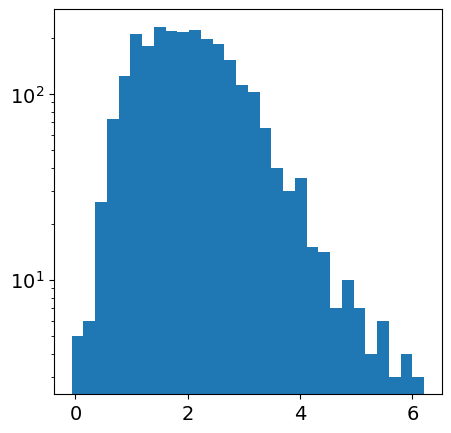

['Euclid_DET11_direct.fits', 'Euclid_DET12_direct.fits', 'Euclid_DET13_direct.fits', 'Euclid_DET14_direct.fits', 'Euclid_DET21_direct.fits', 'Euclid_DET22_direct.fits', 'Euclid_DET23_direct.fits', 'Euclid_DET24_direct.fits', 'Euclid_DET31_direct.fits', 'Euclid_DET32_direct.fits', 'Euclid_DET33_direct.fits', 'Euclid_DET34_direct.fits', 'Euclid_DET41_direct.fits', 'Euclid_DET42_direct.fits', 'Euclid_DET43_direct.fits', 'Euclid_DET44_direct.fits']


In [32]:
# Mauri et al. 2020
# (ropper et al. 2016
os.chdir(os.path.join(HOME_PATH, root, 'Prep', 'Input_Thumbnails'))

# noise characteristics of "direct image"
# Scaramella et al. 2022 - Euclid preparation I. The Euclid Wide Survey
# RGS000, RGS180, RGS000_rot, RGS180_rot
spec_exptime = 574 # seconds
spec_gain = 2.0
# VIS
#flux_key = "TU_FNU_VIS_NISP_MAG"
#mag_key = "VIS"
#dir_exptime = 570 # seconds
#wav_cen = 
#wav_width = 
#eff_tot = 
# Y
#flux_key = "TU_FNU_Y_NISP_MAG"
#mag_key = "NIR_Y"
#dir_exptime = 112. # seconds
#wav_cen = 10809. # Ang
#wav_width = 2627. # Ang
#eff_tot = 0.772
# J
flux_key = "TU_FNU_J_NISP_MAG"
mag_key = "NIR_J"
dir_exptime = 112. # seconds
wav_cen = 13673. # Ang
wav_width = 3994. # Ang
eff_tot = 0.790
# H
#flux_key = "TU_FNU_H_NISP_MAG"
#mag_key = "NIR_H"
#wav_cen = 17714. # Ang
#wav_width = 4999. # Ang
#dir_exptime = 112. # seconds
#eff_tot = 0.782
nexp = 4

#dir_exptime = 448
#nexp = 1

# VIS 
readnoise = 4.5  # e-
background = 1.2 # e-/s
#pixel_size = 12. # um
dir_gain = 1.0   # e-/photon

# NISP
readnoise = 6.   # e-
background = 1.2 # e-/s

#background = 0 # e-/s
#readnoise = 0

#pixel_size = 18. # um
dir_gain = 1.0   # e-/photon

all_direct, test_fluxes, test_mags = fake_euclid_direct(det_dict, flux_key=flux_key, mag_key=mag_key, 
                                            gain=dir_gain, background=background, exptime=dir_exptime, 
                                            nexp=nexp, readnoise=readnoise, wav_cen=wav_cen, 
                                            wav_width=wav_width, eff_tot=eff_tot, heads=heads)
print(all_direct)
# should label direct with "_direct"

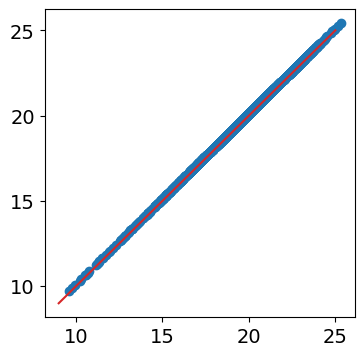

In [33]:
zp = 25.13
mag = -2.5 * np.log10(test_fluxes) + zp
#print(mag)
#print(test_mags)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.scatter(mag,test_mags)
ax.plot([9,25],[9,25],c="tab:red")
plt.show()

mean   = 16.60852006262519
median = 0.4422765210628719
min    = -0.3834904597496036
max    = 747.2955637918529
std    = 75.65408373739116

flux = 8038.52371
mag = 15.367



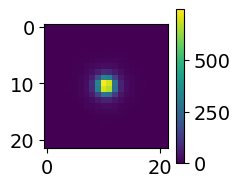

mean   = 1.4643091076941317
median = 0.10473472336037769
min    = -0.3672991775150603
max    = 65.83774048957027
std    = 6.674013924418594

flux = 708.72561
mag = 18.004



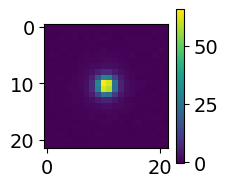

mean   = 0.45026629361530074
median = 0.06263770637173796
min    = -0.40221809383199586
max    = 20.368722835750308
std    = 2.050035212525637

flux = 217.92889
mag = 19.284



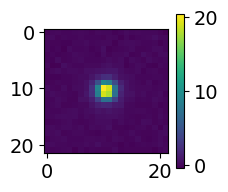

mean   = 0.1289971712479657
median = 0.017400173339775893
min    = -0.549693805275163
max    = 6.414497906509216
std    = 0.6581719434046721

flux = 62.43463
mag = 20.641



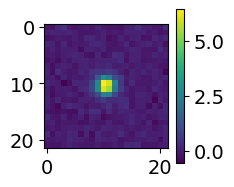

mean   = 0.030281506944175706
median = 0.01960423187871095
min    = -0.43363806303569336
max    = 0.8924388237095877
std    = 0.1734217891871645

flux = 14.65625
mag = 22.215



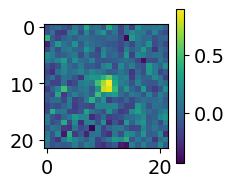

mean   = 0.00976881845980278
median = 0.012040895603713384
min    = -0.49025719626590186
max    = 0.4939137913224605
std    = 0.15682037014895822

flux = 4.72811
mag = 23.443



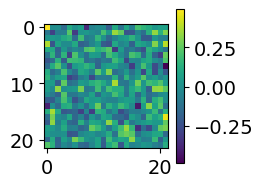

In [34]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

zp = 25.13
# test grid of magnitudes
# det11
# radius = 11 pixels
coord = [[360.5, 1100.5], [360.5, 883.5], [360.5, 1027.5], [360.5, 1172.5], [360.5, 1136.5], 
         [717,1128]]

#pf = pyfits.open("Euclid_DET%s_direct_final.fits" % ('11'))
pf = pyfits.open("Euclid_DET%s_direct.fits" % ('11'))
img = pf['SCI'].data
for c0 in coord:
    
    xc,yc = c0
    xc = int(xc)
    yc = int(yc)
    
    thumb = img[yc-11:yc+11,xc-11:xc+11]
    counts = np.sum(thumb)

    mag = -2.5 * np.log10(counts) + zp
    
    print("mean   =", np.mean(thumb))
    print("median =", np.median(thumb))
    print("min    =", np.min(thumb))
    print("max    =", np.max(thumb))
    print("std    =", np.std(thumb))
    print()
    print("flux = %.5f" % counts)
    print("mag = %.3f" % mag)
    print()

    fig = plt.figure(figsize=(2,2))
    ax = fig.add_subplot(111)
    im = ax.imshow(thumb)
    
    cb = fig.colorbar(im)
    plt.show() 

## Display direct image for each detector

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

fig = plt.figure(figsize=(12,12))

k = 0

#for i in range(4):
#    for j in range(4):
#        name = "Euclid_DET%i%i.fits" % (i+1,j+1)
    
for direct in all_direct:
        
    hdu = pyfits.open(direct)
    print(hdu['SCI'].header)
    hdu.info()
        
    img = hdu['SCI'].data
    print(img.shape)
    head = hdu['SCI'].header
    #print(name)
    print(direct)
    print(head['CRVAL1'])
    print(head['CRVAL2'])
    print(head['CRPIX1'])
    print(head['CRPIX2'])
    print()
        
    print(np.min(img))
    print(np.max(img))
    print(np.mean(img))
    print(np.median(img))
    print(np.std(img))
    #print(hdu[name].header)
    print()
        
    p = fig.add_subplot(4,4,k+1)
    p.imshow(img, vmin=-0.1, vmax=0.1)
    #p.hist(img.flatten(),bins=100)
    #p.set_yscale("log")
    
    k += 1

        
plt.show()


In [ ]:
dir()
print(all_direct)
print(all_slitless)

## Add all of the header metadata needed for Grizli

In [35]:
print(dir_exptime)
print(spec_exptime)
print(nexp)

112.0
574
4


In [36]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

suffix = "_final"

all_final_direct = []
all_final_slitless = []

In [37]:
##############
### DIRECT ###
##############        
for direct in all_direct:
    # updated FITS files
    new_direct = direct.replace(".fits",suffix+".fits")        
    all_final_direct.append(new_direct)

    hdu = pyfits.open(direct)
    hdu.info()
    #del hdu[ext].header['']

    ext = 0
    hdu[ext].header['FILTER'] = 'NISP_H'
    #hdu[ext].header['INSTRUME'] = 'NISP'
    hdu[ext].header['INSTRUME'] = 'NISP-GLWv1'
    hdu[ext].header['EXPTIME'] = dir_exptime # ????
    ##hdu[ext].header['EXTVER'] = ext

    ext = 1
    hdu[ext].header['FILTER'] = 'NISP_H'
    #hdu[ext].header['INSTRUME'] = 'NISP' 
    hdu[ext].header['INSTRUME'] = 'NISP-GLWv1'
    hdu[ext].header['EXTVER'] = ext
    hdu[ext].header['EXPTIME'] = dir_exptime
    hdu.writeto(new_direct, overwrite=True, output_verify='fix')
    print("Writing",new_direct)

Filename: Euclid_DET11_direct.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   ()      
  1  SCI           1 ImageHDU        33   (2048, 2048)   float64   
  2  ERR           1 ImageHDU        33   (2048, 2048)   float64   
  3  DQ            1 ImageHDU        33   (2048, 2048)   float64   
Writing Euclid_DET11_direct_final.fits
Filename: Euclid_DET12_direct.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   ()      
  1  SCI           1 ImageHDU        33   (2048, 2048)   float64   
  2  ERR           1 ImageHDU        33   (2048, 2048)   float64   
  3  DQ            1 ImageHDU        33   (2048, 2048)   float64   
Writing Euclid_DET12_direct_final.fits
Filename: Euclid_DET13_direct.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   ()      
  1  SCI           1 ImageHDU        33   (2048, 2048)   float64   
  

In [38]:
###############
### SPECTRA ###
###############
for slitless in all_slitless[0]:
    
    new_slitless = slitless.replace(".fits",suffix+".fits")
    all_final_slitless.append(new_slitless)
        
    hdu = pyfits.open(slitless)
    hdu.info()

    ext = 0
    #hdu[ext].header['INSTRUME'] = 'NISP' 
    hdu[ext].header['INSTRUME'] = 'NISP-GLWv1'
    hdu[ext].header['FILTER'] = 'RED'
    hdu[ext].header['EXPTIME'] = spec_exptime

    ext = 1
    #hdu[ext].header['INSTRUME'] = 'NISP'
    hdu[ext].header['INSTRUME'] = 'NISP-GLWv1'
    hdu[ext].header['FILTER'] = 'RED'
    hdu[ext].header['EXTVER'] = ext
    hdu[ext].header['EXPTIME'] = spec_exptime

    sci = hdu[ext].data
    #hdu[ext].data = sci/spec_exptime/gain
    hdu[ext].data = (sci-1024.)/spec_exptime/spec_gain


    ext = 2
    chi2 = hdu[ext].data
    hdu[ext].data = np.sqrt(chi2)/spec_exptime/spec_gain

    hdu.writeto(new_slitless, overwrite=True, output_verify='fix')
    print("Writing",new_slitless)


Filename: Euclid_DET11_slitless.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   ()      
  1  SCI           1 ImageHDU        31   (2048, 2048)   int16 (rescales to uint16)   
  2  ERR           1 ImageHDU        29   (2048, 2048)   uint8   
  3  DQ            1 ImageHDU        29   (2048, 2048)   float64   
Writing Euclid_DET11_slitless_final.fits
Filename: Euclid_DET12_slitless.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   ()      
  1  SCI           1 ImageHDU        31   (2048, 2048)   int16 (rescales to uint16)   
  2  ERR           1 ImageHDU        29   (2048, 2048)   uint8   
  3  DQ            1 ImageHDU        29   (2048, 2048)   float64   
Writing Euclid_DET12_slitless_final.fits
Filename: Euclid_DET13_slitless.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   ()      
  1  SCI           1 Image

In [39]:
print(all_final_direct)
print(all_final_slitless)

['Euclid_DET11_direct_final.fits', 'Euclid_DET12_direct_final.fits', 'Euclid_DET13_direct_final.fits', 'Euclid_DET14_direct_final.fits', 'Euclid_DET21_direct_final.fits', 'Euclid_DET22_direct_final.fits', 'Euclid_DET23_direct_final.fits', 'Euclid_DET24_direct_final.fits', 'Euclid_DET31_direct_final.fits', 'Euclid_DET32_direct_final.fits', 'Euclid_DET33_direct_final.fits', 'Euclid_DET34_direct_final.fits', 'Euclid_DET41_direct_final.fits', 'Euclid_DET42_direct_final.fits', 'Euclid_DET43_direct_final.fits', 'Euclid_DET44_direct_final.fits']
['Euclid_DET11_slitless_final.fits', 'Euclid_DET12_slitless_final.fits', 'Euclid_DET13_slitless_final.fits', 'Euclid_DET14_slitless_final.fits', 'Euclid_DET21_slitless_final.fits', 'Euclid_DET22_slitless_final.fits', 'Euclid_DET23_slitless_final.fits', 'Euclid_DET24_slitless_final.fits', 'Euclid_DET31_slitless_final.fits', 'Euclid_DET32_slitless_final.fits', 'Euclid_DET33_slitless_final.fits', 'Euclid_DET34_slitless_final.fits', 'Euclid_DET41_slitless

## Check the pixel scale of the images

In [40]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

#for i in range(4):
#    for j in range(4):
#        num = '%i%i' % (i+1,j+1)
#        new_direct = "Euclid_DET%s%s.fits" % (num,suffix)
#        new_slitless = "Euclid_DET%s_slitless%s.fits"  % (num,suffix)

for direct in all_final_direct:        
    wcs_pixel_scale(direct)

for slitless in all_final_slitless:
    wcs_pixel_scale(slitless)

Filename: Euclid_DET11_direct_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  SCI           1 ImageHDU        36   (2048, 2048)   float64   
  2  ERR           1 ImageHDU        33   (2048, 2048)   float64   
  3  DQ            1 ImageHDU        33   (2048, 2048)   float64   
cdelt1 = 0.2989 "/pixel
cdelt2 = -0.2989 "/pixel
crota1 = 180.0000 deg
crota2 = -0.0000 deg

Filename: Euclid_DET12_direct_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  SCI           1 ImageHDU        36   (2048, 2048)   float64   
  2  ERR           1 ImageHDU        33   (2048, 2048)   float64   
  3  DQ            1 ImageHDU        33   (2048, 2048)   float64   
cdelt1 = 0.2989 "/pixel
cdelt2 = -0.2989 "/pixel
crota1 = 180.0000 deg
crota2 = -0.0000 deg

Filename: Euclid_DET13_direct_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Fo

cdelt1 = 0.2989 "/pixel
cdelt2 = -0.2989 "/pixel
crota1 = 180.0000 deg
crota2 = -0.0000 deg

Filename: Euclid_DET14_slitless_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  SCI           1 ImageHDU        35   (2048, 2048)   float64   
  2  ERR           1 ImageHDU        29   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        29   (2048, 2048)   float64   
cdelt1 = 0.2989 "/pixel
cdelt2 = -0.2989 "/pixel
crota1 = 180.0000 deg
crota2 = -0.0000 deg

Filename: Euclid_DET21_slitless_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  SCI           1 ImageHDU        35   (2048, 2048)   float64   
  2  ERR           1 ImageHDU        29   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        29   (2048, 2048)   float64   
cdelt1 = 0.2989 "/pixel
cdelt2 = -0.2989 "/pixel
crota1 = 180.0000 deg
crota2 = -0.0000 deg

F

In [41]:
# remove segmentation FITS to redo "next" step
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
!rm *_seg.fits

## Find sources in the direct image
[top](#Table-of-Contents)

Just like the multi-mission, I am using SExtractor to find all of the sources in the direct images. This step is important not only for finding the sources but also for generating the segmentation map which will be used during the extraction of the spectra.

I may eventually adapt this to use SEP just like Grizli, but currently I understand SExtractor a little better.

The re-run the previous step, run this command.  In case you want to change the SExtractor parameters.

In [42]:
## Make SExtractor catalog
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Euclid (Schirmer et al. 2022, XVIII. The NISP photometric system)
#mag_zero = 25.04 # +- 0.05 mag   Y 
#mag_zero = 25.26 # +- 0.05 mag   J
#mag_zero = 25.21 # +- 0.05 mag   H

mag_zero = 25.13 # H

all_cat = []
all_seg = []
all_bkg = []

for direct in all_final_direct:

    prefix = direct.replace(".fits","")
    
    sex = "Euclid.sex"
             
    cat = prefix + ".cat" 
    #wht = prefix + "_wht.fits"
    seg = prefix + "_seg.fits"
    bkg = prefix + "_bkg.fits"
    #aper = prefix + "_aper.fits"
    
    all_cat.append(cat)
    all_seg.append(seg)
    all_bkg.append(bkg)
        
    if not os.path.exists(seg):
    
        wht = direct + "[2]"
        direct_ext = direct + "[1]"
        
        checkimage_name = seg + "," + bkg
        
        sex_str = 'sex ' + direct_ext + ' -c ' + sex + ' -WEIGHT_IMAGE ' + wht + \
                  ' -CHECKIMAGE_NAME ' + checkimage_name + ' -CATALOG_NAME ' + cat + \
                  ' -MAG_ZEROPOINT %.2f' % (mag_zero)
        os.system(sex_str)
        print(sex_str)
            
    else:
        print("Skipping...")
        

# awk '{ printf "circle(%f, %f, 0.00007) # text={%.3f}\n", $4, $5, $42 }' GRS_FOV1_roll0_dx0_dy0_SCA1_direct.cat > GRS_FOV1_roll0_dx0_dy0_SCA1_direct.reg
        


> WARNING: NTHREADS != 1 ignored: this build of SExtractor is single-threaded

> 
----- SExtractor 2.19.5 started on 2023-05-22 at 14:17:06 with 1 thread

> Setting catalog parameters
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for Euclid_DET11_direct_final.fits
----- Measuring from: Euclid_DET11_direct_final.fits [1/3]
      "Unnamed" / no ext. header / 2048x2048 / 64 bits (floats)
> Looking for Euclid_DET11_direct_final.fits
----- Weighting from: Euclid_DET11_direct_final.fits [2/3]
      "Unnamed" / no ext. header / 2048x2048 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting u

      Objects: detected 252      / sextracted 252             

> Closing files
> 
> All done (in 0.7 s: 2932.6 lines/s , 360.8 detections/s)

> WARNING: NTHREADS != 1 ignored: this build of SExtractor is single-threaded

> 
----- SExtractor 2.19.5 started on 2023-05-22 at 14:17:06 with 1 thread

> Setting catalog parameters
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for Euclid_DET12_direct_final.fits
----- Measuring from: Euclid_DET12_direct_final.fits [1/3]
      "Unnamed" / no ext. header / 2048x2048 / 64 bits (floats)
> Looking for Euclid_DET12_direct_final.fits
----- Weighting from: Euclid_DET12_direct_final.fits [2/3]
      "Unnamed" / no ext. header / 2048x2048 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line: 

sex Euclid_DET11_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET11_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET11_direct_final_seg.fits,Euclid_DET11_direct_final_bkg.fits -CATALOG_NAME Euclid_DET11_direct_final.cat -MAG_ZEROPOINT 25.13


> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Objects:        0 detected /        0 sextracted
> Line:  125  Objects:        0 detected /        0 sextracted
> Line:  150  Objects:        5 detected /        0 sextracted
> Line:  175  Objects:        5 detected /        0 sextracted
> Line:  200  Objects:       11 detected /        0 sextracted
> Line:  225  Objects:       12 detected /        0 sextracted
> Line:  250  Objects:       14 detected /        0 sextracted
> Line:  275  Objects:       17 detected /        0 sextracted
> Line:  300  Objects:       19 detected /        0 sextracted
> Line:  325  Objects:       20 detected /        0 sextracted
> Line:  350  Objects:       25 detected /        0 sextracted
> Line:  375  Objects:       27 detected /        0 sextracted
> Line:  400  Objects:       28 detected /        0 sex

sex Euclid_DET12_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET12_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET12_direct_final_seg.fits,Euclid_DET12_direct_final_bkg.fits -CATALOG_NAME Euclid_DET12_direct_final.cat -MAG_ZEROPOINT 25.13


> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Objects:        0 detected /        0 sextracted
> Line:  125  Objects:        0 detected /        0 sextracted
> Line:  150  Objects:        1 detected /        0 sextracted
> Line:  175  Objects:        1 detected /        0 sextracted
> Line:  200  Objects:        8 detected /        0 sextracted
> Line:  225  Objects:        9 detected /        0 sextracted
> Line:  250  Objects:       15 detected /        0 sextracted
> Line:  275  Objects:       22 detected /        0 sextracted
> Line:  300  Objects:       23 detected /        0 sextracted
> Line:  325  Objects:       25 detected /        0 sextracted
> Line:  350  Objects:       36 detected /        0 sextracted
> Line:  375  Objects:       37 detected /        0 sextracted
> Line:  400  Objects:       45 detected /        0 sex

sex Euclid_DET13_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET13_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET13_direct_final_seg.fits,Euclid_DET13_direct_final_bkg.fits -CATALOG_NAME Euclid_DET13_direct_final.cat -MAG_ZEROPOINT 25.13


> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Objects:        0 detected /        0 sextracted
> Line:  125  Objects:        1 detected /        0 sextracted
> Line:  150  Objects:        1 detected /        0 sextracted
> Line:  175  Objects:        5 detected /        0 sextracted
> Line:  200  Objects:        6 detected /        0 sextracted
> Line:  225  Objects:       10 detected /        0 sextracted
> Line:  250  Objects:       17 detected /        0 sextracted
> Line:  275  Objects:       19 detected /        0 sextracted
> Line:  300  Objects:       22 detected /        0 sextracted
> Line:  325  Objects:       24 detected /        0 sextracted
> Line:  350  Objects:       26 detected /        0 sextracted
> Line:  375  Objects:       27 detected /        0 sextracted
> Line:  400  Objects:       33 detected /        0 sex

sex Euclid_DET14_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET14_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET14_direct_final_seg.fits,Euclid_DET14_direct_final_bkg.fits -CATALOG_NAME Euclid_DET14_direct_final.cat -MAG_ZEROPOINT 25.13


> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Objects:        0 detected /        0 sextracted
> Line:  125  Objects:        5 detected /        0 sextracted
> Line:  150  Objects:        5 detected /        0 sextracted
> Line:  175  Objects:        7 detected /        0 sextracted
> Line:  200  Objects:        8 detected /        0 sextracted
> Line:  225  Objects:        8 detected /        0 sextracted
> Line:  250  Objects:       11 detected /        0 sextracted
> Line:  275  Objects:       14 detected /        0 sextracted
> Line:  300  Objects:       16 detected /        0 sextracted
> Line:  325  Objects:       17 detected /        0 sextracted
> Line:  350  Objects:       26 detected /        0 sextracted
> Line:  375  Objects:       30 detected /        0 sextracted
> Line:  400  Objects:       31 detected /        0 sex

sex Euclid_DET21_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET21_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET21_direct_final_seg.fits,Euclid_DET21_direct_final_bkg.fits -CATALOG_NAME Euclid_DET21_direct_final.cat -MAG_ZEROPOINT 25.13


> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Objects:        0 detected /        0 sextracted
> Line:  125  Objects:        0 detected /        0 sextracted
> Line:  150  Objects:        8 detected /        0 sextracted
> Line:  175  Objects:        8 detected /        0 sextracted
> Line:  200  Objects:       15 detected /        0 sextracted
> Line:  225  Objects:       17 detected /        0 sextracted
> Line:  250  Objects:       18 detected /        0 sextracted
> Line:  275  Objects:       21 detected /        0 sextracted
> Line:  300  Objects:       23 detected /        0 sextracted
> Line:  325  Objects:       25 detected /        0 sextracted
> Line:  350  Objects:       31 detected /        0 sextracted
> Line:  375  Objects:       34 detected /        0 sextracted
> Line:  400  Objects:       36 detected /        0 sex

sex Euclid_DET22_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET22_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET22_direct_final_seg.fits,Euclid_DET22_direct_final_bkg.fits -CATALOG_NAME Euclid_DET22_direct_final.cat -MAG_ZEROPOINT 25.13


> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Objects:        0 detected /        0 sextracted
> Line:  125  Objects:        0 detected /        0 sextracted
> Line:  150  Objects:        5 detected /        0 sextracted
> Line:  175  Objects:        5 detected /        0 sextracted
> Line:  200  Objects:        8 detected /        0 sextracted
> Line:  225  Objects:       14 detected /        0 sextracted
> Line:  250  Objects:       16 detected /        0 sextracted
> Line:  275  Objects:       18 detected /        0 sextracted
> Line:  300  Objects:       20 detected /        0 sextracted
> Line:  325  Objects:       25 detected /        0 sextracted
> Line:  350  Objects:       32 detected /        0 sextracted
> Line:  375  Objects:       39 detected /        0 sextracted
> Line:  400  Objects:       41 detected /        0 sex

sex Euclid_DET23_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET23_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET23_direct_final_seg.fits,Euclid_DET23_direct_final_bkg.fits -CATALOG_NAME Euclid_DET23_direct_final.cat -MAG_ZEROPOINT 25.13


> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Objects:        0 detected /        0 sextracted
> Line:  125  Objects:        1 detected /        0 sextracted
> Line:  150  Objects:        6 detected /        0 sextracted
> Line:  175  Objects:       13 detected /        0 sextracted
> Line:  200  Objects:       19 detected /        0 sextracted
> Line:  225  Objects:       24 detected /        0 sextracted
> Line:  250  Objects:       32 detected /        0 sextracted
> Line:  275  Objects:       37 detected /        0 sextracted
> Line:  300  Objects:       38 detected /        0 sextracted
> Line:  325  Objects:       46 detected /        0 sextracted
> Line:  350  Objects:       48 detected /        0 sextracted
> Line:  375  Objects:       51 detected /        0 sextracted
> Line:  400  Objects:       52 detected /        0 sex

sex Euclid_DET24_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET24_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET24_direct_final_seg.fits,Euclid_DET24_direct_final_bkg.fits -CATALOG_NAME Euclid_DET24_direct_final.cat -MAG_ZEROPOINT 25.13


> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Objects:        0 detected /        0 sextracted
> Line:  125  Objects:        2 detected /        0 sextracted
> Line:  150  Objects:        2 detected /        0 sextracted
> Line:  175  Objects:        5 detected /        0 sextracted
> Line:  200  Objects:        6 detected /        0 sextracted
> Line:  225  Objects:        8 detected /        0 sextracted
> Line:  250  Objects:       13 detected /        0 sextracted
> Line:  275  Objects:       17 detected /        0 sextracted
> Line:  300  Objects:       18 detected /        0 sextracted
> Line:  325  Objects:       20 detected /        0 sextracted
> Line:  350  Objects:       26 detected /        0 sextracted
> Line:  375  Objects:       26 detected /        0 sextracted
> Line:  400  Objects:       30 detected /        0 sex

sex Euclid_DET31_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET31_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET31_direct_final_seg.fits,Euclid_DET31_direct_final_bkg.fits -CATALOG_NAME Euclid_DET31_direct_final.cat -MAG_ZEROPOINT 25.13


> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Objects:        0 detected /        0 sextracted
> Line:  125  Objects:        0 detected /        0 sextracted
> Line:  150  Objects:        1 detected /        0 sextracted
> Line:  175  Objects:        1 detected /        0 sextracted
> Line:  200  Objects:        9 detected /        0 sextracted
> Line:  225  Objects:       11 detected /        0 sextracted
> Line:  250  Objects:       14 detected /        0 sextracted
> Line:  275  Objects:       19 detected /        0 sextracted
> Line:  300  Objects:       19 detected /        0 sextracted
> Line:  325  Objects:       21 detected /        0 sextracted
> Line:  350  Objects:       24 detected /        0 sextracted
> Line:  375  Objects:       27 detected /        0 sextracted
> Line:  400  Objects:       28 detected /        0 sex

sex Euclid_DET32_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET32_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET32_direct_final_seg.fits,Euclid_DET32_direct_final_bkg.fits -CATALOG_NAME Euclid_DET32_direct_final.cat -MAG_ZEROPOINT 25.13


> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Objects:        0 detected /        0 sextracted
> Line:  125  Objects:        0 detected /        0 sextracted
> Line:  150  Objects:        2 detected /        0 sextracted
> Line:  175  Objects:        2 detected /        0 sextracted
> Line:  200  Objects:        4 detected /        0 sextracted
> Line:  225  Objects:        5 detected /        0 sextracted
> Line:  250  Objects:        7 detected /        0 sextracted
> Line:  275  Objects:        9 detected /        0 sextracted
> Line:  300  Objects:       10 detected /        0 sextracted
> Line:  325  Objects:       14 detected /        0 sextracted
> Line:  350  Objects:       16 detected /        0 sextracted
> Line:  375  Objects:       18 detected /        0 sextracted
> Line:  400  Objects:       20 detected /        0 sex

sex Euclid_DET33_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET33_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET33_direct_final_seg.fits,Euclid_DET33_direct_final_bkg.fits -CATALOG_NAME Euclid_DET33_direct_final.cat -MAG_ZEROPOINT 25.13


> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Objects:        0 detected /        0 sextracted
> Line:  125  Objects:        1 detected /        0 sextracted
> Line:  150  Objects:        1 detected /        0 sextracted
> Line:  175  Objects:        4 detected /        0 sextracted
> Line:  200  Objects:        5 detected /        0 sextracted
> Line:  225  Objects:        7 detected /        0 sextracted
> Line:  250  Objects:       10 detected /        0 sextracted
> Line:  275  Objects:       11 detected /        0 sextracted
> Line:  300  Objects:       15 detected /        0 sextracted
> Line:  325  Objects:       17 detected /        0 sextracted
> Line:  350  Objects:       19 detected /        0 sextracted
> Line:  375  Objects:       21 detected /        0 sextracted
> Line:  400  Objects:       23 detected /        0 sex

sex Euclid_DET34_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET34_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET34_direct_final_seg.fits,Euclid_DET34_direct_final_bkg.fits -CATALOG_NAME Euclid_DET34_direct_final.cat -MAG_ZEROPOINT 25.13


> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Objects:        0 detected /        0 sextracted
> Line:  125  Objects:        3 detected /        0 sextracted
> Line:  150  Objects:        3 detected /        0 sextracted
> Line:  175  Objects:        6 detected /        0 sextracted
> Line:  200  Objects:        8 detected /        0 sextracted
> Line:  225  Objects:       10 detected /        0 sextracted
> Line:  250  Objects:       12 detected /        0 sextracted
> Line:  275  Objects:       14 detected /        0 sextracted
> Line:  300  Objects:       18 detected /        0 sextracted
> Line:  325  Objects:       19 detected /        0 sextracted
> Line:  350  Objects:       22 detected /        0 sextracted
> Line:  375  Objects:       25 detected /        0 sextracted
> Line:  400  Objects:       26 detected /        0 sex

sex Euclid_DET41_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET41_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET41_direct_final_seg.fits,Euclid_DET41_direct_final_bkg.fits -CATALOG_NAME Euclid_DET41_direct_final.cat -MAG_ZEROPOINT 25.13



> WARNING: NTHREADS != 1 ignored: this build of SExtractor is single-threaded

> 
----- SExtractor 2.19.5 started on 2023-05-22 at 14:17:14 with 1 thread

> Setting catalog parameters
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for Euclid_DET42_direct_final.fits
----- Measuring from: Euclid_DET42_direct_final.fits [1/3]
      "Unnamed" / no ext. header / 2048x2048 / 64 bits (floats)
> Looking for Euclid_DET42_direct_final.fits
----- Weighting from: Euclid_DET42_direct_final.fits [2/3]
      "Unnamed" / no ext. header / 2048x2048 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting u

      Objects: detected 158      / sextracted 158             

> Closing files
> 
> All done (in 0.6 s: 3326.2 lines/s , 256.6 detections/s)

> WARNING: NTHREADS != 1 ignored: this build of SExtractor is single-threaded

> 
----- SExtractor 2.19.5 started on 2023-05-22 at 14:17:15 with 1 thread

> Setting catalog parameters
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for Euclid_DET43_direct_final.fits
----- Measuring from: Euclid_DET43_direct_final.fits [1/3]
      "Unnamed" / no ext. header / 2048x2048 / 64 bits (floats)
> Looking for Euclid_DET43_direct_final.fits
----- Weighting from: Euclid_DET43_direct_final.fits [2/3]
      "Unnamed" / no ext. header / 2048x2048 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line: 

sex Euclid_DET42_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET42_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET42_direct_final_seg.fits,Euclid_DET42_direct_final_bkg.fits -CATALOG_NAME Euclid_DET42_direct_final.cat -MAG_ZEROPOINT 25.13


> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Objects:        0 detected /        0 sextracted
> Line:  125  Objects:        0 detected /        0 sextracted
> Line:  150  Objects:        1 detected /        0 sextracted
> Line:  175  Objects:        1 detected /        0 sextracted
> Line:  200  Objects:        3 detected /        0 sextracted
> Line:  225  Objects:        4 detected /        0 sextracted
> Line:  250  Objects:        5 detected /        0 sextracted
> Line:  275  Objects:        7 detected /        0 sextracted
> Line:  300  Objects:        8 detected /        0 sextracted
> Line:  325  Objects:       10 detected /        0 sextracted
> Line:  350  Objects:       11 detected /        0 sextracted
> Line:  375  Objects:       13 detected /        0 sextracted
> Line:  400  Objects:       14 detected /        0 sex

sex Euclid_DET43_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET43_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET43_direct_final_seg.fits,Euclid_DET43_direct_final_bkg.fits -CATALOG_NAME Euclid_DET43_direct_final.cat -MAG_ZEROPOINT 25.13


> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Objects:        0 detected /        0 sextracted
> Line:  125  Objects:        1 detected /        0 sextracted
> Line:  150  Objects:        1 detected /        0 sextracted
> Line:  175  Objects:        2 detected /        0 sextracted
> Line:  200  Objects:        4 detected /        0 sextracted
> Line:  225  Objects:        4 detected /        0 sextracted
> Line:  250  Objects:        7 detected /        0 sextracted
> Line:  275  Objects:       10 detected /        0 sextracted
> Line:  300  Objects:       10 detected /        0 sextracted
> Line:  325  Objects:       12 detected /        0 sextracted
> Line:  350  Objects:       14 detected /        0 sextracted
> Line:  375  Objects:       16 detected /        0 sextracted
> Line:  400  Objects:       16 detected /        0 sex

sex Euclid_DET44_direct_final.fits[1] -c Euclid.sex -WEIGHT_IMAGE Euclid_DET44_direct_final.fits[2] -CHECKIMAGE_NAME Euclid_DET44_direct_final_seg.fits,Euclid_DET44_direct_final_bkg.fits -CATALOG_NAME Euclid_DET44_direct_final.cat -MAG_ZEROPOINT 25.13


      Objects: detected 128      / sextracted 128             

> Closing files
> 
> All done (in 0.6 s: 3628.6 lines/s , 226.8 detections/s)


In [43]:
#print(all_final_direct)
#print(all_final_slitless)
print(all_cat)
print(all_bkg)
print(all_seg)

['Euclid_DET11_direct_final.cat', 'Euclid_DET12_direct_final.cat', 'Euclid_DET13_direct_final.cat', 'Euclid_DET14_direct_final.cat', 'Euclid_DET21_direct_final.cat', 'Euclid_DET22_direct_final.cat', 'Euclid_DET23_direct_final.cat', 'Euclid_DET24_direct_final.cat', 'Euclid_DET31_direct_final.cat', 'Euclid_DET32_direct_final.cat', 'Euclid_DET33_direct_final.cat', 'Euclid_DET34_direct_final.cat', 'Euclid_DET41_direct_final.cat', 'Euclid_DET42_direct_final.cat', 'Euclid_DET43_direct_final.cat', 'Euclid_DET44_direct_final.cat']
['Euclid_DET11_direct_final_bkg.fits', 'Euclid_DET12_direct_final_bkg.fits', 'Euclid_DET13_direct_final_bkg.fits', 'Euclid_DET14_direct_final_bkg.fits', 'Euclid_DET21_direct_final_bkg.fits', 'Euclid_DET22_direct_final_bkg.fits', 'Euclid_DET23_direct_final_bkg.fits', 'Euclid_DET24_direct_final_bkg.fits', 'Euclid_DET31_direct_final_bkg.fits', 'Euclid_DET32_direct_final_bkg.fits', 'Euclid_DET33_direct_final_bkg.fits', 'Euclid_DET34_direct_final_bkg.fits', 'Euclid_DET41_

In [44]:
all_phot = []

for cat in all_cat:
    #print(cat)
    phot = Table.read(cat, format='ascii.sextractor') # ref_cat in multimission
    all_phot.append(phot)
    print(cat," number_of_sources =",len(phot))
print()
print(phot.colnames)

Euclid_DET11_direct_final.cat  number_of_sources = 252
Euclid_DET12_direct_final.cat  number_of_sources = 228
Euclid_DET13_direct_final.cat  number_of_sources = 264
Euclid_DET14_direct_final.cat  number_of_sources = 247
Euclid_DET21_direct_final.cat  number_of_sources = 282
Euclid_DET22_direct_final.cat  number_of_sources = 244
Euclid_DET23_direct_final.cat  number_of_sources = 270
Euclid_DET24_direct_final.cat  number_of_sources = 259
Euclid_DET31_direct_final.cat  number_of_sources = 259
Euclid_DET32_direct_final.cat  number_of_sources = 194
Euclid_DET33_direct_final.cat  number_of_sources = 221
Euclid_DET34_direct_final.cat  number_of_sources = 246
Euclid_DET41_direct_final.cat  number_of_sources = 128
Euclid_DET42_direct_final.cat  number_of_sources = 158
Euclid_DET43_direct_final.cat  number_of_sources = 154
Euclid_DET44_direct_final.cat  number_of_sources = 128

['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'X_WORLD', 'Y_WORLD', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'A_WORLD', 'B_WORLD', 'THET

In [ ]:
fig = plt.figure(figsize=(12,12))

k = 0
ax = []
for i,phot in enumerate(all_phot):
    
    cat = all_cat[i]

    #print(phot["MAG_AUTO"])
    #print(phot["FLUX_AUTO"])

    if len(phot) > 0:    
        print(np.min(phot["MAG_AUTO"]),np.max(phot["MAG_AUTO"]))
        #print(np.min(phot["FLUX_AUTO"]),np.max(phot["FLUX_AUTO"]))

    
    ax = fig.add_subplot(4,4,k+1)
    ax.hist(phot["MAG_AUTO"],range=(10,32),bins=44)
    #ax.hist(phot["MAG_AUTO"],bins=20)
    #ax.hist(phot["FLUX_AUTO"],bins=20)


    ax.set_xlabel(cat)
    ax.set_ylabel("N")
    ax.set_xlim(10,32)
    
    k += 1
    
plt.show()

In [45]:
for phot in all_phot:
    print(phot)

NUMBER  X_IMAGE   Y_IMAGE  ... FLUX_RADIUS FLUX_RADIUS_1 CLASS_STAR
          pix       pix    ...     pix          pix                
------ --------- --------- ... ----------- ------------- ----------
     1 1059.4834  111.4433 ...       1.535         3.227      0.094
     2  361.4673 2012.3164 ...       1.027         2.129      0.833
     3  370.3488  2003.295 ...       1.062         1.969      0.177
     4  361.4194 2003.4199 ...       1.545         3.401      0.831
     5  352.6642 2003.2858 ...       1.096         2.177      0.029
     6  361.2951 1994.6534 ...       1.003         1.934      0.229
   ...       ...       ... ...         ...           ...        ...
   246 1758.4694  195.4341 ...       1.383         2.454      0.087
   247  360.3846  196.3984 ...       1.422         2.886      0.036
   248  1059.153  191.2734 ...       0.937         1.305      0.001
   249 1059.4084   184.398 ...       1.499         3.353      0.029
   250  360.5784  160.5068 ...       1.535      

In [ ]:
plot_labels = 1
mag_cut = 17.

fig = plt.figure(figsize=(12,12))

k = 0
for direct,phot in zip(all_direct,all_phot):

    hdu = pyfits.open(direct)
    img = hdu[1].data
    
    p1 = fig.add_subplot(4,4,k+1)
    p1.imshow(img,origin="lower",vmin=-0.1,vmax=0.1)
    p1.scatter(phot["X_IMAGE"],phot["Y_IMAGE"],fc="None",ec="r",s=60,lw=0.3)

    if plot_labels:
        for j,src in enumerate(phot['MAG_AUTO']):
        #for j,src in enumerate(phot['NUMBER']):
        #for j,src in enumerate(phot['FLUX_AUTO']):
            if src < mag_cut:
                p1.text(phot['X_IMAGE'][j],phot['Y_IMAGE'][j],src)
            
    
    k += 1
plt.show()

Total number of sources found = 252
Search primer and all_tbl for RA/DEC matches
Join all_tbl and primer tables
Select only sources < 0.60 arcsec
[0, 1, 2, 3, 4, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 417, 418, 419, 420, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 444, 445, 446, 447, 448, 449, 450, 451, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467]
Number of matches = 149

['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'X_WORLD', 'Y_WORLD', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'A_WORLD', 'B_WORLD', 'THETA_WORLD', 'FLUX_APER'

Join all_tbl and primer tables
Select only sources < 0.60 arcsec
[780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 815, 816, 817, 818, 819, 820, 821, 822, 823, 825, 826, 827, 828, 829, 831, 988, 989, 990, 991, 992, 993, 994, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1244, 1245, 1246, 1247]
Number of matches = 150

Total number of sources found = 259
Search primer and all_tbl for RA/

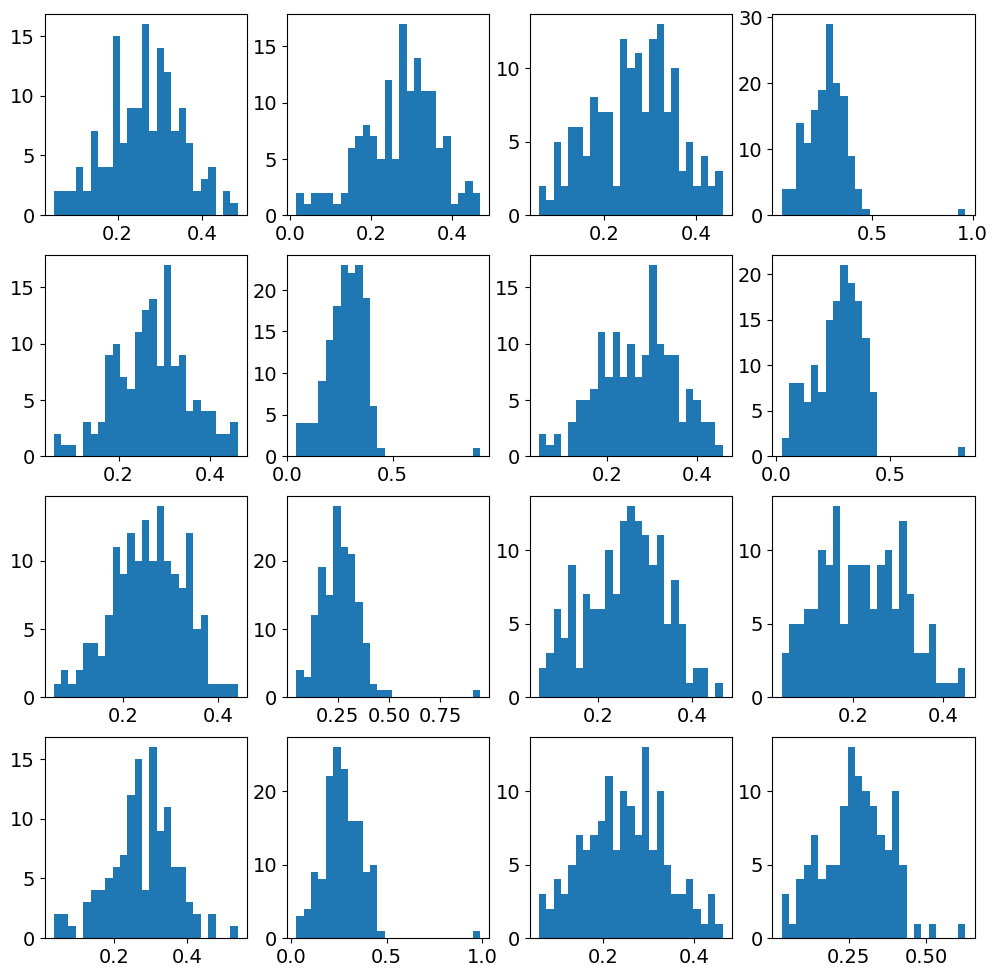

In [46]:
from astropy.table import Table, join, vstack
import astropy.units as u
from astropy.coordinates import SkyCoord

verb = 1
search_rad = 0.6

if verb:
    fig = plt.figure(figsize=(12,12))

all_phot_matched_clean = []
    
k = 0
for i,phot in enumerate(all_phot):
    
    #print(all_final_direct[i])
    print("Total number of sources found =",len(phot))
    print("Search primer and all_tbl for RA/DEC matches")
    
    if len(phot) > 0:
        c_prime = SkyCoord(ra=primer["RA"]*u.degree, dec=primer["DEC"]*u.degree)
        c_phot = SkyCoord(ra=phot["X_WORLD"], dec=phot["Y_WORLD"])

        #idx, d2d, d3d = c_prime.match_to_catalog_sky(c_phot)
        idx, d2d, d3d = c_phot.match_to_catalog_sky(c_prime)

        filt = d2d < 1*u.arcsec

        if verb:
            p1 = fig.add_subplot(4,4,k+1)
            p1.hist(d2d[filt].value*3600.,bins=25)
        
        #primer['idx'] = idx
        #primer['d2d'] = d2d

        phot['idx'] = idx
        phot['d2d'] = d2d
        #print(primer.colnames)
        
        #phot['idx'] = np.arange(len(phot))
        primer['idx'] = np.arange(len(primer))
        #print(all_tbl.colnames)
        #print(all_tbl['idx'])
        
        print("Join all_tbl and primer tables")
        match_tbl = join(phot, primer, keys='idx')
        #print(match_tbl)
        #print(match_tbl.colnames)
        
        print("Select only sources < %.2f arcsec" % (search_rad))
        #filt = match_tbl['d2d'] < 1.0*u.arcsec
        clean_filt = match_tbl['d2d'] < search_rad*u.arcsec
        match_clean_tbl = match_tbl[clean_filt]
        print(list(match_clean_tbl['idx']))
        print("Number of matches =",len(match_clean_tbl))
        print()
        
        if not i: print(match_clean_tbl.colnames)
        
    else:
        match_clean_tbl = []
    
    all_phot_matched_clean.append(match_clean_tbl)
    
    k+=1
        

In [ ]:
plot_labels = 0

fig = plt.figure(figsize=(12,12))

k = 0    
for direct,match_clean_tbl in zip(all_direct,all_phot_matched_clean):

    hdu = pyfits.open(direct)
    img = hdu[1].data

    p1 = fig.add_subplot(4,4,k+1)
    p1.imshow(img,origin="lower",vmin=-0.1,vmax=0.1)
    #p1.scatter(phot["X_IMAGE"],phot["Y_IMAGE"],fc="None",ec="r",s=60)
    if len(match_clean_tbl) > 0:
        p1.scatter(match_clean_tbl['X_IMAGE'],match_clean_tbl['Y_IMAGE'],lw=0.3,fc="None",ec="r",s=60)
    
    if plot_labels and len(match_clean_tbl) > 0:
        for j,src in enumerate(match_clean_tbl['SOURCE_ID']):
            #print(j)
            p1.text(match_clean_tbl['X_IMAGE'][j],match_clean_tbl['Y_IMAGE'][j],src)
    k += 1
plt.show()

In [47]:
print([col for col in primer.colnames if "TU_" in col])
Euclid_bands = ['NIR_H']
Euclid_bands_flux = ['TU_FNU_H_NISP_MAG']

['TU_FNU_VIS_MAG', 'TU_FNU_Y_NISP_MAG', 'TU_FNU_J_NISP_MAG', 'TU_FNU_H_NISP_MAG', 'TU_FNU_G_DECAM_MAG', 'TU_FNU_R_DECAM_MAG', 'TU_FNU_I_DECAM_MAG', 'TU_FNU_Z_DECAM_MAG', 'TU_FNU_U_MEGACAM_MAG', 'TU_FNU_R_MEGACAM_MAG', 'TU_FNU_G_JPCAM_MAG', 'TU_FNU_I_PANSTARRS_MAG', 'TU_FNU_Z_PANSTARRS_MAG', 'TU_FNU_Z_HSC_MAG', 'TU_FNU_G_GAIA_MAG', 'TU_FNU_BP_GAIA_MAG', 'TU_FNU_RP_GAIA_MAG', 'TU_FNU_U_LSST_MAG', 'TU_FNU_G_LSST_MAG', 'TU_FNU_R_LSST_MAG', 'TU_FNU_I_LSST_MAG', 'TU_FNU_Z_LSST_MAG', 'TU_FNU_Y_LSST_MAG', 'TU_FNU_U_KIDS_MAG', 'TU_FNU_G_KIDS_MAG', 'TU_FNU_R_KIDS_MAG', 'TU_FNU_I_KIDS_MAG', 'TU_FNU_J_2MASS_MAG', 'TU_FNU_H_2MASS_MAG', 'TU_FNU_KS_2MASS_MAG']


N = 16

i = 0
Magnitudes:
min = 9.348
max = 23.002

Zeropoint:
mean   = 24.650
median = 24.660
std    = 0.267
min    = 23.912
max    = 25.264


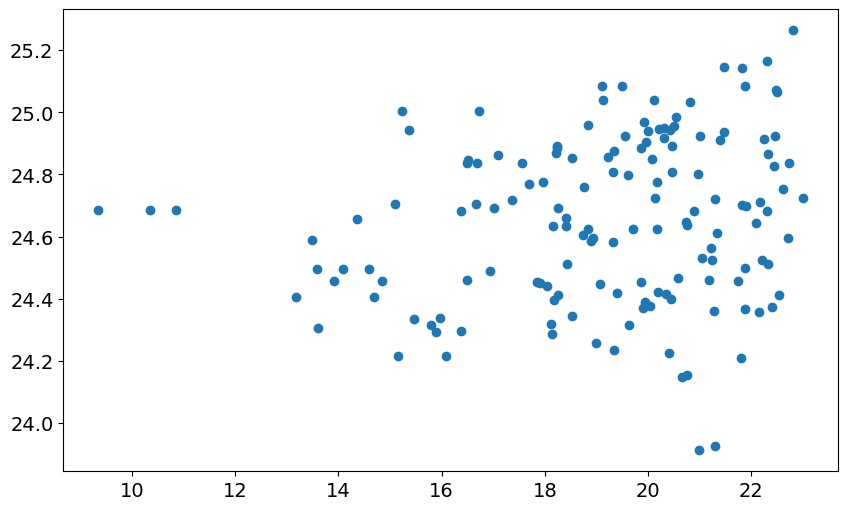

i = 1


IndexError: list index out of range

In [48]:
print("N =",len(all_phot_matched_clean))
print()

verb = 0

for i,match_clean_tbl in enumerate(all_phot_matched_clean):  
    zps = []
    mags = []
    
    if len(match_clean_tbl) > 0:
        print("i =",i)
                
        for k,row in enumerate(match_clean_tbl):
            
            #ind = np.argmax(match_clean_tbl['FLUX_AUTO'])

            #print("ind =",ind)
            dn = row['FLUX_AUTO']
            mag = row[Euclid_bands[i]]
            flux = row[Euclid_bands_flux[i]]

            ## mag = -2.5 * log10(dn/exptime) + zp
            zp = mag + 2.5*np.log10(dn)
            
            
            mags.append(mag)
            zps.append(zp)
            if verb:
                print(k)
                print("dn =", dn)
                print("mag =", mag)
                print("flux =", flux)
                print("zp =", zp)
                print()

    print("Magnitudes:")
    print("min = %.3f" % (np.min(mags)))
    print("max = %.3f" % (np.max(mags)))
    print()

    print("Zeropoint:")
    print("mean   = %.3f" % (np.mean(zps)))
    print("median = %.3f" % (np.median(zps)))
    print("std    = %.3f" % (np.std(zps)))
    print("min    = %.3f" % (np.min(zps)))
    print("max    = %.3f" % (np.max(zps)))


    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(mags,zps)
    plt.show()

In [ ]:
rms = 0.15
zp = 25.13
mag = - 2.5*np.log10(5*rms) + zp
print(mag)

## Euclid object simulation
[top](#Table-of-Contents)

In [72]:
import importlib
importlib.reload(grizli.model)

<module 'grizli.model' from '/Users/gwalth/python/src/grizli_v1.6.0.dev42/grizli/model.py'>

In [73]:
import grizli.model

In [56]:
#############################
# Original for direct image #
#############################

T0 = time.time()

os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# allow simulation of objects at the edges
pad=100 # pixels
#pad = 800 # I think this may be optimal given the spectra size (only seems to add 10-20 spectra)

mag_limit = 30 

all_euclid = []

for i in range(len(all_final_slitless)):
    
    t0 = time.time()

    Euclid = grizli.model.GrismFLT(grism_file=all_final_slitless[i], verbose=True, pad=pad,  
                                   ref_file=all_final_direct[i], ref_ext=1,
                                   seg_file=all_seg[i], 
                                   #shrink_segimage=False)
                                   shrink_segimage=True)

    Euclid_cat = Euclid.blot_catalog(all_phot_matched_clean[i], sextractor=True) 
    #Euclid_cat = Euclid.blot_catalog(all_phot[i], sextractor=True) 
    Euclid.catalog = Euclid_cat

    mask = Euclid_cat['MAG_AUTO'] < mag_limit
    print('N=%d' %(mask.sum()))
    #Euclid.compute_full_model(compute_beams=['A'], mask=mask, verbose=False)
    Euclid.compute_full_model(ids=Euclid_cat['NUMBER'][mask], mags=Euclid_cat['MAG_AUTO'][mask])
    #Euclid.compute_full_model(ids=Euclid_cat['NUMBER'][mask], mags=Euclid_cat['MAG_AUTO'][mask], verbose=True)

    all_euclid.append(Euclid)
    
    t1 = time.time()
    
    print("Detector finished in %.1f seconds" % (t1-t0))
    
    
T1 = time.time()

print()
print("Finished in %.1f seconds" % (T1-T0))

Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET11_slitless_final.fits / blot reference Euclid_DET11_direct_final.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET11_slitless_final.fits / Pad ref HDU with 250 pixels
Euclid_DET11_slitless_final.fits / blot segmentation Euclid_DET11_direct_final_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=149

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
256 264 259.5339651294592 455 464 459.5375927547734 74 3.5790116046039534e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1694 1714 1704.421114751314 449 471 460.4050938991865 315 1.6022984288692076e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1734 1748 1740.4582983186729 452 469 460.43608661205195 184 3.737874883343176e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1107 1122 1114.410222700357 1149 1166 1158.3985516322236 218 9.001540832643935e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1143 1158 1150.4220201579526 1149 1167 1158.3950071673598 218 5.438538751673975e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ...


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
797 805 800.7929167250896 1853 1863 1857.2750673352216 72 2.5951258683861436e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
831 842 836.4499516037085 1852 1863 1857.3873265604097 113 9.292898120096411e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0

Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET12_slitless_final.fits / blot reference Euclid_DET12_direct_final.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET12_slitless_final.fits / Pad ref HDU with 250 pixels
Euclid_DET12_slitless_final.fits / blot segmentation Euclid_DET12_direct_final_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=147

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
280 295 287.4241690648465 454 469 460.44365305894513 173 2.625141786716991e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ..


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1725 1739 1732.4457292022214 455 470 461.4349848733673 177 3.3533929430449188e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1765 1775 1768.554467712775 457 466 461.36829593152856 74 2.4178391643944933e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1246 1255 1250.3556587290047 1156 1163 1159.335234299309 62 3.0600710252033185e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1280 1295 1286.432089072101 1151 1167 1159.4131817870566 213 6.354648261757366e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1006 1013 1009.6791340065525 1856 1863 1858.5572716092 50 1.562339678163528e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1043 1050 1045.5742445917626 1855 1861 1858.0306108182135 45 1.0038937465425267e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0.

Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET13_slitless_final.fits / blot reference Euclid_DET13_direct_final.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET13_slitless_final.fits / Pad ref HDU with 250 pixels
Euclid_DET13_slitless_final.fits / blot segmentation Euclid_DET13_direct_final_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=151

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
282 291 286.44711889736357 459 467 462.278728756657 68 3.0806250737047817e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1611 1633 1623.416560942911 451 474 463.4185096895145 331 2.3716093377338275e-16

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1654 1665 1659.5461136070544 457 470 463.3456250599577 125 1.2371672704747208e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1241 1259 1249.4237896350473 1153 1169 1161.4047124559809 228 7.750519886692045e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1278 1291 1285.38389111903 1154 1168 1161.401350684346 160 1.9524202925478048e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
713 725 719.4321874060071 1853 1867 1859.4348855472851 142 1.309202741663753e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
783 802 791.433387574455 1851 1868 1859.4114137979925 256 1.7510547605735822e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0

Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET14_slitless_final.fits / blot reference Euclid_DET14_direct_final.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET14_slitless_final.fits / Pad ref HDU with 250 pixels
Euclid_DET14_slitless_final.fits / blot segmentation Euclid_DET14_direct_final_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=149

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
255 274 263.4369735930526 453 474 463.42872082868166 290 1.8692231802217727e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. .


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1701 1718 1709.4004925530164 457 471 464.3914642203289 191 4.191508632275624e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1740 1751 1745.3970532732512 460 470 464.4146518953358 90 7.165099301317503e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0.


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1325 1344 1335.392170284935 1155 1172 1162.495398698929 216 2.910358956175519e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1365 1379 1371.4761301207573 1156 1168 1162.5050218704023 125 9.519801095181355e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
902 922 913.4098910362392 1853 1869 1860.4148890546433 252 1.3329276692809412e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
943 956 949.3993317847928 1853 1866 1860.3730554808824 144 1.8329365605141275e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0.

Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET21_slitless_final.fits / blot reference Euclid_DET21_direct_final.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET21_slitless_final.fits / Pad ref HDU with 250 pixels
Euclid_DET21_slitless_final.fits / blot segmentation Euclid_DET21_direct_final_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=148

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
199 221 210.40965071575388 455 472 463.4170437854148 309 3.655217520150562e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ..


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1760 1769 1763.4779718010745 460 468 464.365791832264 72 2.5905362566378807e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1790 1812 1800.4180570864032 454 475 464.4180065597025 335 6.160278142799478e-16

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0.


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1303 1310 1306.4422266207039 1124 1130 1126.3871962632215 45 1.343550946367526e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1332 1353 1342.4174310951325 1117 1137 1126.4212502602995 324 9.268004077445448e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ...


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
817 832 824.4088326568655 1788 1803 1796.3915973903293 179 2.9834564516303527e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
853 866 860.3704905230061 1790 1803 1796.3513897695302 139 1.326783479668758e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 

Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET22_slitless_final.fits / blot reference Euclid_DET22_direct_final.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET22_slitless_final.fits / Pad ref HDU with 250 pixels
Euclid_DET22_slitless_final.fits / blot segmentation Euclid_DET22_direct_final_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=147

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
228 249 238.3986336416847 456 473 464.4155472611054 253 1.2855644468590922e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ..


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1752 1758 1755.2784308920002 461 467 464.1872006679649 41 7.601834113489189e-20

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1787 1795 1791.3710699612384 459 470 464.5152668732964 80 6.106385794103157e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1438 1447 1442.5125229793443 1123 1132 1127.4719249850693 76 4.6202071082564335e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1472 1482 1478.2251813823632 1124 1133 1127.4221070190442 85 4.08178110143948e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1060 1076 1068.4269631196325 1789 1806 1796.416230947547 225 6.574512296990593e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1095 1115 1104.420949749959 1787 1806 1796.4185774931311 253 1.0447993146830413e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ...

Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET23_slitless_final.fits / blot reference Euclid_DET23_direct_final.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET23_slitless_final.fits / Pad ref HDU with 250 pixels
Euclid_DET23_slitless_final.fits / blot segmentation Euclid_DET23_direct_final_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=152

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
233 243 237.45459618387287 460 467 464.2911252540996 65 2.917270195631346e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1636 1655 1646.4046961041759 456 475 465.4175955703653 281 4.283625993612554e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1674 1690 1682.3904974097793 458 473 465.37306434041903 185 3.260697135709014e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1292 1300 1296.4985878849625 1124 1132 1127.4112756701218 61 1.8996543694661944e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1325 1343 1332.4442193498464 1117 1138 1127.42014843173 299 1.2012993688677528e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ...


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
737 748 742.5504137131016 1791 1801 1796.5016093454358 81 3.527362893966959e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
776 781 778.3976090421553 1792 1799 1796.2386081412576 40 1.183257625602785e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
2076 2083 2079.517055712728 1793 1800 1796.5603313134595 50 9.894815856783969e-20
Detector finished in 2.2 seconds
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET24_slitless_final.fits / blot reference Euclid_DET24_direct_final.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET24_slitless_final.fits / Pad ref HDU with 250 pixels
Euclid_DET24_slitless_final.fits / blot segmentation Euclid_DET24_direct_final_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=150

REF
[[


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1578 1596 1587.4219323922305 456 475 466.4177539269189 276 4.398294296354792e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1620 1627 1623.6249732815916 460 470 466.44844550456963 73 2.168277781484216e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1085 1103 1093.4205902655183 1118 1136 1127.41428730824 276 4.9678316890930314e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1121 1140 1129.4607294685738 1120 1135 1127.4154066556466 238 6.18873980380047e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
537 543 539.4687498387153 1794 1802 1797.5363357058725 50 1.302263662102779e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
570 578 575.0823686626906 1794 1802 1797.7849786732606 56 1.4705682669217946e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0.


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1979 1992 1984.4041557809282 1792 1804 1797.479357842481 131 2.0266972192506737e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
2012 2031 2020.4263672094517 1789 1808 1797.4303774070927 272 1.721223585985467e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ..


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1624 1639 1631.4201428765487 423 439 431.40594042843446 215 5.4962279529214116e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1658 1674 1667.428355714248 423 439 431.3840348467856 176 3.1299942998107233e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0.


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1107 1119 1113.384218466922 1101 1112 1106.4506119178293 129 2.0212271242901605e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1143 1157 1149.4228603402457 1099 1114 1106.420544089909 183 4.072666251428034e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ...


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
686 697 692.3609832357838 1782 1793 1787.4567424812565 112 1.1084086832152555e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
721 735 728.3493668196043 1782 1794 1787.3927679687886 131 1.109326829451916e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 

Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET32_slitless_final.fits / blot reference Euclid_DET32_direct_final.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET32_slitless_final.fits / Pad ref HDU with 250 pixels
Euclid_DET32_slitless_final.fits / blot segmentation Euclid_DET32_direct_final_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=150

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
276 296 286.4172885718864 421 443 431.4223298129729 307 1.0425664907645495e-16

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ..


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1579 1593 1586.423699186469 424 438 431.3405354639007 153 1.8406775550375658e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1618 1629 1622.4355667917862 426 439 431.48403384104375 123 8.632909572093222e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1210 1218 1213.5206369067478 1102 1112 1106.5223757880335 78 5.38270074085991e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1245 1253 1249.3740251855932 1101 1111 1106.3827557356803 78 4.520338669908984e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
860 868 864.3173827217026 1783 1790 1786.4530965944691 63 2.912946182122408e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
894 906 900.312350456916 1781 1793 1786.348208537599 126 1.133776093056903e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0

Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET33_slitless_final.fits / blot reference Euclid_DET33_direct_final.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET33_slitless_final.fits / Pad ref HDU with 250 pixels
Euclid_DET33_slitless_final.fits / blot segmentation Euclid_DET33_direct_final_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=154

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
280 292 285.42510136357765 426 438 431.41535555600154 126 1.2377603920366595e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1576 1599 1585.4288143294846 422 441 431.41894241615773 299 4.0893994082945875e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1613 1629 1621.4260390127195 421 442 431.4097036051264 282 1.3877396895605753e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1134 1147 1140.3405410751648 1099 1112 1105.4396911681292 141 2.2191599553311634e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1172 1183 1176.475118173878 1098 1112 1105.3924565541147 128 1.3786157217922347e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. .


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
785 797 791.3905601108789 1780 1791 1785.4205728752345 109 8.571699916588756e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
822 833 827.385438470292 1779 1792 1785.410062540177 126 2.0010723005481924e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0.

Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET34_slitless_final.fits / blot reference Euclid_DET34_direct_final.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET34_slitless_final.fits / Pad ref HDU with 250 pixels
Euclid_DET34_slitless_final.fits / blot segmentation Euclid_DET34_direct_final_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=155

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
259 266 262.4774162158927 428 436 431.4736877951333 54 2.638246576239442e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1553 1573 1563.4175643493759 422 442 431.41789141605835 331 2.3869743313595263e-16

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1589 1610 1599.419501158676 422 440 431.41573059472074 291 4.616975247274502e-17

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0.


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1000 1017 1009.3736664076313 1098 1113 1105.4039699861887 166 2.725720322208983e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1040 1052 1045.3987265289445 1099 1111 1105.4000003178485 126 1.210818978860307e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ..


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
581 598 587.4649151332491 1779 1793 1785.439239742514 157 1.855193484198714e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
619 628 623.3548750425759 1779 1790 1785.3058217509724 83 4.620941168130529e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1952 1969 1960.4424964574496 1777 1792 1784.4250869621346 232 6.243043048483473e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1988 2003 1996.4233656239437 1777 1792 1784.4404166630234 192 4.948756528565954e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ..


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
468 480 475.38462772247243 1092 1104 1098.3547299448699 118 1.1006039235675902e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
506 521 512.4360996149582 1093 1104 1098.471373745334 145 2.1943068540772944e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0.


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
676 687 681.4222761139584 1781 1793 1785.5055228583444 102 7.025414368483393e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
713 722 717.348941571474 1779 1790 1785.307441839588 102 7.104636673653224e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 

Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET42_slitless_final.fits / blot reference Euclid_DET42_direct_final.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET42_slitless_final.fits / Pad ref HDU with 250 pixels
Euclid_DET42_slitless_final.fits / blot segmentation Euclid_DET42_direct_final_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=147

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
235 241 238.22930634447684 407 414 410.377029915918 50 1.2132113294650036e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1643 1652 1647.5152912673586 405 415 410.3413567353325 84 4.533681605803114e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1678 1689 1683.516557427002 402 415 410.36413700587536 113 7.675332518296653e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0.


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1403 1413 1407.4415204729728 1090 1104 1096.461557096734 129 1.2688209974534132e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1438 1450 1443.4388135089673 1091 1103 1096.4543518165724 118 9.289037256606804e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ..


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1174 1183 1178.4502618975812 1779 1787 1783.4814447670806 68 3.6864092375916937e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1208 1221 1214.4303428804465 1778 1791 1783.516517823811 128 1.0858625496001613e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ..

Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET43_slitless_final.fits / blot reference Euclid_DET43_direct_final.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET43_slitless_final.fits / Pad ref HDU with 250 pixels
Euclid_DET43_slitless_final.fits / blot segmentation Euclid_DET43_direct_final_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=139

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
594 601 598.1428619473504 407 412 409.1936531901173 38 6.652237903158618e-20

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
390 400 394.4776349903294 1090 1103 1096.4561429206738 105 8.231876573230229e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
425 435 430.32721178680174 1093 1101 1096.4338449257837 79 6.554913234880318e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1939 1956 1948.404952849989 1088 1103 1095.437658423547 204 5.352930999425081e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1976 1992 1984.3870607332656 1086 1103 1095.4710036380463 202 4.2914827602089704e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ...


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1642 1655 1647.4767440115027 1776 1788 1781.4596526255439 128 1.1330044326263208e-18

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1679 1689 1683.5289238014968 1777 1788 1781.520709573018 96 8.772707003331841e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ...


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1584 1591 1587.4015912183768 404 414 408.41284819242696 65 3.187986801767307e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
1618 1627 1623.2517320044733 405 411 408.33093296531945 54 1.038985109116718e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0


REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
2030 2038 2033.6287615712477 1089 1100 1093.424508975969 68 1.282083169121989e-19

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
2065 2072 2069.1993360295196 1091 1096 1093.4993828354795 38 8.769058591696042e-20

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0

In [74]:
#############################
# test for direct image #
#############################

os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# allow simulation of objects at the edges
pad=100 # pixels
#pad = 800 # I think this may be optimal given the spectra size (only seems to add 10-20 spectra)

mag_limit = 30 

Euclid = grizli.model.GrismFLT(grism_file=all_final_slitless[0], verbose=True, pad=pad,  
                                   ref_file=all_final_direct[0], ref_ext=1,
                                   seg_file=all_seg[0], 
                                   #shrink_segimage=False)
                                   shrink_segimage=True)

Euclid_cat = Euclid.blot_catalog(all_phot_matched_clean[0], sextractor=True) 
#Euclid_cat = Euclid.blot_catalog(all_phot[i], sextractor=True) 
Euclid.catalog = Euclid_cat


mask = Euclid_cat['NUMBER'] < 4
print('N=%d' %(mask.sum()))
#Euclid.compute_full_model(compute_beams=['A'], mask=mask, verbose=False)
Euclid.compute_full_model(ids=Euclid_cat['NUMBER'][mask], mags=Euclid_cat['MAG_AUTO'][mask])
#Euclid.compute_full_model(ids=Euclid_cat['NUMBER'][mask], mags=Euclid_cat['MAG_AUTO'][mask], verbose=True)


Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET11_slitless_final.fits / blot reference Euclid_DET11_direct_final.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2048, None), y=slice(0, 2048, None) [Out of range]
Euclid_DET11_slitless_final.fits / Pad ref HDU with 250 pixels
Euclid_DET11_slitless_final.fits / blot segmentation Euclid_DET11_direct_final_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=1

REF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2248 2248]
205 217 210.4631483677722 1153 1164 1158.4841250967002 120 9.976334262971877e-19


In [ ]:
print(all_euclid)

In [ ]:
t0 = time.time()

print(all_euclid)

import pickle

# ~ 5GB file
with open('Euclid_GrismFLT.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(all_euclid, f, pickle.HIGHEST_PROTOCOL)
    
t1 = time.time()

print()
print("Finished in %.1f seconds" % (t1-t0))

In [ ]:
t0 = time.time()

import pickle

with open('Euclid_GrismFLT.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    all_euclid = pickle.load(f)
    
t1 = time.time()

print()
print("Finished in %.1f seconds" % (t1-t0))

In [ ]:
print(all_euclid)
print(type(all_euclid))
print(len(all_euclid))
#print(all_euclid[0].__dict__)

## Check simulation
[top](#Table-of-Contents)

Possible problem with the aXeSIM conf file.  This function checks if the OrderDict exists within GrismFLT class.

In [ ]:
mag_limit = 30

In [ ]:
def check_sims2(sim, mag_limit):

    mask = sim.catalog['MAG_AUTO'] < mag_limit

    all_cat = sim.catalog
    magcut_cat = sim.catalog[mask]

    new_ids = []
    for id in sim.object_dispersers:
        is_cgs, spectrum_1d, beam = sim.object_dispersers[id]
        if len(beam) > 0:
            new_ids.append(id)

    new_ids = np.array(new_ids)
    #print(new_ids)

    # catalog accepts either indices or boolean mask
    indices = [list(sim.catalog["NUMBER"]).index(i) for i in new_ids]
    extract_cat = sim.catalog[indices]

    print("All sources   =",len(all_cat))
    print("Magnitude cut =",len(magcut_cat))
    print("Simulated     =",len(new_ids))
    print()
    #print(len(extract_cat))

    return all_cat,magcut_cat,extract_cat


In [ ]:
all_euclid_srcs = []

for i,euclid in enumerate(all_euclid):
    #Euclid_all,Euclid_magcut,Euclid_extract = check_sims(euclid, mag_limit)
    #print(euclid.catalog["MAG_AUTO"])
    #print(euclid.object_dispersers)
    #print(len(euclid.object_dispersers))
    #print(euclid.object_dispersers[93])
    #############################################
    # These are the actual Source Extractor IDs #
    #############################################
    #for id in euclid.object_dispersers:
        #print(id)
        #print(id, euclid.object_dispersers[id])
        #print(len(euclid.object_dispersers[id]))
    #print([(j,id) for j,id in enumerate(euclid.object_dispersers)])
    #sim.object_dispersers.index(id)
    #print(all_det[i])
    all_euclid_srcs.append(check_sims2(euclid, mag_limit))


In [ ]:
print(all_euclid_srcs)

In [ ]:
####################
####################
### I AM HERE!!! ###
####################
####################

In [ ]:
# Euclid_extract
det11 = all_euclid_srcs[0][2]

fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)
ax1.hist(det11["MAG_AUTO"],bins=15)
plt.show()

filt = det11["MAG_AUTO"] < 17.0
print(det11["NUMBER","ra","dec","MAG_AUTO"][filt])

In [ ]:
r0,d0 = 228.68820022, 6.3239380205 # mag=16.7511

## Extract a single 2D spectrum 
Science, model and contamination based on RA and Dec

[top](#Table-of-Contents)

In [ ]:
det_ind = 0 # DET11
Euclid = all_euclid[det_ind]
phot = all_phot[det_ind]

## Find the object ID near coordinates (r0,d0), 
## SExtractor IDs might not be constant across platforms

dr = np.sqrt((phot['X_WORLD']-r0)**2*np.cos(d0/180*np.pi)**2 + 
             (phot['Y_WORLD']-d0)**2)*3600.
id = phot['NUMBER'][np.argmin(dr)]
obj_mag = phot['MAG_AUTO'][np.argmin(dr)]
print('ID:%d, mag=%.2f, dr=%.2f"' %(id, obj_mag, np.min(dr)))

beams = OrderedDict()

ix = Euclid.catalog['id'] == id
x0, y0 = Euclid.catalog['x_flt'][ix][0], Euclid.catalog['y_flt'][ix][0]
print(Euclid.direct.instrument, x0, y0)
#print(Roman.wcs.pscale)
#dim = 18*0.135/sim.flt_wcs.pscale 
#beam = grizli.model.BeamCutout(id=id, x=x0, y=y0, 
#                               cutout_dimensions=np.cast[int]((dim, dim)), 
#                               conf=sim.conf, GrismFLT=sim)

print(Euclid.object_dispersers[id])

is_cgs, spectrum_1d, b = Euclid.object_dispersers[id]
#print(b)

cutout = grizli.model.BeamCutout(Euclid, b['A'], min_sens=0,) # min_mask=0) 

cutout.beam.compute_model()  
cutout.contam = cutout.beam.cutout_from_full_image(Euclid.model)
if id in Euclid.object_dispersers:
    cutout.contam -= cutout.beam.model

print(dir(cutout.beam))
#print(cutout.contam)
#print(cutout.beam.model)
#print(dir(cutout.beam))
print(cutout.beam.seg)
print(cutout.beam.seg.shape)

img = cutout.grism.data['SCI']*1
X = img.flatten()
std = np.std(X)
med = np.median(X)

sig = 1.
vmin = med-sig*std
vmax = med+sig*std

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.imshow(cutout.grism.data['SCI']*1, origin='lower',cmap='gray_r',vmin=vmin,vmax=vmax)
p1.set_xlabel("X [pixels]")
p1.set_ylabel("Y [pixels]")

#p1.imshow(cutout.grism.data['ERR']*1)#,vmin=-0.1,vmax=0.1, origin='lower',cmap='gray_r')
    
beams[Euclid.grism.instrument] = cutout

cutout.write_fits() # still learning about the output

## 1D Spectral Extraction
[top](#Table-of-Contents)

In [ ]:
print(beams.keys())
key = "NISP-GLWv1"
print(beams[key].grism.data.keys())

In [ ]:
from scipy import integrate

### Plot 1D spectra

fig = plt.figure(figsize=(6,4))
p1 = fig.add_subplot(111)
key = "NISP-GLWv1"
w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], bin=0)
#w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
#                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)

#sf = f/np.nanmax(f)
sf = f
std = np.nanstd(sf)
med = np.nanmedian(sf)

sig = 2.
y0 = med-sig*std
y1 = med+sig*std

p1.text(0.05,0.9,"ID = %i" % (id),transform=p1.transAxes)
p1.plot(w/1.e4, sf, c="k") # linestyle='steps-mid')

#p1.plot(w/1.e4, e, c="r") # linestyle='steps-mid')
p1.set_ylabel("Flux [Arbitrary]")
p1.set_xlabel("Wavelength [um]")

p1.set_ylim(y0,y1)

In [ ]:
def ab2flux(mab,eff_wav):
    c = 2.9979E10 # cm/s
    Ang = 1E-8    # cm
    Jy = 1E-23    # erg/s/cm^2/Hz
    
    # mab = -2.5*np.log10(fnu) - 48.6 
    fnu = 10**(-0.4*(mab + 48.6))          # erg/s/cm^2/Hz
    flambda = fnu*(c/(eff_wav*Ang)**2)*Ang # erg/s/cm^2/Ang
   
    #print("%.2f AB" % (mab))
    #print("%.2e erg/s/cm^2/Hz" % (fnu))
    #print("%.2e Jy" % (fnu/Jy))
    #print("%.4f uJy" % (fnu/(1e-6*Jy)))
    #print("%.1f nJy" % (fnu/(1e-9*Jy)))
    #print()
    #print("%.2e erg/s/cm^2/Ang" % (flambda))
    #print()
    
    return flambda

In [ ]:
print(os.environ['GRIZLI'])

In [ ]:
######################
#HOME_PATH = "/Users/gwalth/data/Roman/grizli/"
GRIZLI_PATH = os.environ['GRIZLI']
sens_file = GRIZLI_PATH + '/CONF/Euclid/CONF11/SENS_A.fits'
sens_tbl = Table.read(sens_file)
print(sens_tbl.colnames)

from scipy import interpolate

R = interpolate.interp1d(sens_tbl['WAVELENGTH'],sens_tbl['SENSITIVITY'])
w0,w1 = sens_tbl['WAVELENGTH'][0],sens_tbl['WAVELENGTH'][-1]

w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], bin=0)
#w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
#                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)

i0 = np.argmin(np.abs(w-w0))
i1 = np.argmin(np.abs(w-w1))

w = w[i0:i1]
f = f[i0:i1]
e = e[i0:i1]
    
response = [R(w_el) for w_el in w]
    
flux2 = f/response
noise2 = e/response

fig = plt.figure()
p1 = fig.add_subplot(111)
# plot spectrum
p1.plot(w/10., flux2, c="orange", label="extracted spectra") # linestyle='steps-mid')
# factor of 10 off, could be WAV_AB being wrong (i.e. 1600 instead of 160)

p1.set_xlim(1190,1910.0)
p1.set_ylim(1e-15,1e-13)
p1.set_yscale("log")
p1.set_xlabel("Wavelength [nm]")
#p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual

p1.legend(loc=1)
plt.show()

In [ ]:
from scipy import integrate

### Plot 1D spectra

fig = plt.figure(figsize=(6,4))
p1 = fig.add_subplot(111)
key = "NISP-GLWv1"
w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], bin=0)
#w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
#                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)

#sf = f/np.nanmax(f)
sf = f
std = np.nanstd(sf)
med = np.nanmedian(sf)

sig = 2.
y0 = med-sig*std
y1 = med+sig*std

p1.text(0.05,0.9,"ID = %i" % (id),transform=p1.transAxes)
p1.plot(w/1.e4, sf, c="k") # linestyle='steps-mid')

#p1.plot(w/1.e4, e, c="r") # linestyle='steps-mid')
p1.set_ylabel("Flux [Arbitrary]")
p1.set_xlabel("Wavelength [um]")

p1.set_ylim(y0,y1)

In [ ]:
new_ids = [93,80,75]
all_euclid[0].catalog

## Loop over all objects and fit their redshifts
[top](#Table-of-Contents)

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Extractions'))

In [ ]:
total_Nl = 0

all_Nl = []
for i,euclid_srcs in enumerate(all_euclid_srcs):
    euclid_all,euclid_magcut,euclid_extract = euclid_srcs
    Nl = [id for id in euclid_extract['NUMBER']]
    print(all_det[i],"number_of_sources =",len(Nl))
    all_Nl.append(Nl)
    
    total_Nl += len(Nl)

print()
print("Total sources for all detectors =",  total_Nl)
print(all_Nl)

In [ ]:
import importlib
importlib.reload(grizli.fitting)

In [ ]:
import importlib
importlib.reload(grizli.multifit)

In [ ]:
# subset
all_Nl = [all_Nl[0]]

In [ ]:
T0 = time.time()

os.chdir(os.path.join(HOME_PATH, root, 'Extractions'))

#fwhm = 395 # km/s
fwhm = 400 # km/s

#t0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
#t1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

# Fitting templates

# First is set with combined emission line complexes for the redshift fit 
# (don't allow infinite freedom) of the line ratios / fluxes
temp0 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=True, stars=False, 
                                     full_line_list=None,  continuum_list=None, 
                                     fsps_templates=True)

# Second set has individual line templates for fitting the line fluxes
temp1 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=False, stars=False, 
                                     full_line_list=None, continuum_list=None, 
                                     fsps_templates=True)

#print(temp0)
#print(len(temp0))
#print(temp1)
#print(len(temp1))

for i,Nl in enumerate(all_Nl):
    
    print("Fitting redshifts for %s" % (all_det[i]))
    euclid = all_euclid[i]
    
    group_name = root + "_" + all_det[i]
    
    t0 = time.time()
    
    if not os.path.exists(all_det[i]):
        os.mkdir(all_det[i])    
    os.chdir(all_det[i])

    for j,id in enumerate(Nl):

        print("id =",id)
        print("%i of %i" % (j+1,len(Nl)))
    
        #beams = OrderedDict()

        is_cgs, spectrum_1d, b = euclid.object_dispersers[id]
        cutout = grizli.model.BeamCutout(euclid, b['A'], min_sens=0,) # min_mask=0) 

        cutout.beam.compute_model()  
        cutout.contam = cutout.beam.cutout_from_full_image(euclid.model)
        if id in euclid.object_dispersers:
            cutout.contam -= cutout.beam.model

        hdu = cutout.write_fits(get_hdu=True)
        ext = 0
        hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']

        beam = 'beam_%05d.grism.A.fits' % (id)
        hdu.writeto(beam,overwrite=True)

        mb = multifit.MultiBeam([beam], fcontam=0.2, group_name=group_name, psf=False, min_sens=0.05)
        mb.write_master_fits()
    
        # kludge
        os.remove(beam)
        ###########################
        
        fitting.run_all(id, temp0, temp1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                        dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=group_name)
    

    os.chdir("..")
    
    t1 = time.time()
    print()
    print("Finished %s in %.1f seconds" % (all_det[i],t1-t0))
    print()
    
    
T1 = time.time()

print()
print("Finished in %.1f seconds" % (T1-T0))

In [ ]:
print(os.getcwd())

In [ ]:
id = 29
det = 11

full = "DET%i/%s_DET%i_%05d.full.fits" % (det,root,det,id)
row = "DET%i/%s_DET%i_%05d.row.fits" % (det,root,det,id)
oned = "DET%i/%s_DET%i_%05d.1D.fits" % (det,root,det,id)


hdu = pyfits.open(full)
hdu.info()
head = hdu[0].header
ra = head["RA"]
dec = head["DEC"]
print(ra,dec)

hdu = pyfits.open(row)
hdu.info()
#hdu[0].header

hdu = pyfits.open(oned)
hdu.info()
hdu[0].header

In [ ]:
prefix = '{0}_DET{1}_{2:05d}'.format(root,det,id)
#display_grizli(prefix, path="DET%i" % (det), dispersers=["RED"], 
#               w0=1.18, w1=1.92)
display_grizli(prefix, path="DET%i" % (det), dispersers=["RED"], 
               w0=1.18, w1=1.92, norm=1e-19)


In [ ]:
#print(primer)
print(primer.colnames)
#print([col for col in primer.colnames if "TU_" in col])
#bands = [col for col in primer.colnames if "_MAG" in col]
bands = [col for col in primer.colnames if "TU_" in col]


Euclid_bands = ['TU_FNU_VIS_MAG', 'TU_FNU_Y_NISP_MAG', 'TU_FNU_J_NISP_MAG', 'TU_FNU_H_NISP_MAG']
print(ra,dec)

dr = np.sqrt((primer['RA']-ra)**2*np.cos(dec/180*np.pi)**2 + 
             (primer['DEC']-dec)**2)*3600.

ind = np.argmin(dr)
source_id = primer['SOURCE_ID'][ind]
obj_mag = primer['TU_FNU_H_NISP_MAG'][ind]
print('SOURCE_ID:%d, H_mag=%.2f, dr=%.2f"' % (source_id, obj_mag, np.min(dr)))
print(primer['Z_OBS'][ind])
fnu = primer['TU_FNU_VIS_MAG', 'TU_FNU_Y_NISP_MAG', 'TU_FNU_J_NISP_MAG', 'TU_FNU_H_NISP_MAG'][ind]

fnu = np.array(list(fnu))
#print(dir(fnu))
#print(primer[bands][ind])
print(fnu)

Jy = 1e-23 # erg/s/cm^2/Hz

m = -2.5*np.log10(fnu*Jy)-48.60
print(m)

primer_small = primer['SOURCE_ID','RA','DEC','TU_FNU_VIS_MAG', 'TU_FNU_Y_NISP_MAG', 'TU_FNU_J_NISP_MAG', 
                      'TU_FNU_H_NISP_MAG']

tbl = Table(rows=primer_small[ind])
#print(tbl.colnames)
print(tbl)
print()

# rename columns
tbl.rename_column("SOURCE_ID","id")   
tbl.rename_column("RA","ra")   
tbl.rename_column("DEC","dec")   

for col in tbl.colnames:
    if "TU_FNU_" in col:
        print(col)
        new_col = col.replace("TU_FNU_","").replace("_MAG","_FLUX")
        print(new_col)
        tbl.rename_column(col,new_col)    
print()
    
# adjust flux and add errors
for col in tbl.colnames:
    if "_FLUX" in col:
        print(col)
        tbl[col] /= 1e-6
        #row[col]
        new_col = col + "ERR"
        tbl[new_col] = 0.5

tbl["z_spec"] = -1.0
        
#print(tbl)

euclid_phot_file = "Euclid_phot.fits"
tbl.write(euclid_phot_file, overwrite=True)            
tbl.show_in_notebook()

In [ ]:
# Requires eazy-py:  https://github.com/gbrammer/eazy-py
import eazy
print('\n Eazy-py version: ', eazy.__version__)

In [ ]:
# Preparation for eazy-py
eazy.symlink_eazy_inputs()

In [ ]:
### Initialize **eazy.photoz** object

params = {}

translate_file = 'Euclid_phot.translate'
params['CATALOG_FILE'] = 'Euclid_phot.fits'
params['MAIN_OUTPUT_FILE'] = 'Euclid_phot.eazypy'
params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'

# Galactic extinction
params['MW_EBV'] = 0.0
params['Z_STEP'] = 0.002
params['Z_MAX'] = 3.
params['FIX_ZSPEC']='n'
#params['PRIOR_FILTER'] = 205

ez = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, 
                        zeropoint_file=None, params=params, 
                        load_prior=True, load_products=False)

In [ ]:
from grizli.pipeline import photoz
## Grism fitting arguments created in Grizli-Pipeline
#args = np.load('fit_args.npy', allow_pickle=True)[0]

## First-pass redshift templates, similar to the eazy templates but 
## with separate emission lines
#t0 = args['t0'] # read earlier

#############
## Make a helper object for generating photometry in a format that grizli 
## understands. 

## Passing the parameters precomputes a function to quickly interpolate
## the templates through the broad-band filters.  It's not required, 
## but makes the fitting much faster.
## 
## `zgrid` defaults to ez.zgrid, be explicit here to show you can 
## change it. 
print(ez.zgrid)

phot_obj = photoz.EazyPhot(ez, grizli_templates=temp0, zgrid=ez.zgrid) 

In [ ]:
ez.fit_parallel(n_proc=4)
ez.error_residuals()

print('Get physical parameters')
ez.standard_output()

In [ ]:
# Show SEDs with best-fit templates and p(z)
ez.show_fit(0, id_is_idx=True)

In [ ]:
### Spline templates for dummy grism continuum fits
wspline = np.arange(4200, 2.5e4)
Rspline = 50
df_spl = len(utils.log_zgrid(zr=[wspline[0], wspline[-1]], dz=1./Rspline))
tspline = utils.bspline_templates(wspline, df=df_spl+2, log=True, clip=0.0001)

In [ ]:
print(source_id) # primer
print(id)        # sims.catalog

catalog = all_euclid[0].catalog["NUMBER"]
idx = list(catalog).index(id)
print(idx)
#print(list(catalog[indices]))
#print(all_euclid[0].catalog[indices])

In [ ]:
## This isn't necessary for general fitting, but 
## load the grism spectrum here for demonstrating the grism/photometry scaling
group_name = root + "_DET%i" % (det)
beams_file = "%s_DET%i_%05d.beams.fits" % (root,det,id)
mb = multifit.MultiBeam(beams_file, fcontam=0.2, group_name=group_name)

In [ ]:
# Generate the `phot` dictionary
phot, ii, dd = phot_obj.get_phot_dict(mb.ra, mb.dec)
label = "Euclid Catalog ID: {0}, dr={1:.2f}, zphot={2:.3f}"
print(label.format(ez.cat['id'][ii], dd, ez.zbest[ii]))

print('\n`phot` keys:', list(phot.keys()))
for k in phot:
    print('\n'+k+':\n', phot[k])
    
# Initialize photometry for the MultiBeam object
mb.set_photometry(**phot)

In [ ]:
# parametric template fit to get reasonable background
sfit = mb.template_at_z(templates=tspline, fit_background=True, 
                        include_photometry=False)
fig = mb.oned_figure(tfit=sfit)

ax = fig.axes[0]
ax.errorbar(mb.photom_pivot/1.e4, mb.photom_flam/1.e-19, 
            mb.photom_eflam/1.e-19, 
            marker='s', color='k', alpha=0.4, linestyle='None',
            label='Euclid photometry')

ax.legend(loc='upper left', fontsize=8)

ax.set_ylim(0,100)
ax.set_xlim(0.6,1.9)

print(mb.photom_pivot/1.e4)
print(mb.photom_flam/1.e-19)

In [ ]:
## First example:  no rescaling
z_phot = ez.zbest[0]

# Reset scale parameter
if hasattr(mb,'pscale'):
    delattr(mb, 'pscale')
    
#t1 = args['t1']
tfit = mb.template_at_z(z=z_phot)
print('No rescaling, chi-squared={0:.1f}'.format(tfit['chi2']))
fig = fitting.full_sed_plot(mb, tfit, zfit=None, bin=4)

In [ ]:
# Reset scale parameter
if hasattr(mb,'pscale'):
    delattr(mb, 'pscale')

# Template rescaling, simple multiplicative factor
scl = mb.scale_to_photometry(order=0)

# has funny units of polynomial coefficients times 10**power, 
# see `grizli.fitting.GroupFitter.compute_scale_array`
# Scale value is the inverse, so, e.g., 
# scl.x = [8.89] means scale the grism spectrum by 10/8.89=1.12
print(scl.x) 

mb.pscale = scl.x 

# Redo template fit
tfit = mb.template_at_z(z=z_phot)
print(z_phot)
print('Simple scaling, chi-squared={0:.1f}'.format(tfit['chi2']))
fig = fitting.full_sed_plot(mb, tfit, zfit=None, bin=4)

In [ ]:
# Reset scale parameter
if hasattr(mb,'pscale'):
    delattr(mb, 'pscale')
    mb.compute_model()

# Template rescaling, linear fit
scl = mb.scale_to_photometry(order=0)

# has funny units of polynomial coefficients times 10**power, 
# see `grizli.fitting.GroupFitter.compute_scale_array`
# Scale value is the inverse, so, e.g., 
# scl.x = [8.89] means scale the grism spectrum by 10/8.89=1.12
print(scl.x) 

mb.pscale = scl.x 

# Redo template fit
tfit = mb.template_at_z(z=z_phot)
print('Simple scaling, chi-squared={0:.1f}'.format(tfit['chi2']))
fig = fitting.full_sed_plot(mb, tfit, zfit=None, bin=4)

In [ ]:
if hasattr(mb,'pscale'):
    delattr(mb, 'pscale')
    mb.compute_model()

# Now run the full redshift fit script with the photometry, which will also do the scaling
order=0
#fitting.run_all_parallel(id, phot=phot, verbose=False, 
#                         scale_photometry=order+1, zr=[0.05, 3.0])

fitting.run_all(id, temp0, temp1, phot=phot, scale_photometry=order+1, fit_only_beams=True, fwhm=fwhm, 
                zr=[0.05, 3.0], dz=[0.008, 0.0004], fitter=['nnls', 'bounded'], group_name=group_name)

#fitting.run_all(id, temp0, temp1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
#                        dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=group_name)
    


In [ ]:
zfit = pyfits.open('{0}_DET{1}_{2:05d}.full.fits'.format(root, det, id))
z_grism = zfit['ZFIT_STACK'].header['Z_MAP']
print('Best redshift: {0:.4f}'.format(z_grism))

# Compare PDFs
pztab = utils.GTable.gread(zfit['ZFIT_STACK'])
plt.plot(pztab['zgrid'], pztab['pdf'], label='grism+Euclid')

plt.plot(ez.zgrid, np.exp(ez.lnp[0,:]), label='photo-z')

plt.semilogy()
plt.xlim(z_grism-0.05, z_grism+0.05); plt.ylim(1.e-10, 1000)
plt.xlabel(r'$z$'); plt.ylabel(r'$p(z)$')
plt.grid()
plt.legend()

## Extract a single 2D spectrum 
Science, model and contamination based on RA and Dec

[top](#Table-of-Contents)

In [ ]:
det_ind = 0 # DET11
Euclid = all_euclid[det_ind]
phot = all_phot[det_ind]

## Find the object ID near coordinates (r0,d0), 
## SExtractor IDs might not be constant across platforms

#r0,d0 = 228.6882041, 6.2969624 # cont src
#r0,d0 = 228.6882147, 6.3239512 #  emission line src
#r0,d0 = 228.6881854, 6.3209442
#r0,d0 = 228.6882128, 6.3028898 
#r0,d0 = 228.6881973, 6.3179116 
r0,d0 = 228.6881976, 6.3149738 


dr = np.sqrt((phot['X_WORLD']-r0)**2*np.cos(d0/180*np.pi)**2 + 
             (phot['Y_WORLD']-d0)**2)*3600.
id = phot['NUMBER'][np.argmin(dr)]
obj_mag = phot['MAG_AUTO'][np.argmin(dr)]
print('ID:%d, mag=%.2f, dr=%.2f"' %(id, obj_mag, np.min(dr)))

beams = OrderedDict()

ix = Euclid.catalog['id'] == id
x0, y0 = Euclid.catalog['x_flt'][ix][0], Euclid.catalog['y_flt'][ix][0]
print(Euclid.direct.instrument, x0, y0)
#print(Roman.wcs.pscale)
#dim = 18*0.135/sim.flt_wcs.pscale 
#beam = grizli.model.BeamCutout(id=id, x=x0, y=y0, 
#                               cutout_dimensions=np.cast[int]((dim, dim)), 
#                               conf=sim.conf, GrismFLT=sim)

print(Euclid.object_dispersers[id])

is_cgs, spectrum_1d, b = Euclid.object_dispersers[id]
#print(b)

cutout = grizli.model.BeamCutout(Euclid, b['A'], min_sens=0,) # min_mask=0) 

cutout.beam.compute_model()  
cutout.contam = cutout.beam.cutout_from_full_image(Euclid.model)
if id in Euclid.object_dispersers:
    cutout.contam -= cutout.beam.model

print(dir(cutout.beam))
#print(cutout.contam)
#print(cutout.beam.model)
#print(dir(cutout.beam))
print(cutout.beam.seg)
print(cutout.beam.seg.shape)

img = cutout.grism.data['SCI']*1
X = img.flatten()
std = np.std(X)
med = np.median(X)

sig = 1.
vmin = med-sig*std
vmax = med+sig*std

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.imshow(cutout.grism.data['SCI']*1, origin='lower',cmap='gray_r',vmin=vmin,vmax=vmax)
p1.set_xlabel("X [pixels]")
p1.set_ylabel("Y [pixels]")

#p1.imshow(cutout.grism.data['ERR']*1)#,vmin=-0.1,vmax=0.1, origin='lower',cmap='gray_r')
    
beams[Euclid.grism.instrument] = cutout

cutout.write_fits() # still learning about the output

## 1D Spectral Extraction
[top](#Table-of-Contents)

In [ ]:
from scipy import integrate

### Plot 1D spectra
fig = plt.figure(figsize=(10,6))
p1 = fig.add_subplot(111)
key = "NISP-GLWv1"
w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], bin=0)
#w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
#                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)


#sf = f/np.nanmax(f)
sf = f
std = np.nanstd(sf)
med = np.nanmedian(sf)

sig = 2.
y0 = med-sig*std
y1 = med+sig*std

p1.text(0.05,0.9,"ID = %i" % (id),transform=p1.transAxes)
p1.plot(w/1.e4, sf, c="k") # linestyle='steps-mid')

#p1.plot(w/1.e4, e, c="r") # linestyle='steps-mid')
p1.set_ylabel("Flux [Arbitrary]")
p1.set_xlabel("Wavelength [um]")

p1.set_ylim(y0,y1)

## Display Redshift Fit
[top](#Table-of-Contents)

In [ ]:
det_ind = 0
os.chdir(os.path.join(HOME_PATH, root, 'Extractions',all_det[det_ind]))
group_name = root + "_" + all_det[det_ind]

In [ ]:
display_grizli(group_name, id, w0=1.15, w1=1.95, labels=1)

In [ ]:
#########################
# copy sextractor files #
#########################

# cd ~/data/Roman/grizli/my_roman_sims/Prep

# rsync -avz Roman.param cygnusc.ipac.caltech.edu:/home/gwalth/data/Roman/grizli/sims/sim_v2/Prep
# rsync -avz Roman.sex   cygnusc.ipac.caltech.edu:/home/gwalth/data/Roman/grizli/sims/sim_v2/Prep
# rsync -avz default.nnw cygnusc.ipac.caltech.edu:/home/gwalth/data/Roman/grizli/sims/sim_v2/Prep

In [ ]:
##############################
# compare branch differences #
##############################

# git diff roman_sims_v1_gwalth..master -- *.py

# cd ~/python/grizli_1.3.2/grizli

# rsync -avz grismconf.py cygnusc.ipac.caltech.edu:/home/gwalth/python/src/grizli/grizli
# rsync -avz model.py     cygnusc.ipac.caltech.edu:/home/gwalth/python/src/grizli/grizli
# rsync -avz multifit.py  cygnusc.ipac.caltech.edu:/home/gwalth/python/src/grizli/grizli
# rsync -avz utils.py     cygnusc.ipac.caltech.edu:/home/gwalth/python/src/grizli/grizli


In [ ]:
#########################
# copy grism conf files #
#########################

# cd ~/data/Roman/grizli/grizli/CONF

# rsync -avz Roman.G150-v?-GLW.conf cygnusc.ipac.caltech.edu:/home/gwalth/data/Roman/grizli/grizli/CONF
# rsync -avz sens_0720_2020.fits    cygnusc.ipac.caltech.edu:/home/gwalth/data/Roman/grizli/grizli/CONF

# Appendix - Old

## aXeSIM predictions based on conf file
[top](#Table-of-Contents)

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

In [ ]:
from grizli import grismconf

In [ ]:
# This one gives the error
import os
os.chdir("/Users/gwalth/data/Roman/grizli/grizli/CONF")
conf = grismconf.load_grism_config("./Euclid.Gred.0.conf")

# This one works!
#conf = grismconf.load_grism_config("../../../grizli/CONF/Roman.det1.07242020.conf")
#conf = grismconf.load_grism_config("../../../grizli/CONF/Roman_bad/Roman.det1.07242020.conf")

dx = conf.dxlam["A"]
print(dx)
x0,y0 = 1024,1024

dy,lam = conf.get_beam_trace(x=x0,y=y0,dx=dx)
print(dy)
print(lam)

In [ ]:
conf.show_beams()

In [ ]:
# This one gives the error
import os
os.chdir("/Users/gwalth/data/Roman/grizli/grizli/CONF/CONF11")
conf = grismconf.load_grism_config("./NISP_RGS000_21.conf")
#conf = grismconf.load_grism_config("./NISP_RGS000_21.conf.beamA")

# This one works!
#conf = grismconf.load_grism_config("../../../grizli/CONF/Roman.det1.07242020.conf")
#conf = grismconf.load_grism_config("../../../grizli/CONF/Roman_bad/Roman.det1.07242020.conf")

dx = conf.dxlam["A"]
print(dx)
x0,y0 = 1024,1024

dy,lam = conf.get_beam_trace(x=x0,y=y0,dx=dx)
print(dy)
print(lam)

In [ ]:
conf.show_beams()

In [ ]:
print(os.getcwd())

## Show 2D beam
[top](#Table-of-Contents)

In [ ]:
## Spectrum with lines & noise
#spectrum_file = os.path.join(os.path.dirname(grizli.__file__), 'data/erb2010.dat')
#spectrum_file = '../../../grizli/templates/erb2010.dat'
#erb = np.loadtxt(spectrum_file, unpack=True)
#z = 2.0 # test redshift

## normalize spectrum to unity to use normalization defined in the direct image
#import pysynphot as S
#spec = S.ArraySpectrum(erb[0], erb[1], fluxunits='flam')
#spec = spec.redshift(z).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f140w'))
#spec.convert('flam') # bug in pysynphot, now units being converted automatically above? (11/10/16)

fig = plt.figure(figsize=(14,4))
for i, key in enumerate(beams.keys()):
    #     beams[key].compute_model(beams[key].thumb, id=beams[key].id, 
    #                              xspec=spec.wave, yspec=spec.flux)
    #print(key)
    #beams[key].beam.compute_model(spectrum_1d=[spec.wave, spec.flux]) 
    #beams[key].beam.compute_model()
    
    gdata = beams[key].grism.data['SCI']*1
    gmodel = beams[key].model
    gcontam = beams[key].contam
    
    print(gdata)
    print(gmodel)
    print(gcontam)
    
    print(np.min(gdata),np.max(gdata))
    print(np.min(gmodel),np.max(gmodel))
    print(np.min(gcontam),np.max(gcontam))
    
    print(gdata.shape)
    print(gmodel.shape)
    print(gcontam.shape)
    
    axl = fig.add_subplot(321+i*2)
    #axl.imshow(beams[key].model + beams[key].grism.data['SCI']*1, interpolation='Nearest', 
    #       origin='lower', vmin=-0.006, vmax=0.16, cmap='gray_r', aspect='auto')
    
    axl.imshow(beams[key].grism.data['SCI']*1, interpolation='Nearest', 
           origin='lower', vmin=-0.1,vmax=0.1, cmap='gray_r', aspect='auto')
    
    
    axr = fig.add_subplot(321+i*2+1)
    #axr.imshow(beams[key].contam + beams[key].grism.data['SCI'] + beams[key].model, 
    #           interpolation='Nearest', 
    #           origin='lower', vmin=-1, vmax=2, cmap='gray_r', aspect='auto')

    axr.imshow(beams[key].contam , 
               interpolation='Nearest', 
               origin='lower', vmin=-0.1,vmax=0.1, cmap='gray_r', aspect='auto')
    
    #axl.set_title('%s - %s' %(key, beams[key].grism.filter))
    #for ax in [axl, axr]:
    #    beams[key].beam.twod_axis_labels(wscale=1.e4, mpl_axis=ax)
    #    beams[key].beam.twod_xlim(1.3,1.75, wscale=1.e4, mpl_axis=ax)
    #    if i < 2:
    #        ax.set_xticklabels([])
    #    else:
    #        ax.set_xlabel(r'$\lambda$')

fig.tight_layout(pad=0.5)

In [ ]:
def ab2flux(mab,eff_wav):
    c = 2.9979E10 # cm/s
    Ang = 1E-8    # cm
    Jy = 1E-23    # erg/s/cm^2/Hz
    
    # mab = -2.5*np.log10(fnu) - 48.6 
    fnu = 10**(-0.4*(mab + 48.6))          # erg/s/cm^2/Hz
    flambda = fnu*(c/(eff_wav*Ang)**2)*Ang # erg/s/cm^2/Ang
   
    #print("%.2f AB" % (mab))
    #print("%.2e erg/s/cm^2/Hz" % (fnu))
    #print("%.2e Jy" % (fnu/Jy))
    #print("%.4f uJy" % (fnu/(1e-6*Jy)))
    #print("%.1f nJy" % (fnu/(1e-9*Jy)))
    #print()
    #print("%.2e erg/s/cm^2/Ang" % (flambda))
    #print()
    
    return flambda

In [ ]:
# determine flux in Ang for the source in the direct image

mab = phot[phot['NUMBER']==id]['MAG_AUTO'][0]

f_scale = ab2flux(mab,15800.)

## Simple SN calculations based on the spcontetc
[top](#Table-of-Contents)

In [ ]:
# Per pix S/N=1
mag_per_pix_w0 = 21.9       # 1.00 um
mag_per_pix_w1 = 21.9       # 1.93 um
mag_per_pix_deepest = 22.7  # 1.34 um

In [ ]:
ab2flux(mag_per_pix_w0,10000.)
ab2flux(mag_per_pix_deepest,13400.)

In [ ]:
print(os.getcwd())
spcontetc_1n = Table.read("../etc/spcontetc_1n_0.2.dat",format="ascii")
spcontetc_8n = Table.read("../etc/spcontetc_8n_0.2.dat",format="ascii")
#spcontetc_1n = Table.read("../etc/spcontetc_1n_0.5.dat",format="ascii")
#spcontetc_8n = Table.read("../etc/spcontetc_8n_0.5.dat",format="ascii")
print(spcontetc_1n)

#|  um  | arcsec |      |exp per Jy|per pix |per resl|1e4 km/s|
fig = plt.figure()
p = fig.add_subplot(111)
#for n in range(5,8):
for n in range(5,7):
    #p.plot(spcontetc_1n['col1'],spcontetc_1n['col%i' % (n)]) # AB
    #p.plot(spcontetc_8n['col1'],spcontetc_8n['col%i' % (n)]) # AB
    
    f1 = ab2flux(spcontetc_1n['col%i' % (n)],spcontetc_1n['col1']*1e4)
    f8 = ab2flux(spcontetc_8n['col%i' % (n)],spcontetc_8n['col1']*1e4)
    
    p.plot(spcontetc_1n['col1'],f1)  
    #p.plot(spcontetc_8n['col1'],f8) 

    

#p.set_ylim(0e-18,2e-18)
p.set_xlabel(r'$\lambda$ [micron]')
p.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Ang$^{-1}$]')
#p.set_ylabel(r'Mag [AB]')

#p.invert_yaxis()
    
plt.show()

Roughly estimated from spcontetc (>1.4 micron):

<span style="color:red">5 sigma limit = 1.75e-18 erg/s/cm^2/Ang</span>

<span style="color:red">1 sigma limit = 1.00e-18 erg/s/cm^2/Ang</span>


## Simple SN calculations based on the pzcaletc
[top](#Table-of-Contents)

In [ ]:
print(os.getcwd())
pzcaletc_1n = Table.read("../etc/pzcaletc_1n.dat",format="ascii")
pzcaletc_8n = Table.read("../etc/pzcaletc_8n.dat",format="ascii")
print(pzcaletc_1n)

fig = plt.figure()
p = fig.add_subplot(111)
#for n in range(2,13):
for n in range(2,3):
    #p.plot(pzcaletc_1n['col1'],pzcaletc_1n['col%i' % (n)]) # W/m^2
    p.plot(pzcaletc_1n['col1'],pzcaletc_1n['col%i' % (n)]*1000.) # erg/s/cm^2
    p.plot(pzcaletc_8n['col1'],pzcaletc_8n['col%i' % (n)]*1000.) # erg/s/cm^2

    
#p.legend(fontsize=14)
#p.set_xlim(w1-0.05, w2+0.05)
#p.set_ylim(-1e-21,3e-20)
p.set_xlabel(r'$\lambda$ [micron]')
p.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$]')
    
plt.show()

## Simple SN calculations based on the apttables2021
[top](#Table-of-Contents)

In [ ]:
print(os.getcwd())
apt_rad0_0_zod1_2 = Table.read("../apttables2021/grism/spec_half-light-rad0.0_zod1.2.dat",format="ascii",
                               names=('AB','1.05','1.20','1.40','1.60','1.80','2.00'))
apt_rad0_2_zod1_2 = Table.read("../apttables2021/grism/spec_half-light-rad0.2_zod1.2.dat",format="ascii",
                               names=('AB','1.05','1.20','1.40','1.60','1.80','2.00'))
apt_rad0_3_zod1_2 = Table.read("../apttables2021/grism/spec_half-light-rad0.3_zod1.2.dat",format="ascii",
                               names=('AB','1.05','1.20','1.40','1.60','1.80','2.00'))
#print(apt_rad0_0_zod1_2)
#print(apt_rad0_2_zod1_2)
#print(apt_rad0_3_zod1_2)

fig = plt.figure()
p = fig.add_subplot(111)

wlist = ['1.05','1.20','1.40','1.60','1.80','2.00']

#for w in wlist:
#    p.plot(apt_rad0_0_zod1_2[w],apt_rad0_0_zod1_2['AB'],label=w) 

p.scatter(apt_rad0_0_zod1_2['1.20'],apt_rad0_0_zod1_2['AB'],label='half-light radius 0.0')
p.scatter(apt_rad0_2_zod1_2['1.20'],apt_rad0_0_zod1_2['AB'],label='half-light radius 0.2')
p.scatter(apt_rad0_3_zod1_2['1.20'],apt_rad0_0_zod1_2['AB'],label='half-light radius 0.3')
    
p.legend(fontsize=14)
p.set_xscale("log")

#p.set_xlim(0,2000)
#p.set_ylim(20,22)
    
plt.show()

In [ ]:
##############
# My crude ETC
# based on 
# https://roman.gsfc.nasa.gov/science/apttables2021/table-grism.html
##############

# notes:
# might need a fit cutoff to t = 1e7 

from scipy.optimize import leastsq

t = 301.

param = [1,0]
err = 1.0

# y = ax + b
line_fn = lambda p,x: p[1]*x+p[0]

err_fn = lambda p: (line_fn(p,x) - y)/err

wlist = ['1.05','1.20','1.40','1.60','1.80','2.00'] # microns

mag_ab_5sig = []

fig = plt.figure()
p = fig.add_subplot(111)

#x = np.log10(apt_rad0_0_zod1_2['1.20'])
y = apt_rad0_2_zod1_2['AB']
for w in wlist:
    print(w)
    x = np.log10(apt_rad0_2_zod1_2[w])

    sol = leastsq(err_fn,param,full_output=1)
    print(sol[0])

    mag_ab = line_fn(sol[0],np.log10(t))
    print(mag_ab)
    mag_ab_5sig.append(mag_ab)
    print()

    logt = np.arange(2.0,8.6,0.1)
    mag = line_fn(sol[0],logt)
    

    p.plot(10**logt,mag,c="k")
    p.scatter(10**x,y,label=w,s=50,alpha=0.7)
    
p.legend(fontsize=14)
p.set_xscale("log")

p.set_xlim(400,2.5e8)
p.set_ylim(20.8,27.2)

p.invert_yaxis()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,4))
p1 = fig.add_subplot(121)

warr = 1e4*np.array([float(w0) for w0 in wlist]) # Angstroms


mag_ab_5sig = np.array(mag_ab_5sig)

p1.plot(warr,mag_ab_5sig)
p1.set_xlabel(r'$\lambda$ [Ang]')
p1.set_ylabel(r'mag [AB]')
p1.invert_yaxis()


#p.set_xlim(0,2000)
#p.set_ylim(20,22)
p2 = fig.add_subplot(122)

#flux_5sig = [ab2flux(mag_ab_5sig[i],w0) for i,w0 in enumerate(warr)]
flux_5sig = ab2flux(mag_ab_5sig,warr) 
p2.plot(warr,flux_5sig)

p2.set_xlabel(r'$\lambda$ [Ang]')
p2.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Ang$^{-1}$]')
    
plt.show()

Comparison between spcontetc and apttables2021

In [ ]:
print(os.getcwd())
spcontetc_1n = Table.read("../etc/spcontetc_1n_0.2.dat",format="ascii")
spcontetc_8n = Table.read("../etc/spcontetc_8n_0.2.dat",format="ascii")
#spcontetc_1n = Table.read("../etc/spcontetc_1n_0.5.dat",format="ascii")
#spcontetc_8n = Table.read("../etc/spcontetc_8n_0.5.dat",format="ascii")
print(spcontetc_1n)

fig = plt.figure()
p = fig.add_subplot(111)
#for n in range(5,8):
for n in range(5,7):
    #p.plot(spcontetc_1n['col1'],spcontetc_1n['col%i' % (n)]) # AB
    #p.plot(spcontetc_8n['col1'],spcontetc_8n['col%i' % (n)]) # AB
    
    f1 = ab2flux(spcontetc_1n['col%i' % (n)],spcontetc_1n['col1']*1e4)
    f8 = ab2flux(spcontetc_8n['col%i' % (n)],spcontetc_8n['col1']*1e4)
    
    p.plot(spcontetc_1n['col1'],f1,label='spcontetc 0.2"')  
    #p.plot(spcontetc_8n['col1'],f8) 


p.plot(warr/1e4,flux_5sig,label="apttables2021")

#p.set_ylim(0e-18,2e-18)
p.set_xlabel(r'$\lambda$ [micron]')
p.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Ang$^{-1}$]')
#p.set_ylabel(r'Mag [AB]')

#p.invert_yaxis()
p.legend()
    
plt.show()

In [ ]:
def poly_n(p, x):
    p = np.array(p)
    y = np.zeros((x.shape[0],))
    for n in np.arange(p.shape[0]):
        y += p[n]*x**n
    return y

def solve_for_y(poly_coeffs, y):
    pc = poly_coeffs.copy()
    print(pc)
    pc[0] -= y
    print(pc)
    return np.roots(pc)


print(os.getcwd())
apt_SN_55sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_55sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_75sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_75sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_100sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_100sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))


img_table = Table()
img_table['AB'] = apt_SN_55sec_zod1_2['AB']
img_table['55'] = apt_SN_55sec_zod1_2['F158']
img_table['75'] = apt_SN_75sec_zod1_2['F158']
img_table['100'] = apt_SN_100sec_zod1_2['F158']


#print(img_table)

t = 141

# SNR ~ t^(0.5)
# time
x = np.sqrt(np.array([55.,75.,100.]))
param = [1, 0]
err = 1.0

line_fn = lambda p,x: p[1]*x+p[0]

err_fn = lambda p: (line_fn(p,x) - y)/err

fig = plt.figure()
p = fig.add_subplot(111)

SN = [] # at t

###################
# fit for SNR and t
###################
for i,y in enumerate(img_table['55','75','100']):

    # SNR
    y = np.array(list(y))
    
    sol = leastsq(err_fn,param,full_output=1)
    print(sol[0])
    
    t0 = np.arange(50,200,0.1)
    snr = line_fn(sol[0],np.sqrt(t0))
    
    mag = np.ones(snr.shape)*img_table['AB'][i]

    p.plot(mag,snr,c="k")
    
    SN.append(line_fn(sol[0],np.sqrt(t)))

img_table['141'] = SN



param = [1,1,1,1]
# mag
x = img_table['AB']
#print(x)
err = np.ones(x.shape)
#err[:5] = 0.01
#err[-5:] = 0.01

err_fn2 = lambda p: (poly_n(p,x) - y)/err
#####################
# fit for SNR and mag
#####################

dict = {}

for i,t0 in enumerate(['55','75','100','141']):
    
    # SNR
    y = 2.5*np.log10(img_table[t0])
    
    sol = leastsq(err_fn2,param,full_output=1)
    print(sol[0])
    
    mag = np.arange(16.5,26.5,0.1)
    snr = 10**(0.4*poly_n(sol[0],mag))
    
    p.plot(mag,snr,c="k")
    print(len(sol[0]))
    
    dict['sol%s' % t0] = sol[0]

#################
# solving for s/n
#################
print(dict)
sol0 = dict['sol141']
print(solve_for_y(sol0,2.5*np.log10(10.0)))


p.scatter(img_table['AB'],img_table['55'],label='55 sec')
p.scatter(img_table['AB'],img_table['75'],label='75 sec')
p.scatter(img_table['AB'],img_table['100'],label='100 sec')
p.scatter(img_table['AB'],SN,label='141 sec')


p.plot([17,27],[10,10],"-",c="k",alpha=0.5)
p.plot([17,27],[5,5],"--",c="k",alpha=0.5)
p.plot([17,27],[3,3],"-.",c="k",alpha=0.5)

p.legend(fontsize=14)
p.set_yscale("log")

#p.set_xlim(0,2000)
#p.set_ylim(20,22)
#p.invert_yaxis()
    
plt.show()

In [ ]:
print(os.getcwd())
apt_SN_55sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_55sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_75sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_75sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_100sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_100sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
#print(apt_rad0_0_zod1_2)
#print(apt_rad0_2_zod1_2)
#print(apt_rad0_3_zod1_2)

fig = plt.figure()
p = fig.add_subplot(111)

flist = ['F062','F087','F106','F129','F158','F184','F146','F213']

#for f in flist:
#    p.scatter(apt_SN_55sec_zod1_2['AB'],apt_SN_55sec_zod1_2[f],label=f) 
    #p.scatter(apt_SN_75sec_zod1_2['AB'],apt_SN_75sec_zod1_2[f],label=f)
    #p.scatter(apt_SN_100sec_zod1_2['AB'],apt_SN_100sec_zod1_2[f],label=f) 

p.scatter(apt_SN_55sec_zod1_2['AB'],apt_SN_55sec_zod1_2['F158'],label='55 sec')
p.scatter(apt_SN_75sec_zod1_2['AB'],apt_SN_75sec_zod1_2['F158'],label='75 sec')
p.scatter(apt_SN_100sec_zod1_2['AB'],apt_SN_100sec_zod1_2['F158'],label='100 sec')


p.plot([17,27],[10,10],"-",c="k",alpha=0.5)
p.plot([17,27],[5,5],"--",c="k",alpha=0.5)
p.plot([17,27],[3,3],"-.",c="k",alpha=0.5)

p.legend(fontsize=14)
p.set_yscale("log")

#p.set_xlim(0,2000)
#p.set_ylim(20,22)
#p.invert_yaxis()
    
plt.show()

## Roman and Euclid Sensitivity Function

[top](#Table-of-Contents)

In [ ]:
import os
print(os.getcwd())
print(HOME_PATH)
#os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

### Gabe's Roman sensitivity function

In [ ]:
sens_file = HOME_PATH + '/../grizli/CONF/Roman.G150.v1.6.sens.fits' # Gabe's
sens_cat1 = Table.read(sens_file)
print(sens_cat1.colnames)

### Anahita's Roman sensitivity function

In [ ]:
sens_file = HOME_PATH + '/../grizli/CONF/sens_0720_2020.fits'
sens_cat2 = Table.read(sens_file)
print(sens_cat2.colnames)

### AstroDeep Euclid sensitivity function

In [ ]:
sens_file = HOME_PATH + '/../grizli/CONF/Euclid.Gred.1st.sens.0.fits'
sens_cat3 = Table.read(sens_file)
print(sens_cat3.colnames)

### TIPS Euclid sensitivity function

In [ ]:
sens_file = HOME_PATH + '/../grizli/CONF/CONF11/SENS_A.fits'
sens_cat4 = Table.read(sens_file)
print(sens_cat4.colnames)

In [ ]:
fig = plt.figure()

p1 = fig.add_subplot(111)
#p1.errorbar(sens_cat1['WAVELENGTH'],sens_cat1['SENSITIVITY'],yerr=sens_cat1['ERROR'])
#p1.errorbar(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'],yerr=sens_cat2['ERROR'])
p1.plot(sens_cat1['WAVELENGTH'],sens_cat1['SENSITIVITY'],label="Roman (Pandeia)")
p1.plot(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'],label="Roman (Anahita's)")
p1.plot(sens_cat3['WAVELENGTH'],sens_cat3['SENSITIVITY'],label="Euclid (AstroDeep)")
p1.plot(sens_cat4['WAVELENGTH'],sens_cat4['SENSITIVITY'],label="Euclid (TIPS)")
#p1.plot(pzcaletc_1n['col1']*1e4,1./(pzcaletc_1n['col%i' % (n)]*1000.)) # erg/s/cm^2
#p1.plot(pzcaletc_8n['col1']*1e4,1./(pzcaletc_8n['col%i' % (n)]*1000.)) # erg/s/cm^2
p1.set_xlim(8750,20750)
p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
p1.legend()

In [ ]:
from scipy import integrate

### Plot 1D spectra
fig = plt.figure(figsize=(6,18))
p1 = fig.add_subplot(311)
p2 = fig.add_subplot(312)
p3 = fig.add_subplot(313)
for i, key in enumerate(beams.keys()):
    print(key)
    print()
    w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
    #w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
    #                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)
    
    # normalize to the magnitude in the direct image
    print("sum = %.2e" % (np.nansum(f)))
    print("mean = %.2e" % (np.nanmean(f)))
    print("median = %.2e" % (np.nanmedian(f)))
    print("std = %.2e" % (np.nanstd(f)))
    print("min = %.2e" % (np.nanmin(f)))
    print("max = %.2e" % (np.nanmax(f)))
    
    
    print("S/N = %.2f" % (np.nanmax(f)/np.sqrt(np.nansum(e**2))))
    print()
    #

    
    # Method 1
    scale = f_scale/np.nansum(f)
    f = f * scale
    e = e * scale
    # Method 2
    #f = (f/np.nanmedian(f)) * f_scale
    # Method 3
    #skysub = f - np.nanmedian(f)
    #f = (skysub/np.nansum(skysub)) * f_scale
    
    print("sum = %.2e" % (np.nansum(f)))
    print("mean = %.2e" % (np.nanmean(f)))
    print("median = %.2e" % (np.nanmedian(f)))
    print("std = %.2e" % (np.nanstd(f)))
    print("min = %.2e" % (np.nanmin(f)))
    print("max = %.2e" % (np.nanmax(f)))
    print("S/N = %.2f" % (np.nanmax(f)/np.sqrt(np.nansum(e**2))))
    print()
    
    
    percent = [1,25,50,75,95,99,99.9]
    for per in percent:
        print("P(%s) = %.2e" % (per,np.nanpercentile(f, per)))
    print()
        
    N = len(f)
        
    print("Chunk  W0  W1  Sum  Mean  Median  STD  Min  Max  S/N")
    
    #chunks = 50. # depends on the width of the line?
    chunks = 70.
    for chunk in np.arange(chunks):
        #print("Chunk = %i" % (chunk+1))
        f_sect = f[int(chunk*N/chunks):int((chunk+1)*N/chunks)]
        e_sect = e[int(chunk*N/chunks):int((chunk+1)*N/chunks)]
        w_sect = w[int(chunk*N/chunks):int((chunk+1)*N/chunks)]
        w_sect0 = w_sect[0]/1.e4
        w_sect1 = w_sect[-1]/1.e4
        
        print("%3i  %.3f  %.3f  %.2e  %.2e  %.2e  %.2e  %.2e  %.2e  %6.1f" % (chunk+1, w_sect0, w_sect1, np.nansum(f_sect), 
              np.nanmean(f_sect), np.nanmedian(f_sect), np.nanstd(f_sect), np.nanmin(f_sect), 
              np.nanmax(f_sect), np.nansum(f_sect)/np.sqrt(np.nansum(e_sect**2))))
        #print()
        
        
    #print("S/N =",np.nanmax(f)/np.nanstd(f))
    
    m_noi = np.nanmean(e)
    S_N = f/m_noi
    
    
    # plot spectrum
    p1.plot(w/1.e4, f, c="k") # linestyle='steps-mid')
    p1.plot(w/1.e4, e, c="r") # linestyle='steps-mid')
    p1.plot([w[0]/1e4,w[-1]/1e4],[m_noi,m_noi], c="g")

    # plot line
    p2.plot(w/1.e4, f, c="k") # linestyle='steps-mid')
    p2.plot(w/1.e4, e, c="r") # linestyle='steps-mid')
    #print(f)
    
    # S/N of line
    p3.plot(w/1.e4, S_N, c="b") # linestyle='steps-mid')
    
    # Line flux and S/N
    print()
    w1 = 1.24
    w2 = 1.26
    #w1 = 1.36
    #w2 = 1.37
    #w1 = 1.48
    #w2 = 1.52
    i1 = np.argmin(np.abs(w/1.e4-w1))
    i2 = np.argmin(np.abs(w/1.e4-w2))
    print(i1,i2)
    
    win = w2 - w1
    i0 = np.argmin(np.abs(w/1.e4-(w1-win)))
    i3 = np.argmin(np.abs(w/1.e4-(w2+win)))
    print(i0,i3)
    print()
    

    dw = w[1] - w[0]
    print(dw)
    
    
    line_flux = np.sum(f[i0:i1])*dw
    line_error = np.sqrt(np.sum((e[i0:i1]*dw)**2))
    print("Flux =", line_flux)
    print("Error =", line_error)
    print("S/N =", line_flux/line_error)
    print()
        
    
    line_flux = np.sum(f[i1:i2])*dw
    line_error = np.sqrt(np.sum((e[i1:i2]*dw)**2))
    print("Flux =", line_flux)
    print("Error =", line_error)
    print("S/N =", line_flux/line_error)
    
    
    print(integrate.trapz(f[i1:i2],w[i1:i2]))
    
    print()
    
    line_flux = np.sum(f[i2:i3])*dw
    line_error = np.sqrt(np.sum((e[i2:i3]*dw)**2))
    print("Flux =", line_flux)
    print("Error =", line_error)
    print("S/N =", line_flux/line_error)
    print()
        

    
    #y0 = np.nanmin(f)
    #y1 = np.nanmax(f)
    #print(y0,y1)
    
    #z = 1.726
    #lines = [4861.,5007.,6563.]
    #for line in lines:
    #    wobs = line/1e4*(1+z)
    #    p.plot([wobs,wobs],[y0,y1],"--",c="r")
    print()
    print("Size =", len(f))
    print("NaNs = ", np.sum(np.isnan(f)))
    #print(np.nanmedian(f))

#p.legend(fontsize=14)
p1.set_xlim(0.9, 2.05)
#p.set_ylim(0.0,0.025)
#p1.set_ylim(-2e-22,6e-22) # shows noise level
p1.set_xlabel(r'$\lambda$ [micron]')
p1.set_ylabel(r'F$_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')

#p.legend(fontsize=14)
p2.set_xlim(w1-0.05, w2+0.05)
p2.set_ylim(-1e-21,3e-20)
#p2.set_ylim(-1e-21,1e-21)
p2.set_xlabel(r'$\lambda$ [micron]')
p2.set_ylabel(r'F$_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')

p3.set_xlim(w1-0.05, w2+0.05)
p3.set_ylim(-20,120.)
p3.set_xlabel(r'$\lambda$ [micron]')
p3.set_ylabel(r'S/N')

In [ ]:
sens_file = HOME_PATH + '/grizli/CONF/sens_0720_2020.fits'
sens_cat2 = Table.read(sens_file)
print(sens_cat2.colnames)

from scipy import interpolate

R1 = interpolate.interp1d(sens_cat1['WAVELENGTH'],sens_cat1['SENSITIVITY'])
w10,w11 = sens_cat1['WAVELENGTH'][0],sens_cat1['WAVELENGTH'][-1]

R2 = interpolate.interp1d(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'])
w20,w21 = sens_cat2['WAVELENGTH'][0],sens_cat2['WAVELENGTH'][-1]

fig = plt.figure()
p1 = fig.add_subplot(111)

for i, key in enumerate(beams.keys()):
    print(key)
    print()
    w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
    #w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
    #                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)
    
    print(w)
    
    # Method 4
    
    i10 = np.argmin(np.abs(w-w10))
    i11 = np.argmin(np.abs(w-w11))
    
    i20 = np.argmin(np.abs(w-w10))
    i21 = np.argmin(np.abs(w-w11))
    
    w1 = w[i10:i11]
    f1 = f[i10:i11]
    e1 = e[i10:i11]
    
    w2 = w[i20:i21]
    f2 = f[i20:i21]
    e2 = e[i20:i21]
    
    response1 = [R1(w_el) for w_el in w1]
    
    response2 = [R2(w_el) for w_el in w2]
    
    flux1 = f1/response1
    noise1 = e1/response1
    
    flux2 = f2/response2
    noise2 = e2/response2
    
    
    # plot spectrum
    p1.plot(w1/1.e4, flux1, c="k") # linestyle='steps-mid')
    #p1.plot(w1/1.e4, noise1, c="r") # linestyle='steps-mid')
    p1.plot(w2/1.e4, flux2, c="g") # linestyle='steps-mid')
    #p1.plot(w2/1.e4, noise2, c="r") # linestyle='steps-mid')

#p.legend(fontsize=14)
p1.set_xlim(0.9, 2.05)
#p.set_ylim(0.0,0.025)
#p1.set_ylim(-2e-22,6e-22) # shows noise level
p1.set_xlabel(r'$\lambda$ [micron]')
p1.set_ylabel(r'F$_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')



In [ ]:
#/Users/gwalth/Dropbox/Research/sims/Galacticus/new_spectra
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/aXeSIM/Roman/aXeSIM_Roman/SIMDATA/new_spectra"
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/bkup_2022.0120/spectra"
SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/sed_galacticus_ForGreg"
# ATLAS number 2118, modspec=1752
#primer_number=2118 # old
primer_number=1571 

#specdat = SPEC_PATH + "/ATLAS_1deg_subsample_spec_%06d.dat" % (primer_number)
specdat = SPEC_PATH + "/ATLAS_1deg_spec_%06d.dat" % (primer_number)
specdata = Table.read(specdat,format="ascii",names=('wave','flux'))
print(specdata)

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.plot(specdata["wave"],specdata["flux"],label="Input spectra")
# [Ang] [erg/s/cm^2/Ang]
p1.set_xlim(8750,20750)
p1.set_yscale("log")
#p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
#p1.legend()

In [ ]:
beam = 'beam__%05d.grism.A.fits' % (id)
#new_beam = '{0}_{1:05d}.beams.fits'.format(root, id)
new_beam = beam.replace(".fits","_GLW.fits")

hdu = pyfits.open(beam)
print(hdu[0].header)
hdu.info()


ext = 0
hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
hdu.writeto(new_beam,clobber=True)
hdu.info()

In [ ]:
#mb = multifit.MultiBeam([old_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
mb.write_master_fits()

####################################################################################
# Limited set of red stellar templates
#tstar = grizli.utils.load_templates(fwhm=1200, line_complexes=True, 
#                                    fsps_templates=True, stars=True)

# Fit spectral types.  Just makes the plot now, outputs not saved 
#fig, result, tfit = mb.xfit_star(tstar=tstar, fit_background=False,
#                                 spline_correction=True, spline_args={'Rspline':5})
####################################################################################

#fwhm = 325 # km/s
fwhm = 650 # km/s

# Fitting templates

# First is set with combined emission line complexes for the redshift fit 
# (don't allow infinite freedom) of the line ratios / fluxes
t0 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=True, stars=False, 
                                     full_line_list=None,  continuum_list=None, 
                                     fsps_templates=True)

# Second set has individual line templates for fitting the line fluxes
t1 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=False, stars=False, 
                                     full_line_list=None, continuum_list=None, 
                                     fsps_templates=True)


#fit = mb.xfit_redshift(templates=t0, zr=[0.65, 1.6], dz=[0.004, 0.0002], fitter='nnls')

###################################################################################
#hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=0.2, flambda=False, kernel='point', 
#                                     size=32, zfit=tfit, diff=True)

In [ ]:
print(fit.keys())

## Velocity resolution
[top](#Table-of-Contents)

In [ ]:
# https://wfirst.ipac.caltech.edu/sims/Param_db.html#wfi_grism
# R = 461*wav # wav in microns (2pix)

# Euclid
# R = 380*wav # wav in microns

c = 3e5 # km/s

# R = wav/delta_wav
# u = delta_wav/wav*c
# u = c/R

# u = (z - z0)*c/(1+z0)
# u = dz*c/(1+z0)
# dz = u(1+z0)/c
# dz = delta_wav/wav * (1+z0)

 
R = 380 # Euclud
#R = 461 # Roman

u = lambda wav: c/(R*wav)

winc = 0.25
w = np.arange(1.0,2.0+winc,winc)
for w0 in w:
    print("v = %.2f km/s (%.2f micron)" % (u(w0),w0))

print()   
for w0 in w:
    print("R = %.2f (%.2f micron)" % (R*w0,w0))

print()
z = 1.
print("z = %.2f" % (z))
for w0 in w:
    print("dz = %.6f (%.2f micron)" % (u(w0)*(1+z)/c,w0))

    
# R = wav/delta_wav
# R = 461*wav # microns
# 1/delta_wav = 461
# delta_wav = 1/461. 
print()
print("delta_wav = %.7f microns" % (1/R))
print("delta_wav = %.3f Angstroms" % (1/R*10000.))




In [ ]:
# dz = delta_wav/wav * (1+z0)

dz = 10/12400.* (1+0.88615)
print(dz)

## Fit redshift to source
[top](#Table-of-Contents)

In [ ]:
beam = 'beam__%05d.grism.A.fits' % (id)
#new_beam = '{0}_{1:05d}.beams.fits'.format(root, id)
new_beam = beam.replace(".fits","_GLW.fits")

hdu = pyfits.open(beam)
print(hdu[0].header)
hdu.info()


ext = 0
hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
hdu.writeto(new_beam,clobber=True)
hdu.info()

In [ ]:
#mb = multifit.MultiBeam([old_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
mb.write_master_fits()

####################################################################################
# Limited set of red stellar templates
#tstar = grizli.utils.load_templates(fwhm=1200, line_complexes=True, 
#                                    fsps_templates=True, stars=True)

# Fit spectral types.  Just makes the plot now, outputs not saved 
#fig, result, tfit = mb.xfit_star(tstar=tstar, fit_background=False,
#                                 spline_correction=True, spline_args={'Rspline':5})
####################################################################################

#fwhm = 325 # km/s
fwhm = 650 # km/s

# Fitting templates

# First is set with combined emission line complexes for the redshift fit 
# (don't allow infinite freedom) of the line ratios / fluxes
t0 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=True, stars=False, 
                                     full_line_list=None,  continuum_list=None, 
                                     fsps_templates=True)

# Second set has individual line templates for fitting the line fluxes
t1 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=False, stars=False, 
                                     full_line_list=None, continuum_list=None, 
                                     fsps_templates=True)


#fit = mb.xfit_redshift(templates=t0, zr=[0.65, 1.6], dz=[0.004, 0.0002], fitter='nnls')

###################################################################################
#hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=0.2, flambda=False, kernel='point', 
#                                     size=32, zfit=tfit, diff=True)

In [ ]:
fitting.run_all(id, t0, t1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)

## Compare to primer

In [ ]:
print(root,id)

# Primer redshift
filt = primer["NUMBER"] == primer_number # ATLAS NUMBER
z_true = primer["REDSHIFT"][filt]
print("z_true = %.6f" % (z_true))


# Redshift fit to the spectrum
full_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
head = full_hdu[0].header
z_fit = head['REDSHIFT']
print("z_fit  = %.6f" % (z_fit))

dz = z_true - z_fit
print("dz     = %.6f" % (dz))

In [ ]:
#print(primer)
print(primer.keys())
modspec_number = 8127
#print(primer_number)
#print(primer[modspec_number-1])

filt = primer["NUMBER"] == primer_number # ATLAS NUMBER
print(primer[filt])
print(primer["REDSHIFT"][filt])

filt = primer["SPECTEMP"] == modspec_number # MODSPEC NUMBER
print(primer[filt])

## Coordinates check
[top](#Table-of-Contents)

In [ ]:
fig = plt.figure(figsize=[10,10])

mag_limit = 25

filt_pri = primer['MAG_F1600W'] < mag_limit
filt_sex = phot['MAG_AUTO'] < mag_limit

ax = fig.add_subplot(111)
ax.scatter(primer['RA'][filt_pri], primer['DEC'][filt_pri], s=20,
               edgecolor='green', facecolor='none', alpha=0.8, label="Primer")
ax.scatter(phot['X_WORLD'][filt_sex], phot['Y_WORLD'][filt_sex], s=100,
               edgecolor='orange', facecolor='none', alpha=0.7, label="SExtractor")

ax.set_xlabel("RA [deg]")
ax.set_ylabel("Dec [deg]")
ax.invert_xaxis()

ax.legend(loc=1)

<span style="color:red">
Different sims may have different WCS centers!
</span>
Use this test as a way to check the correct center was used.


aXeSIM conf | hdf5
:----------:|:---:
Roman.G150.wcs_v1.RN0.conf | galacticus_ATLAS_1deg2_subsample.hdf5  
Roman.G150.wcs_v2.RN0.conf | galacticus_ForGreg.hdf5

## SED check

[top](#Table-of-Contents)

In [ ]:
#/Users/gwalth/Dropbox/Research/sims/Galacticus/new_spectra
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/aXeSIM/Roman/aXeSIM_Roman/SIMDATA/new_spectra"
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/bkup_2022.0120/spectra"
SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/sed_galacticus_ForGreg"
# ATLAS number 2118, modspec=1752
#number = 2118 # old
number = 1571

#specdat = SPEC_PATH + "/ATLAS_1deg_subsample_spec_%06d.dat" % (number)
specdat = SPEC_PATH + "/ATLAS_1deg_spec_%06d.dat" % (number)
print(specdat)
specdata = Table.read(specdat,format="ascii",names=('wave','flux'))
print(specdata)

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.plot(specdata["wave"],specdata["flux"],label="Input spectra")
# [Ang] [erg/s/cm^2/Ang]
p1.set_xlim(8750,20750)
p1.set_yscale("log")

p1.set_xlabel("Wavelength [Ang]")
#p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
#p1.legend()

In [ ]:
SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/sed_galacticus_ForGreg"
AXE_PATH = "/Users/gwalth/data/Roman/grizli/my_roman_sims/Prep/"

axe_image = "Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_images.fits"
axe_spec = "Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_spectra.fits"

In [ ]:
f = AXE_PATH + axe_spec
pf = pyfits.open(f)
N = len(pf)

#number = 2118 # old
number = 1571

for i in np.arange(N)+1:
    
    head = pf[i].header
    
    specname = head['SPECNAME']
    extname = head['EXTNAME']
    mag_ab = head['MAG_AB']
    
    number_found = int(specname.split("_")[-1])
    if number == number_found:
        print(i,number_found)
    
    # SPECNAME= 'ATLAS_1deg_spec_029260' / Name of spectrum 

    #tab = pf[ext].data
    #flux = tab["flux"]
    #wav = tab["wav_nm"]

In [ ]:
f = AXE_PATH + axe_spec
#f = axe_spec
#ext = 4468 # old
ext = 8127
pf = pyfits.open(f)
print(len(pf))

#print(key)

tab = pf[ext].data

flux = tab["flux"]
wav = tab["wav_nm"]


delta_wav = 1/461. # microns
delta_wav *= 1000. # nm


################################################
# convolve with the resolution of the instrument
################################################
# from iris_snr_sim (essentially from Tuan Do)

delt = 2.0*(delta_wav)/(wav[1]-wav[0])


stddev = delt/2*sqrt(2*log(2))
psf_func = models.Gaussian1D(amplitude=1.0, stddev=stddev)
x = np.arange(4*int(delt)+1)-2*int(delt)
psf = psf_func(x)
psf /= psf.sum() # normalize

new_flux = np.convolve(flux, psf,mode='same')


fig = plt.figure()
p1 = fig.add_subplot(111)
p1.plot(wav,flux,label="aXeSIM spectra",c="r",alpha=0.5)
p1.plot(wav,new_flux,label="Convolved spectra",c="g",alpha=0.8)
# [nm] [erg/s/cm^2/Ang]

#######################
#######################
#######################

# ATLAS number 2118, modspec=1752
#number = 2118 # old
number = 1571 # new

#specdat = SPEC_PATH + "/ATLAS_1deg_subsample_spec_%06d.dat" % (number)
specdat = SPEC_PATH + "/ATLAS_1deg_spec_%06d.dat" % (number)
print(specdat)
specdata = Table.read(specdat,format="ascii",names=('wave','flux'))
print(specdata)

p1.plot(specdata["wave"]/10.,specdata["flux"],label="Input spectra")
# [Ang] [erg/s/cm^2/Ang]

######################
sens_file = HOME_PATH + '/grizli/CONF/sens_0720_2020.fits'
sens_cat2 = Table.read(sens_file)
print(sens_cat2.colnames)

from scipy import interpolate

R = interpolate.interp1d(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'])
w0,w1 = sens_cat2['WAVELENGTH'][0],sens_cat2['WAVELENGTH'][-1]

w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
#w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
#                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)
    
#print(w)
    
# Method 4

i0 = np.argmin(np.abs(w-w0))
i1 = np.argmin(np.abs(w-w1))

w = w[i0:i1]
f = f[i0:i1]
e = e[i0:i1]
    
response = [R(w_el) for w_el in w]
    
flux2 = f/response
noise2 = e/response
    
# plot spectrum
p1.plot(w/10., flux2, c="orange", label="extracted spectra") # linestyle='steps-mid')
# factor of 10 off, could be WAV_AB being wrong (i.e. 1600 instead of 160)

p1.set_xlim(875.0,2075.0)
#p1.set_ylim(1e-15,1e-21)
p1.set_yscale("log")
p1.set_xlabel("Wavelength [nm]")
#p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual

p1.legend(loc=1)



pf[ext].header

In [ ]:
f = AXE_PATH + axe_image

ext = 3
pf = pyfits.open(f)
print(len(pf))
pf[ext].header

#tab = pf[ext].data

#fig = plt.figure()
#p1 = fig.add_subplot(111)
#p1.plot(tab["wav_nm"],tab["flux"],label="Input spectra")
## [Ang] [erg/s/cm^2/Ang]
#p1.set_xlim(875.0,2075.0)
#p1.set_yscale("log")
##p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
##p1.legend()

In [ ]:
conf_path = "/Users/gwalth/data/Roman/grizli/grizli/templates/fsps/"

#L = glob.glob(conf_path + "*_v3_nolines_???.dat")
L = glob.glob(conf_path + "*_v3_???.dat")

print(L)

fig = plt.figure()
ax1 = fig.add_subplot(111)

for l in L:
    tbl = Table.read(l, format="ascii")
    #print(tbl)

    ax1.plot(tbl["wave"],tbl["flux"])
    
ax1.set_xlim(3000,12500)
ax1.set_ylim(1e-7,1e-1)
ax1.set_yscale("log")
ax1.set_xlabel("Wavelength [Ang]")
plt.show()